In [1]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /home/carnd/anaconda3/lib/python3.5/site-packages
Requirement already up-to-date: theano in /home/carnd/anaconda3/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: six in /home/carnd/anaconda3/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: pyyaml in /home/carnd/anaconda3/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /home/carnd/anaconda3/lib/python3.5/site-packages (from theano->keras)
Requirement already up-to-date: scipy>=0.14 in /home/carnd/anaconda3/lib/python3.5/site-packages (from theano->keras)


In [1]:
from Constants import ROOT_DIR, \
    H5_DIR_FULLYCONNECTED_MULTIPLE_RELU,\
    H5_DIR_FULLYCONNECTED_MULTIPLE_ELU,\
    H5_DIR_COVNET_MULTIPLE_RELU,\
    H5_DIR_COVNET_MULTIPLE_ELU,\
    H5_DIR_COVNET_JUMP_SIGMA,\
    H5_DIR_COVNET_JUMP_MU,\
    H5_DIR_COVNET_LAMBDA,\
    H5_DIR_ENSEMBLING

In [2]:
import numpy as np
import math
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab

from scipy import stats
from numpy import random as nrand

%matplotlib inline

# Optional:
import seaborn as sns
sns.set(style="white", font_scale=1.6)

In [3]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, Conv2D, Input
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.layers.core import Reshape

Using TensorFlow backend.


In [4]:
from Merton_Jump_Diffusion_SDE_Utilities import \
    ModelParameters, \
    random_model_params, \
    geometric_brownian_motion_jump_diffusion_log_returns
    
from Models import \
    fullyconnected_multiple_ELUs, \
    covnet_multiple_ELUs_8_layers, \
    covnet_single_ReLUs_6_layers

In [5]:
def test_set_model_params():
    return ModelParameters(
        all_time=2000,
        all_delta=0.00396825396,
        all_sigma = 0.1,
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02)

def standard_convolutional_test_set(sample_size = 1000, dim = (40, 50)):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    test_set_pred = np.reshape(np.array(test_set), (sample_size, dim[0], dim[1], 1))
    return test_set_pred

def convolutional_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_data, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

def standard_fullyconnected_test_set(sample_size = 1000):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]
    train_statistics = np.array([np.append(train_moments[i], 
                                  sm.tsa.stattools.acf(test_set[i])) 
                        for i in range(len(test_set))])
    return train_statistics

def fullyconnected_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

In [6]:
def predictions_hist(predictions, true_value, plot_title = "model", param_name = "param", min_edge = None, max_edge = None, y_lim = (None, None), bin_size = 0.0025, img_subdir = "/Images/", save_to_file = True):
    
    if min_edge == None:
        min_edge = np.min(predictions)
    
    if max_edge == None:
        max_edge = np.max(predictions)
    
    bin_size = (max_edge-min_edge)/75
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)

    fig, ax = plt.subplots()
    plt.hist(predictions, bins=bin_list, animated = True)
    #pylab.title(plot_title);
    plt.axvline(x = true_value, c='k')
    plt.xlim(min_edge, max_edge)
    
    if y_lim != (None, None):
        plt.ylim(y_lim[0], y_lim[1])
        
    fig.set_dpi(120)
    if save_to_file:
        fig.savefig(ROOT_DIR + img_subdir + ".png")
    return fig

### Convolutional Architecture: Multiple Output

In [7]:
histories_elu = np.load("covnet_histories_elu.npy").tolist()
covnet_mo_elu_predictions = np.load("covnet_mo_elu_predictions.npy").tolist()

In [8]:
test_set_model_params().jumps_mu

0.05

1


/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/Users/Rayno/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


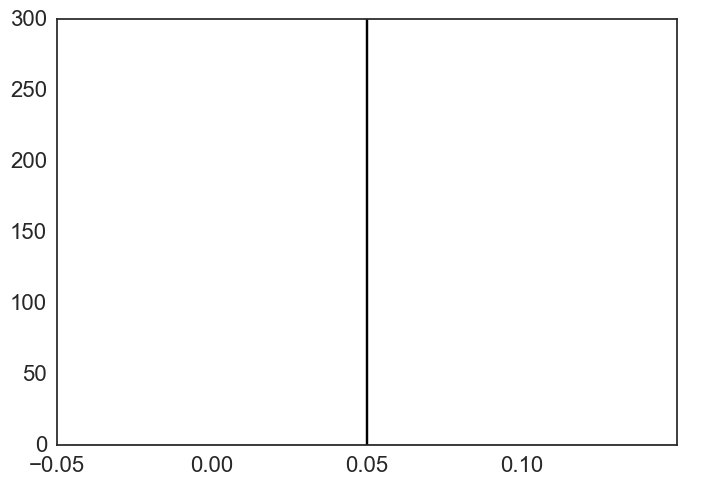

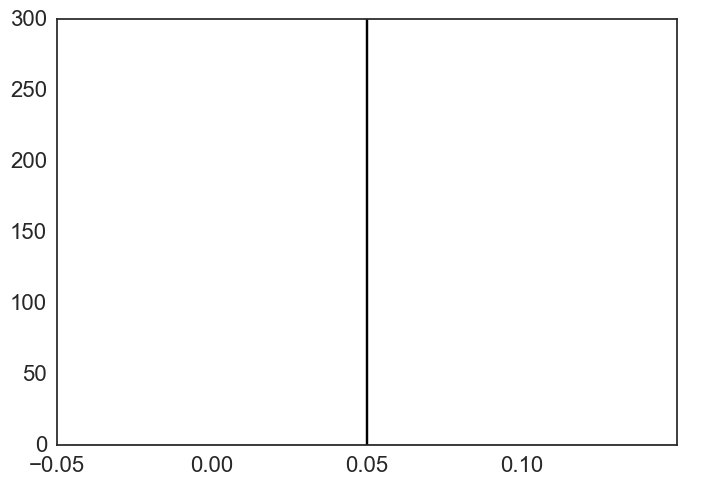

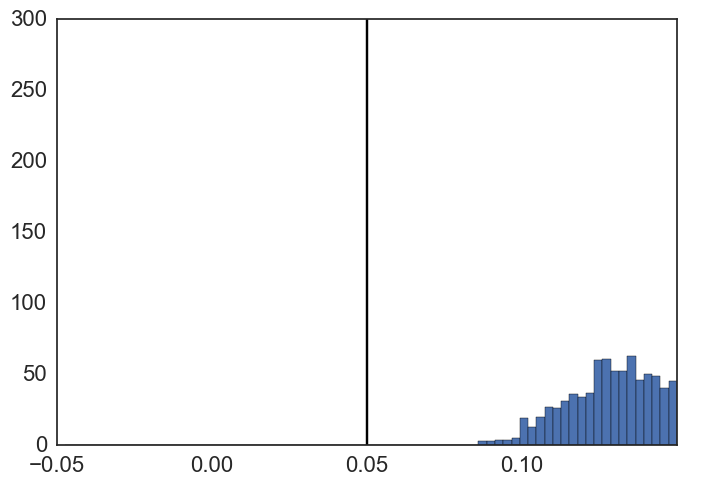

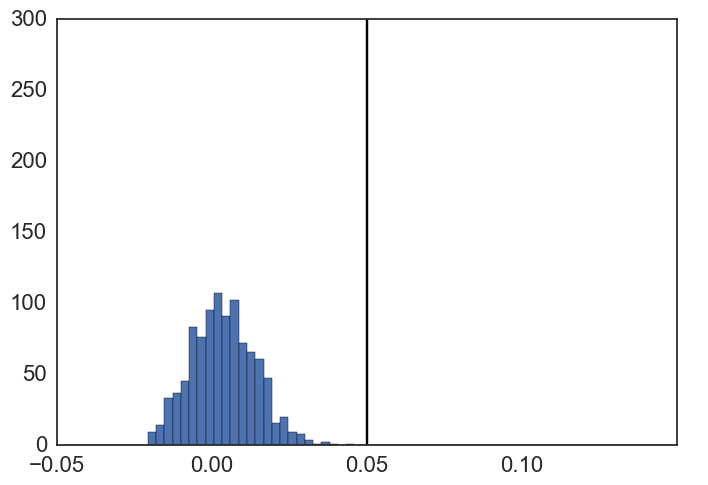

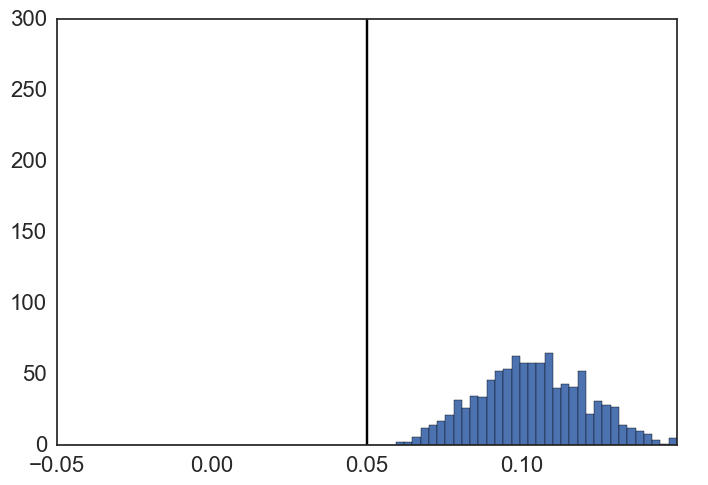

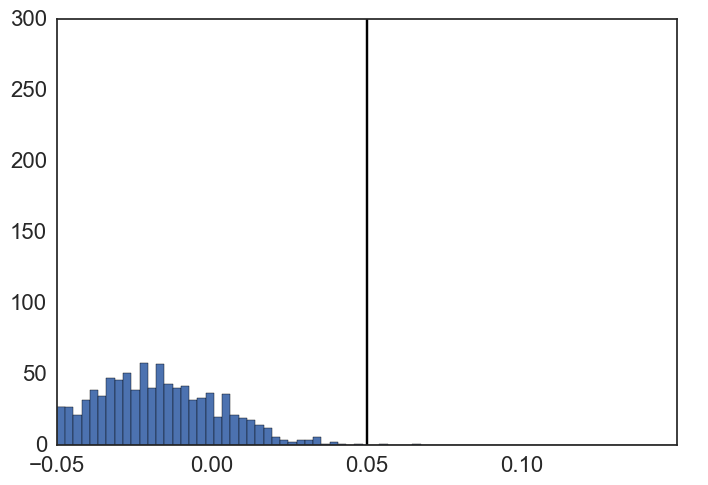

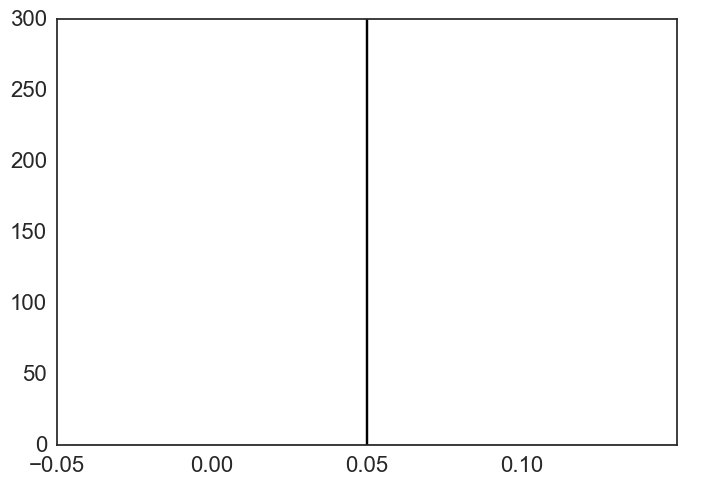

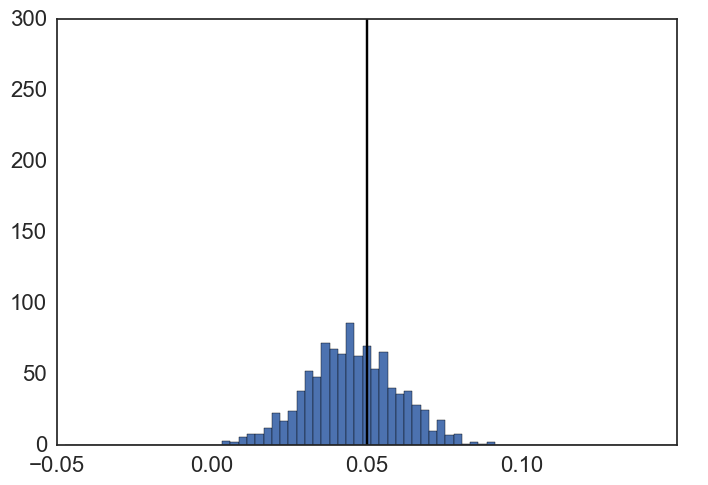

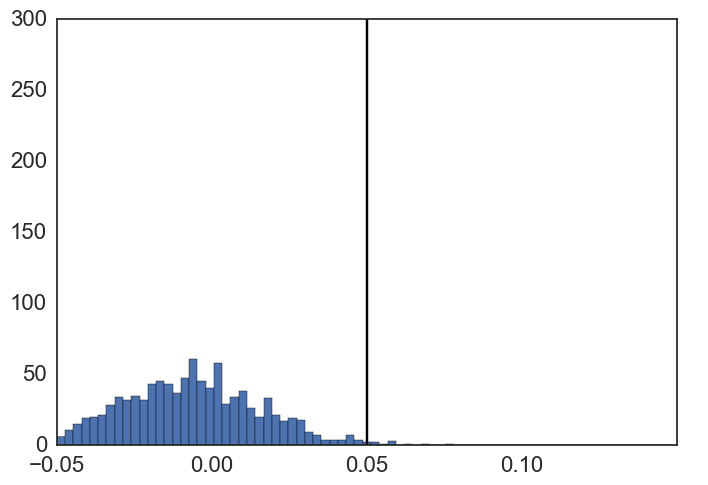

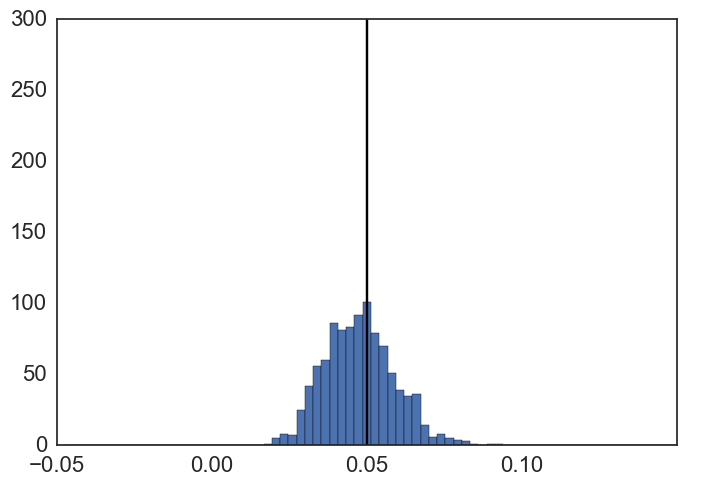

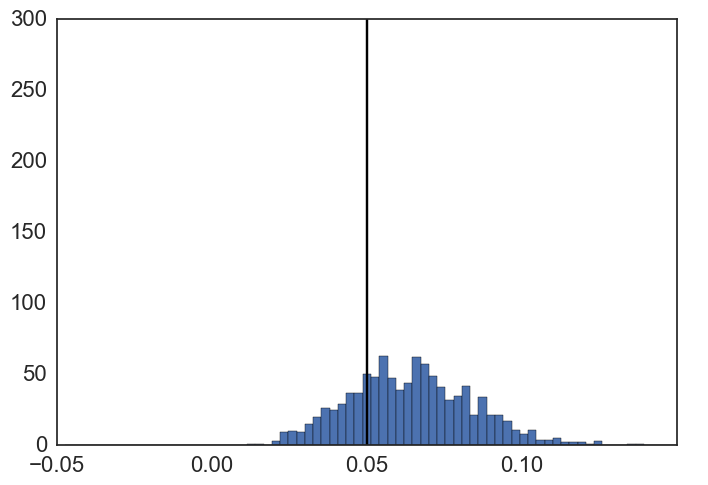

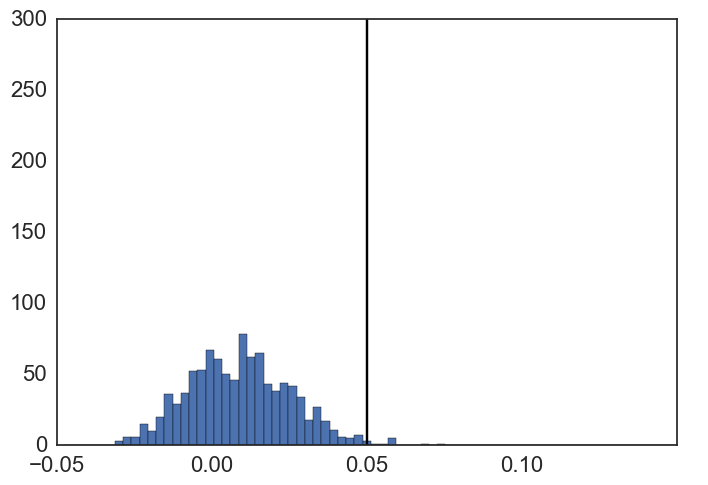

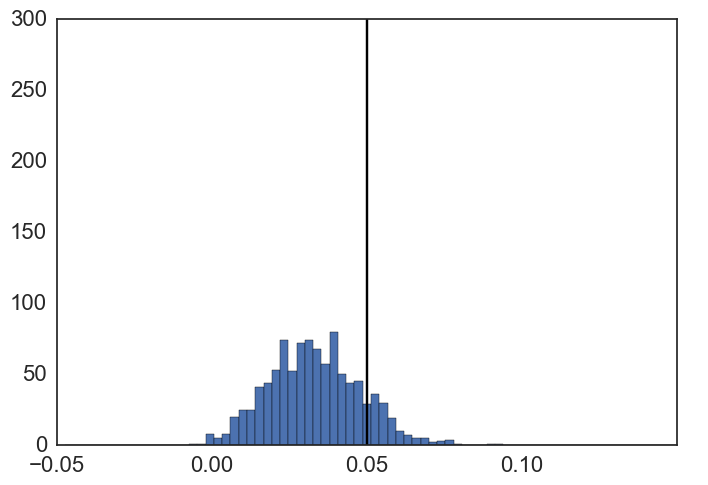

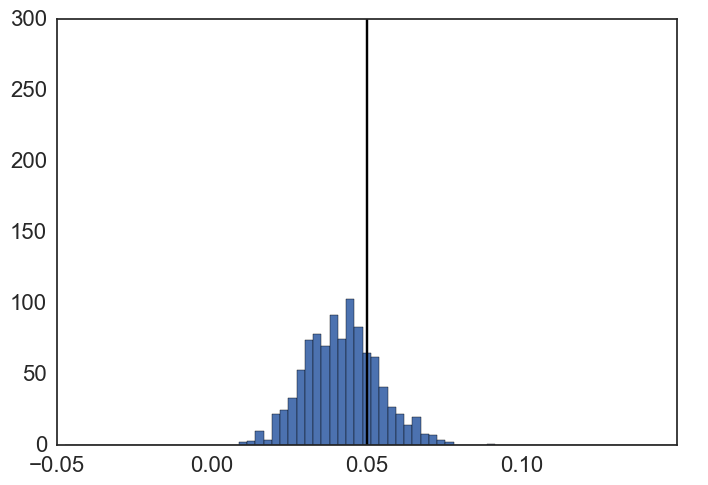

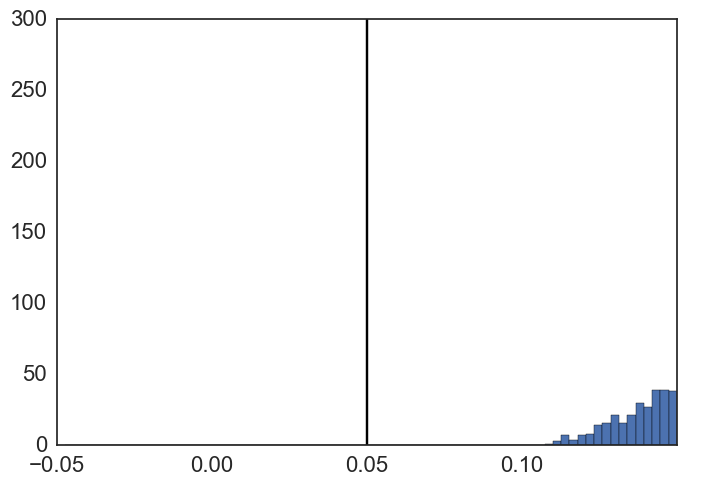

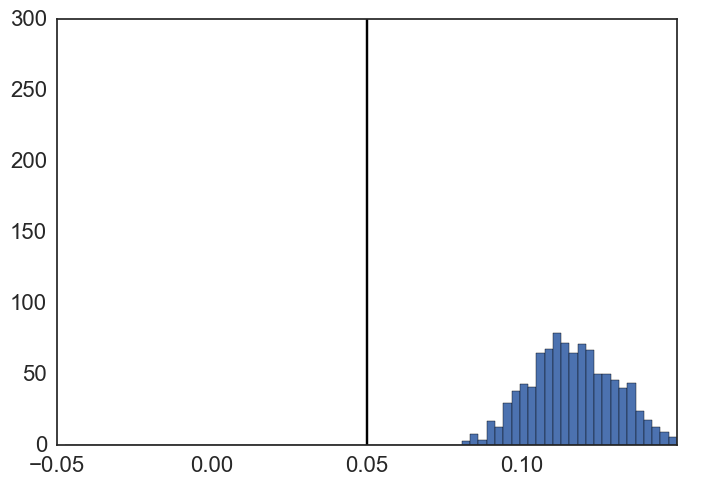

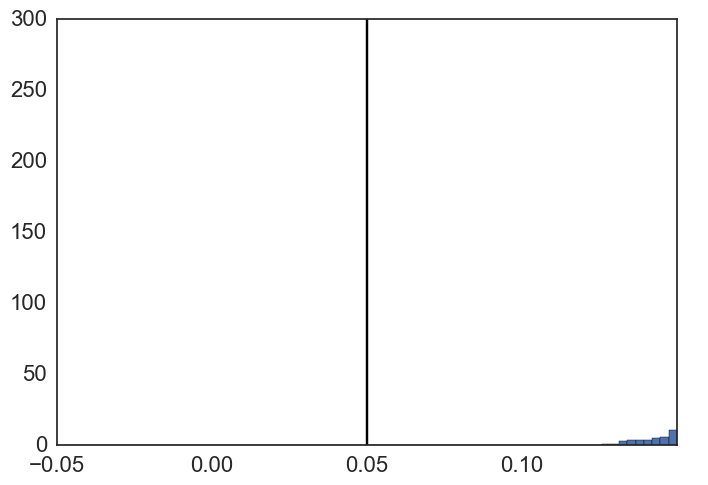

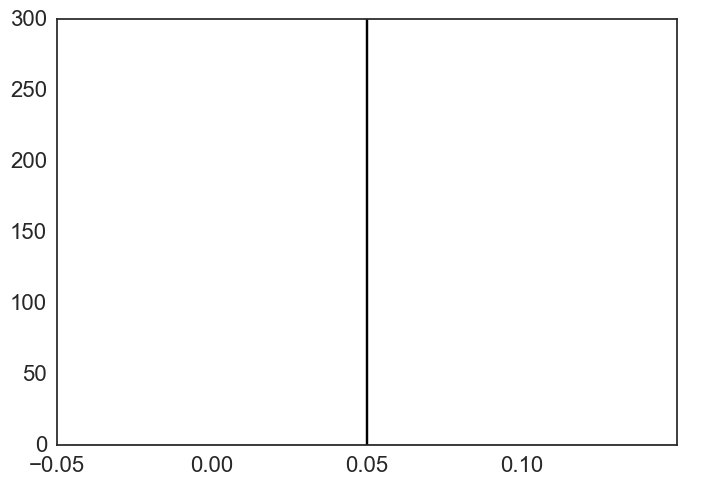

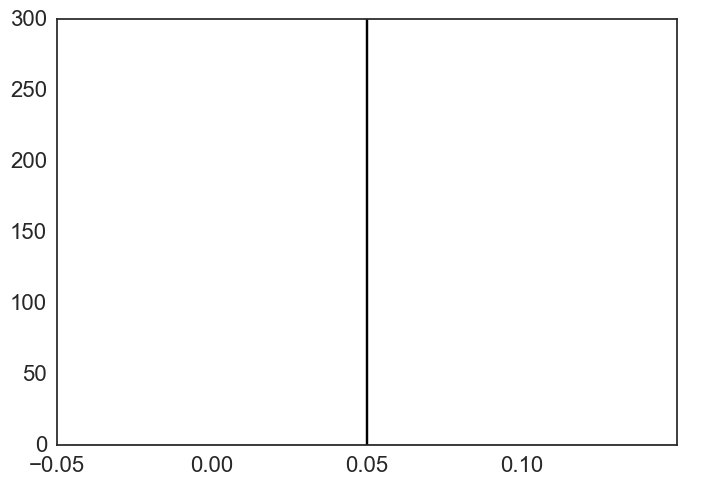

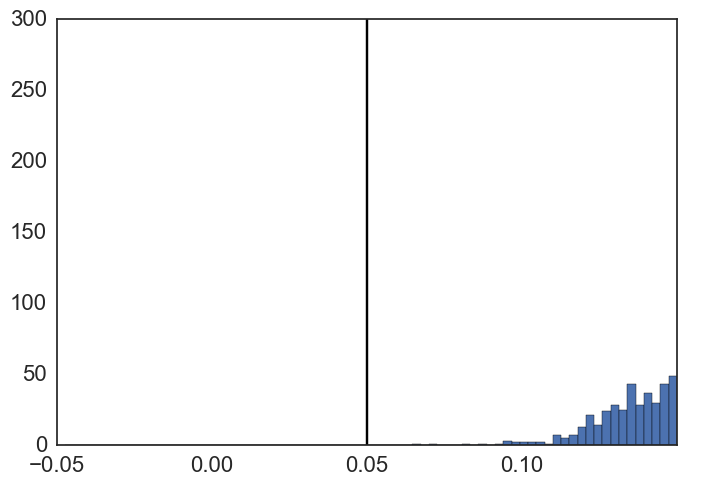

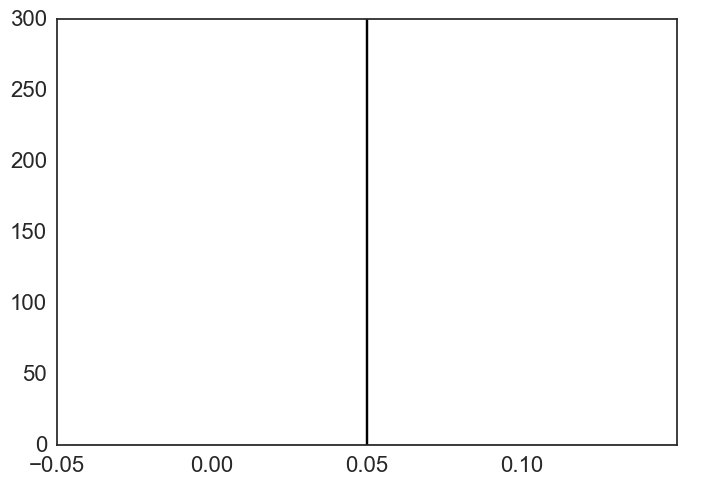

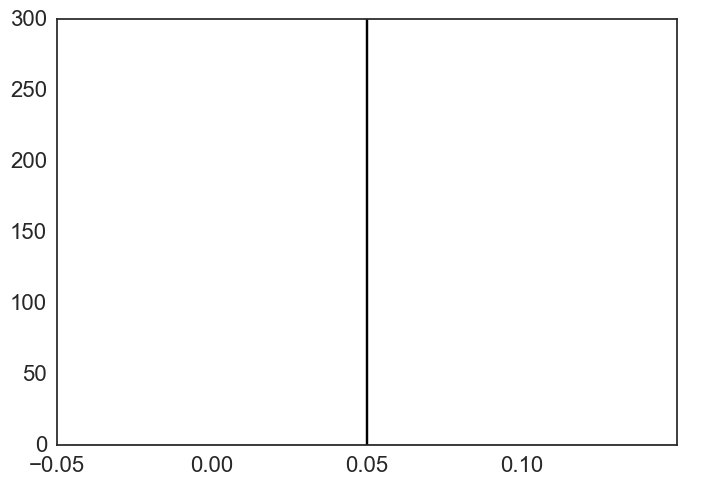

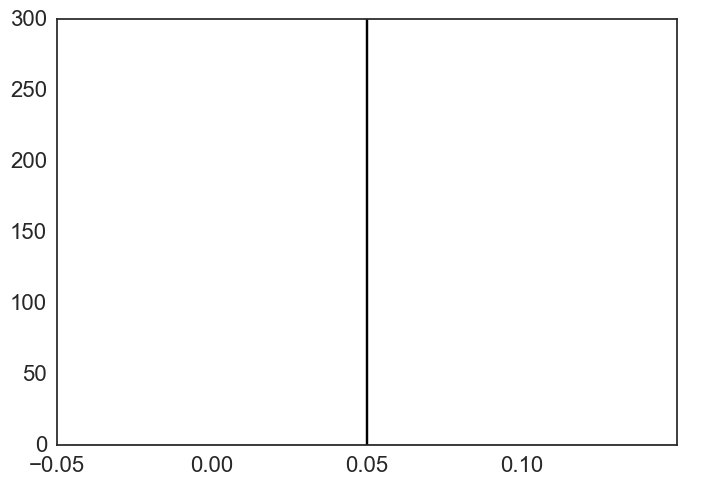

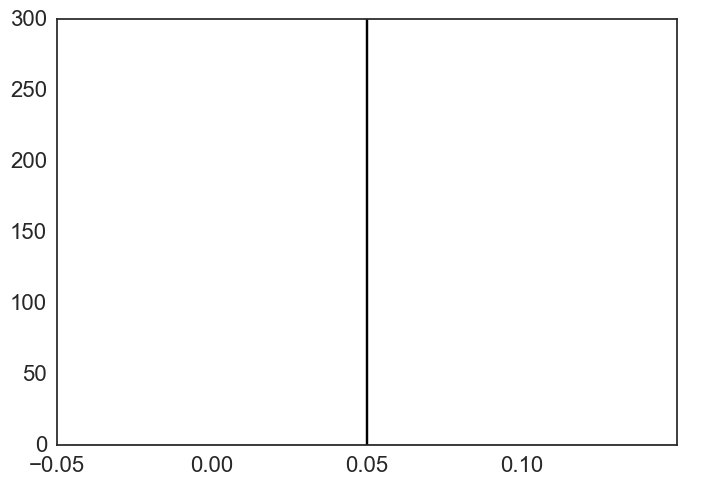

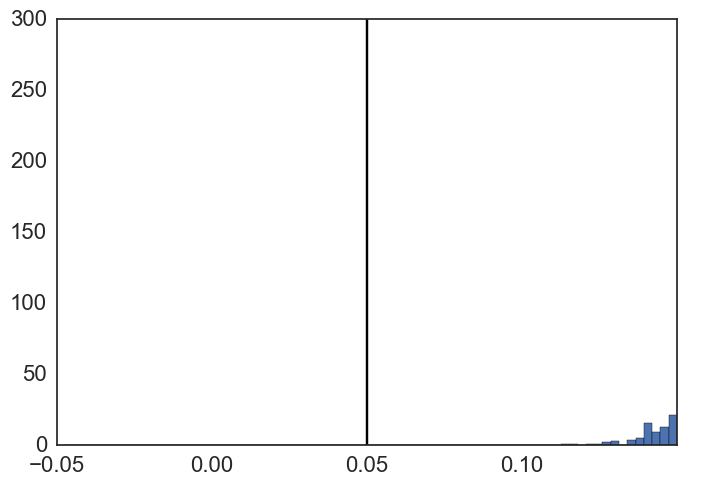

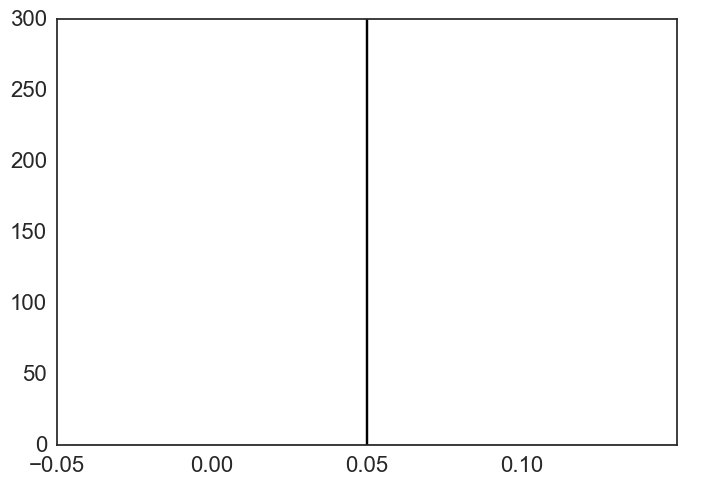

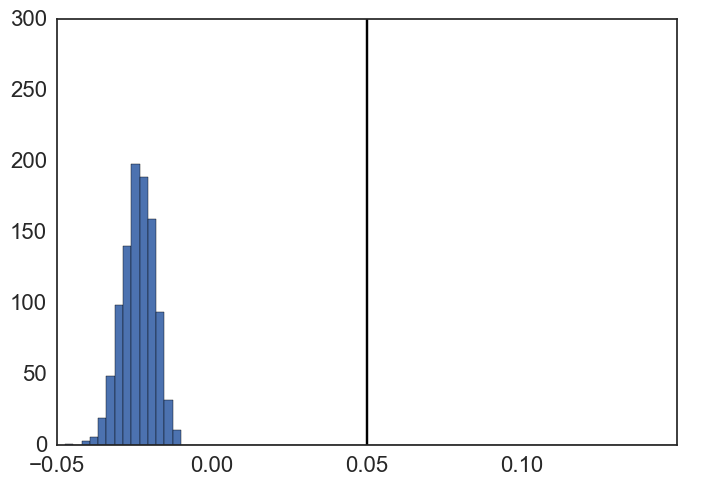

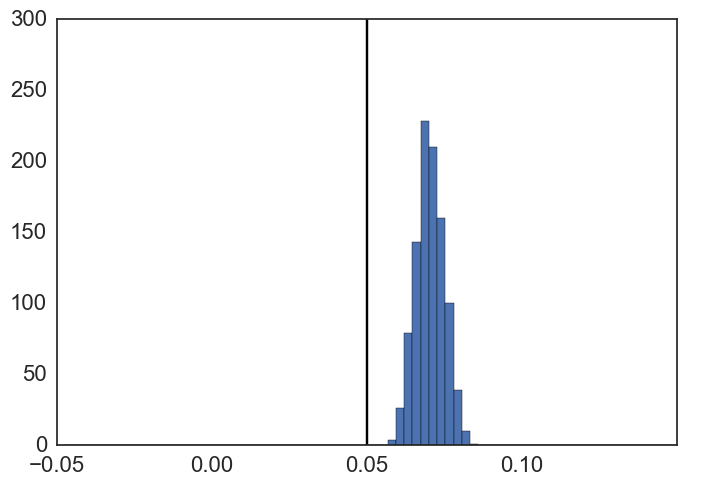

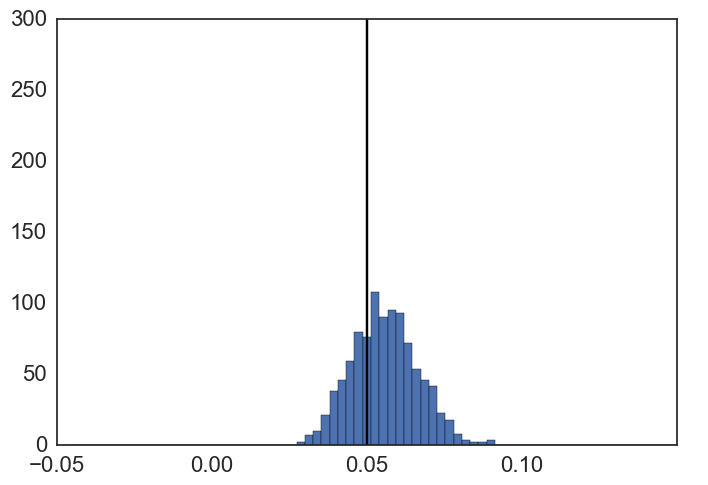

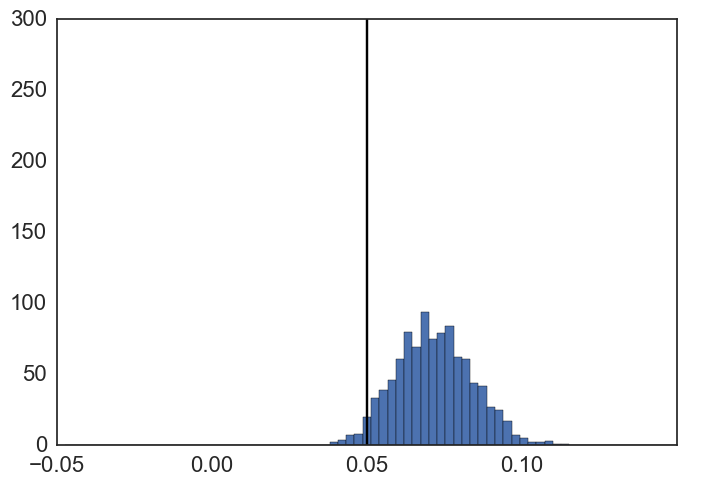

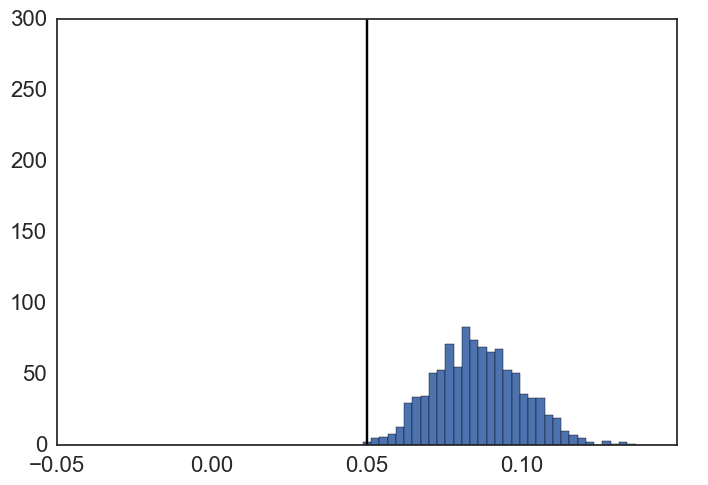

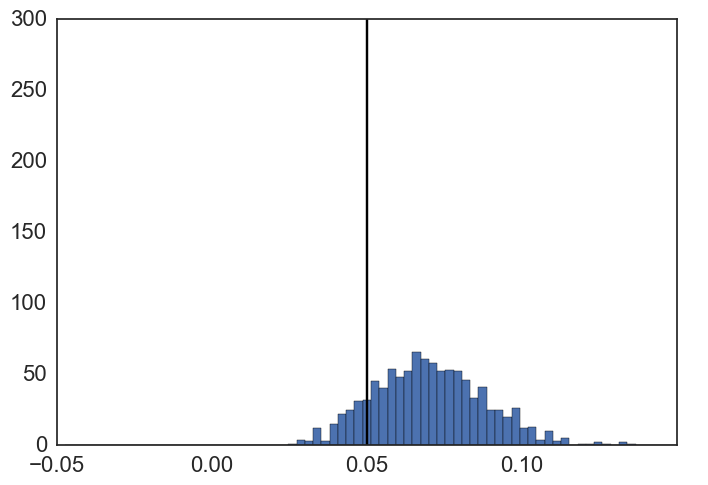

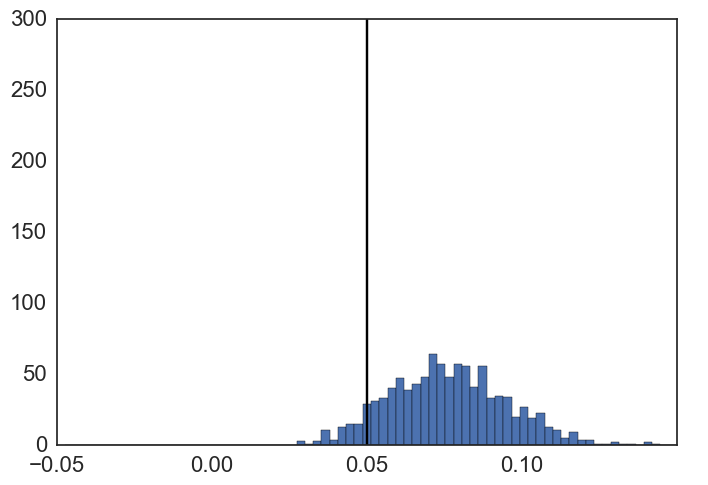

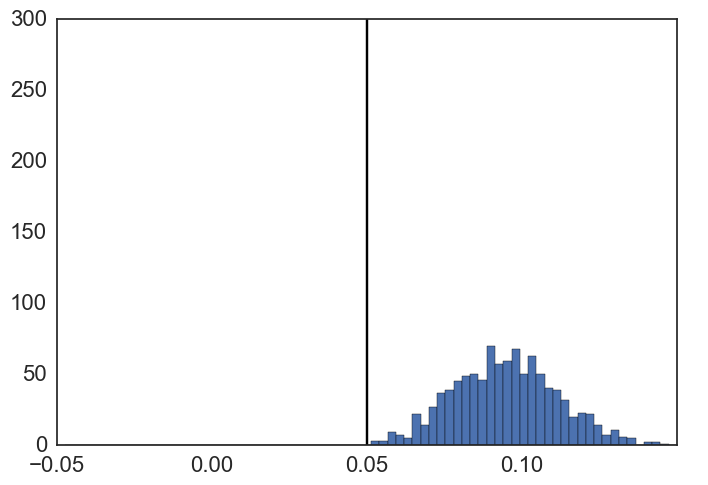

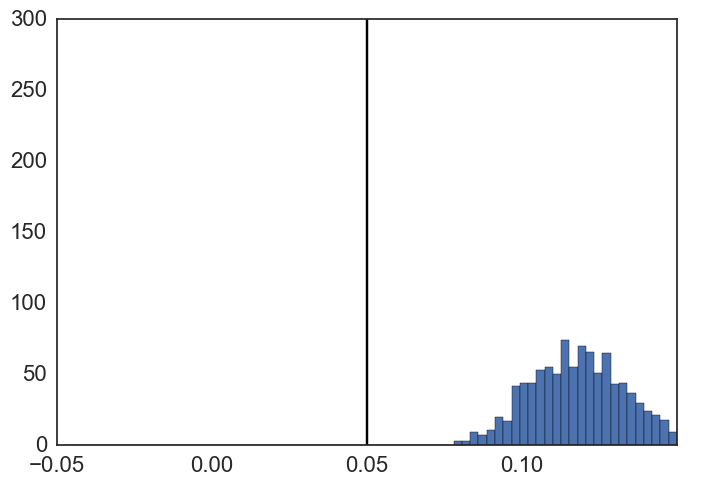

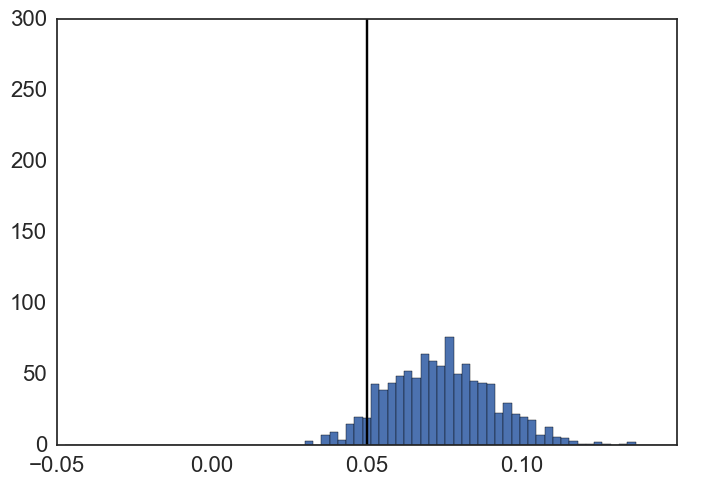

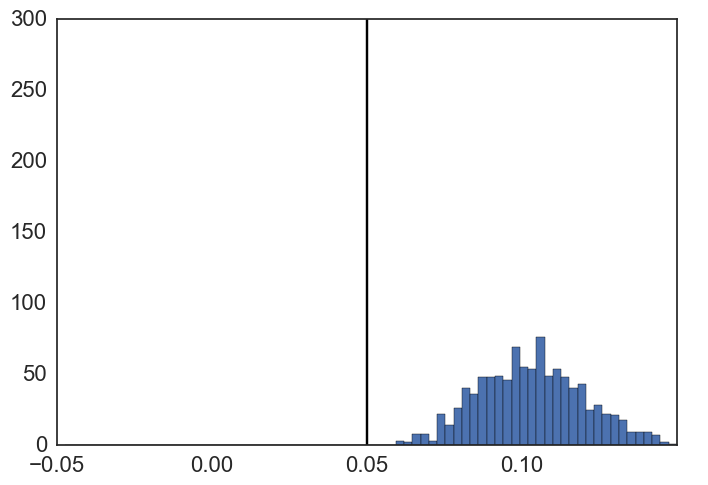

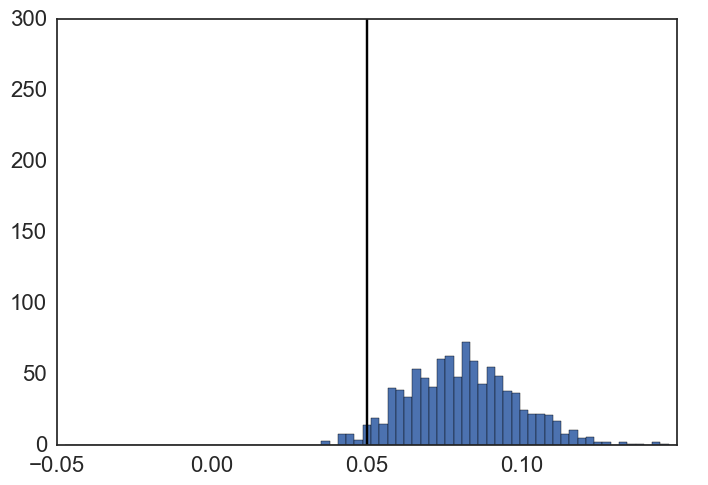

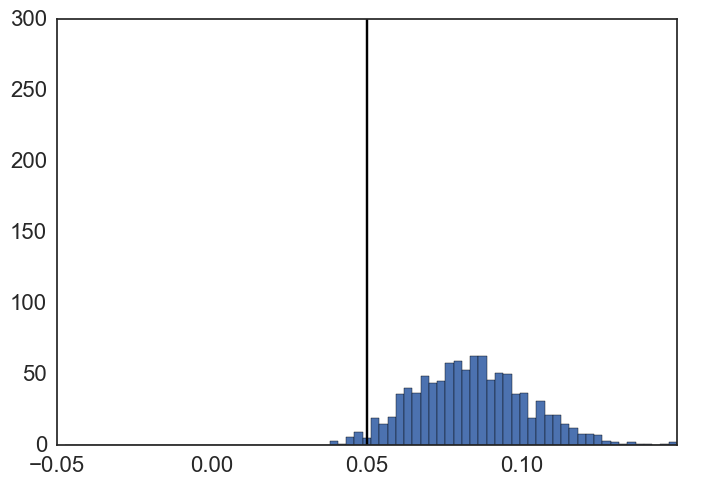

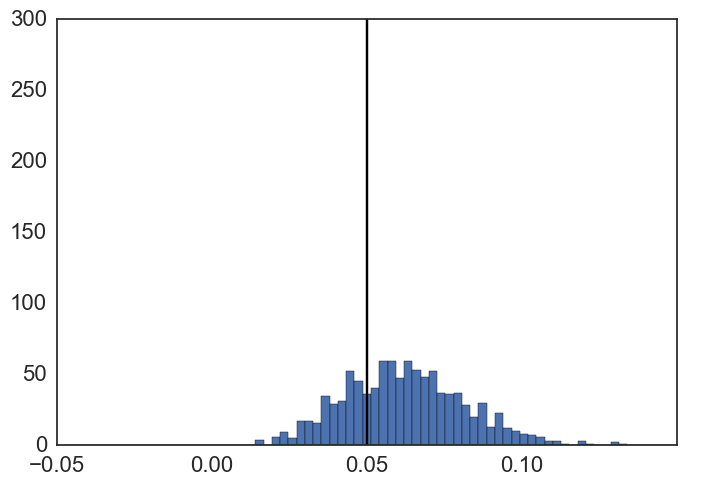

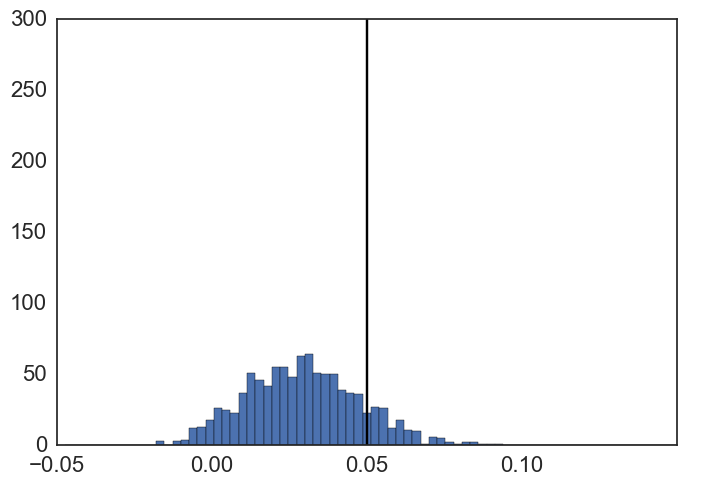

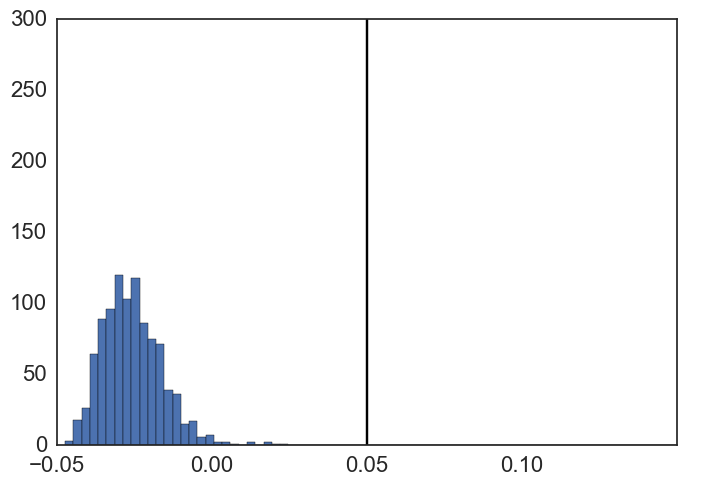

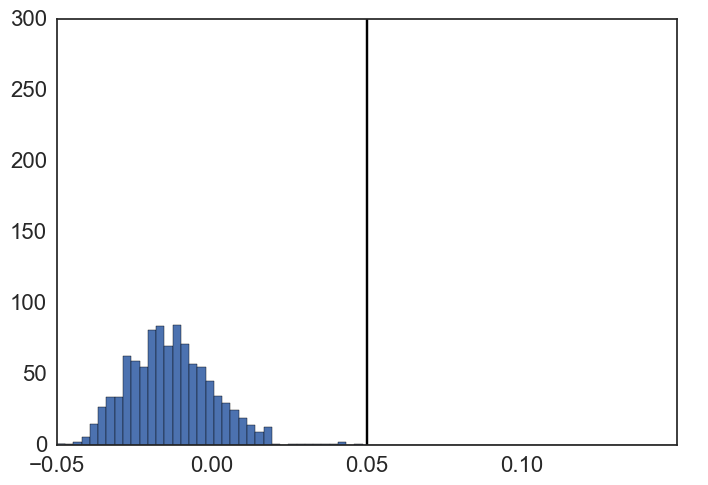

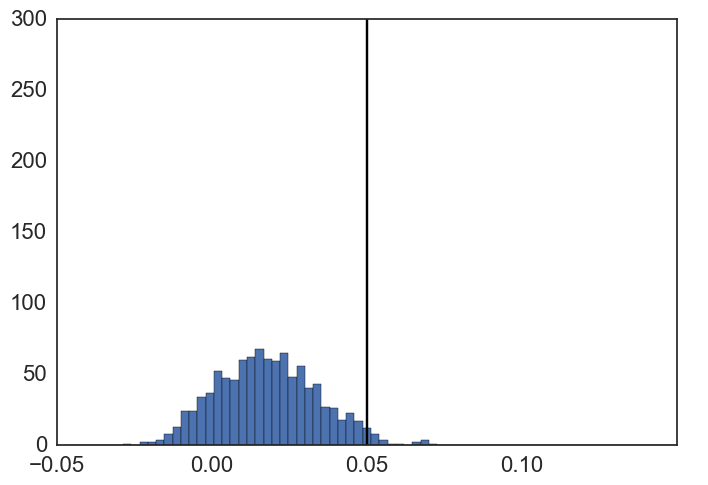

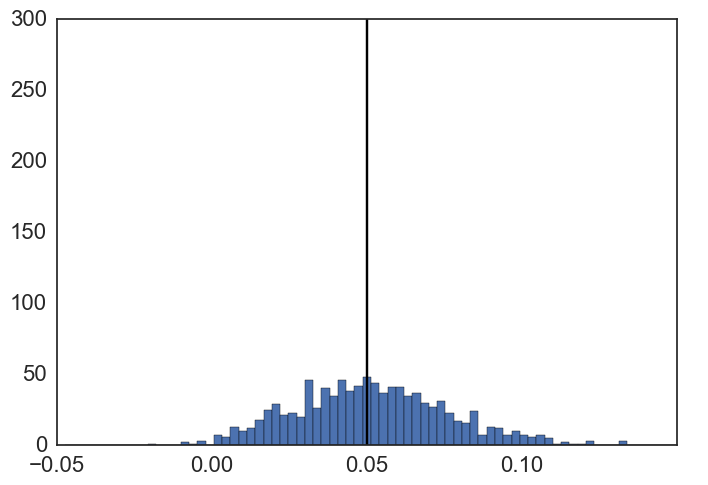

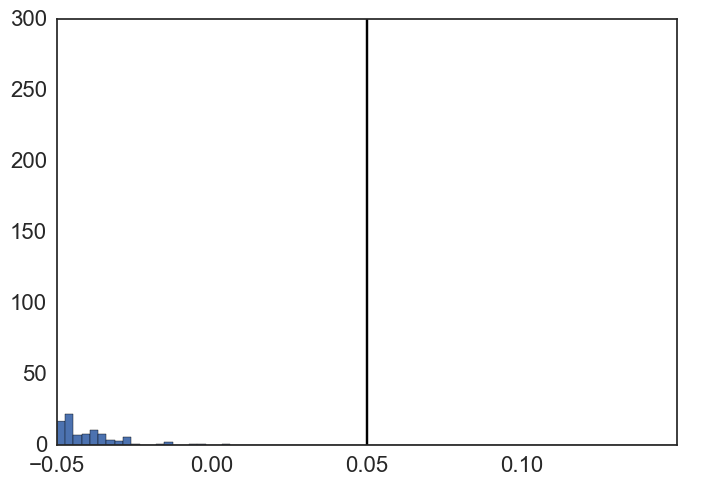

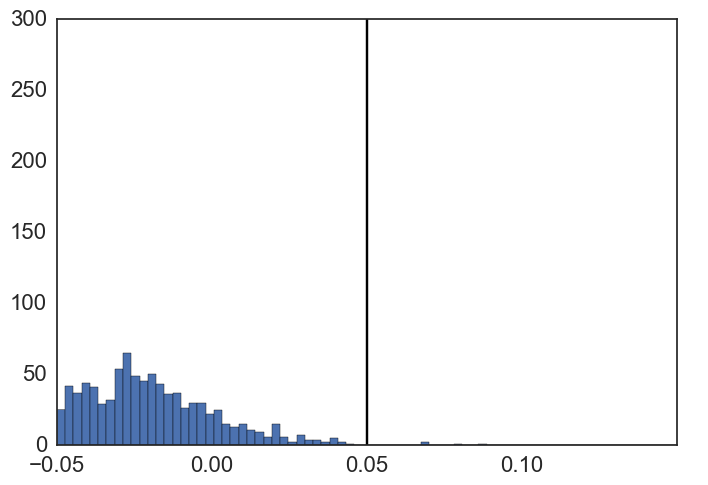

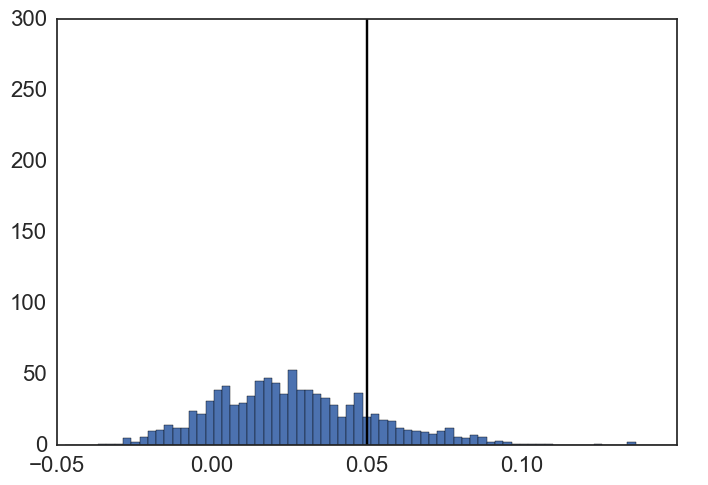

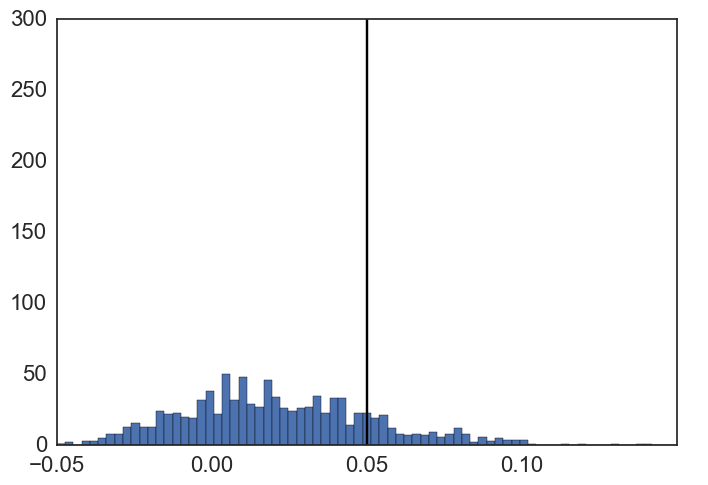

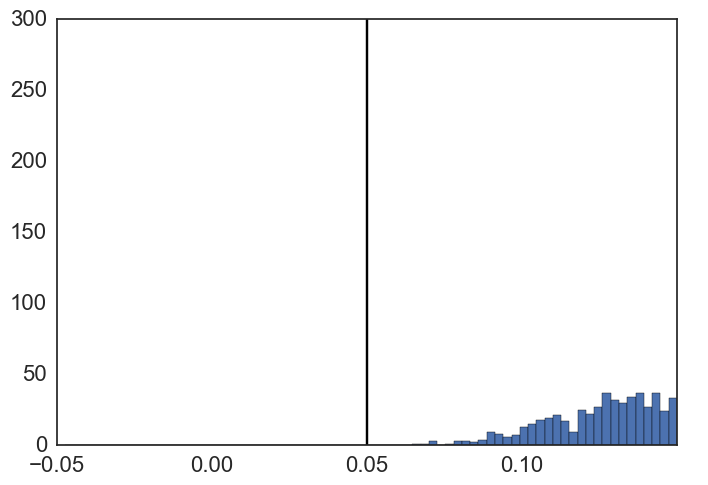

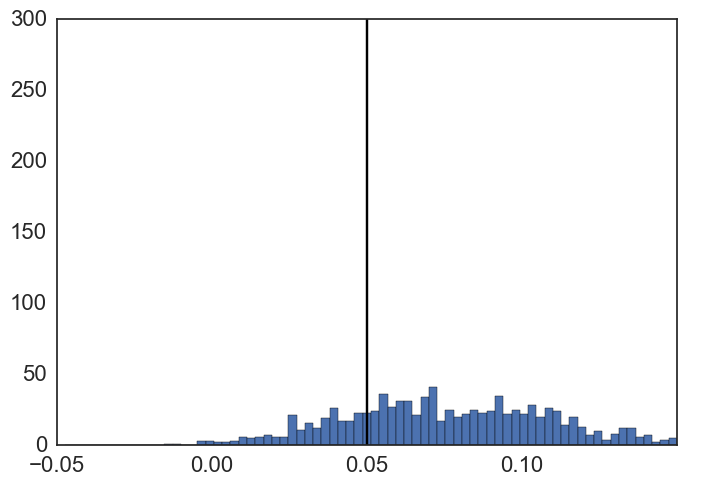

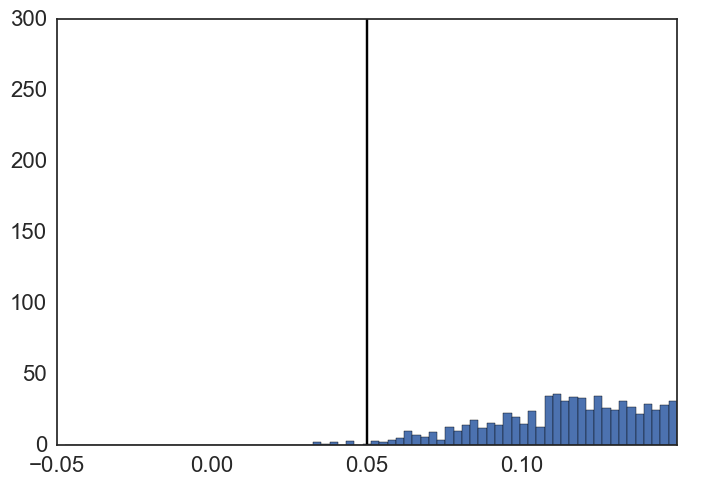

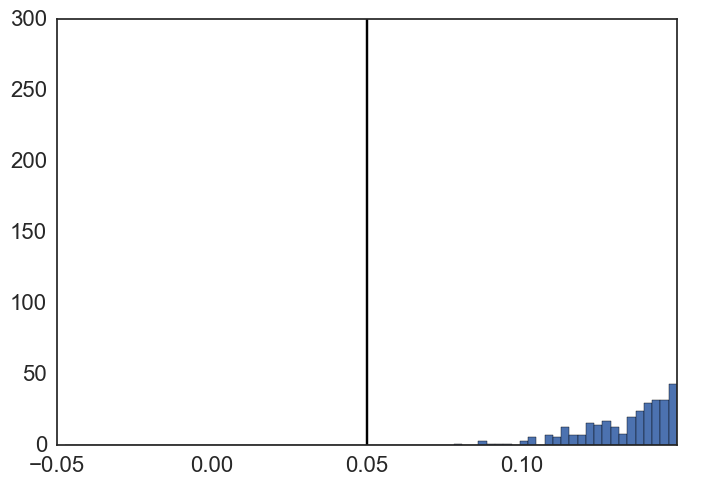

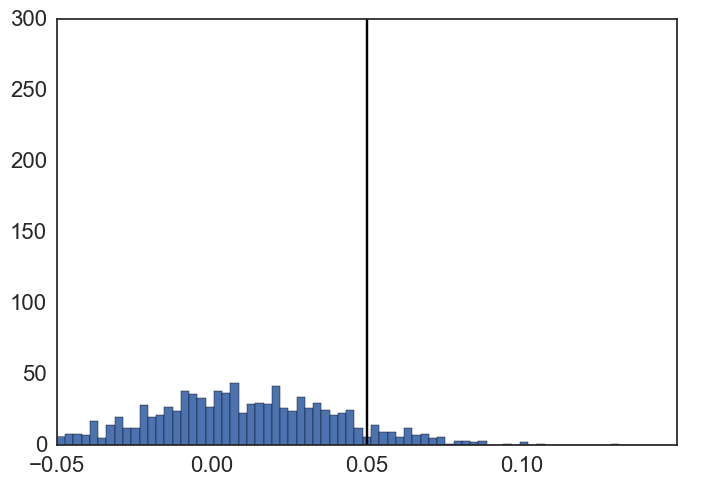

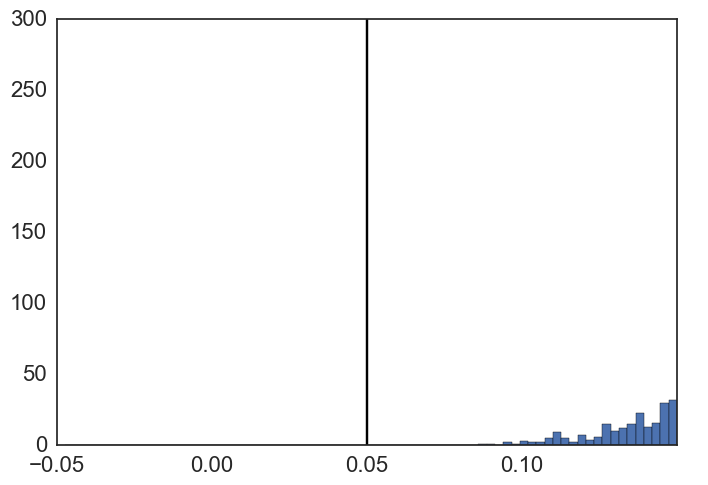

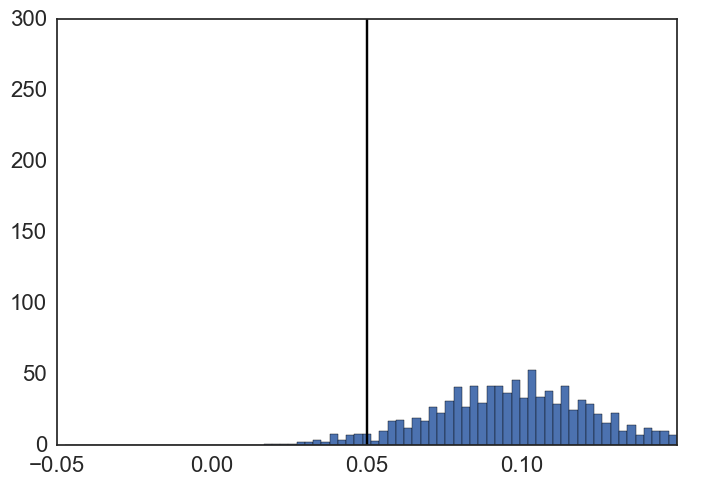

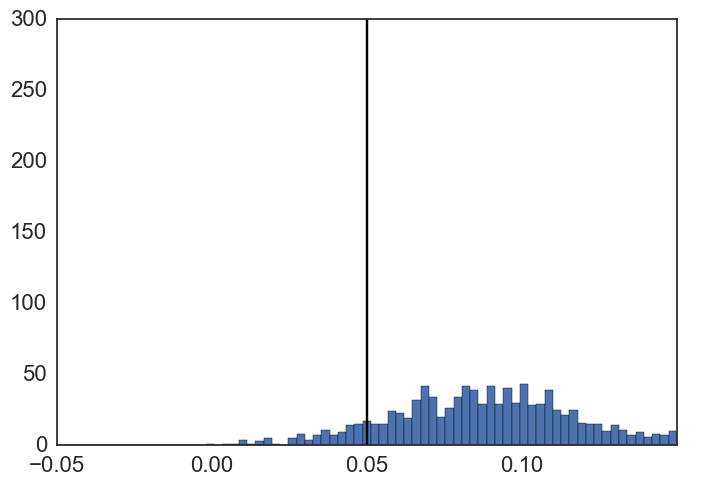

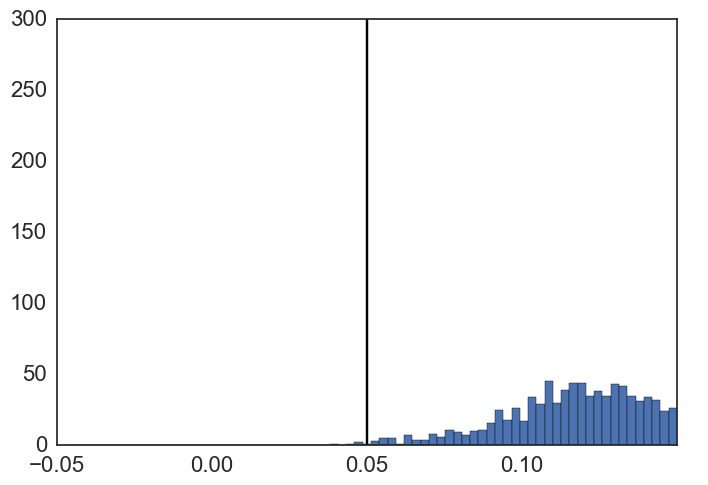

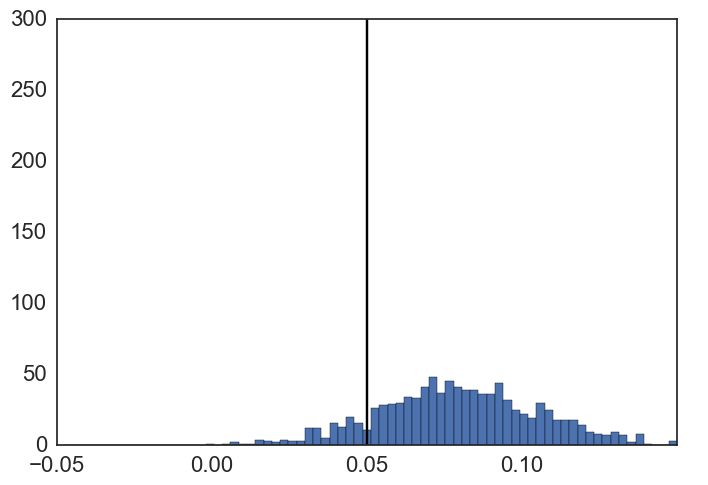

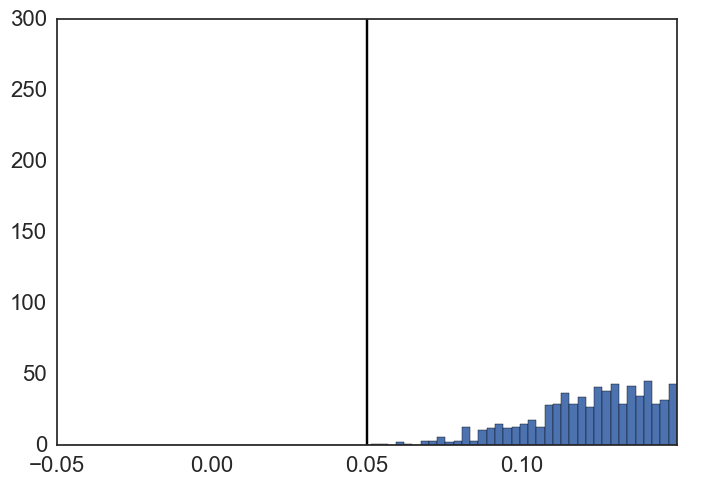

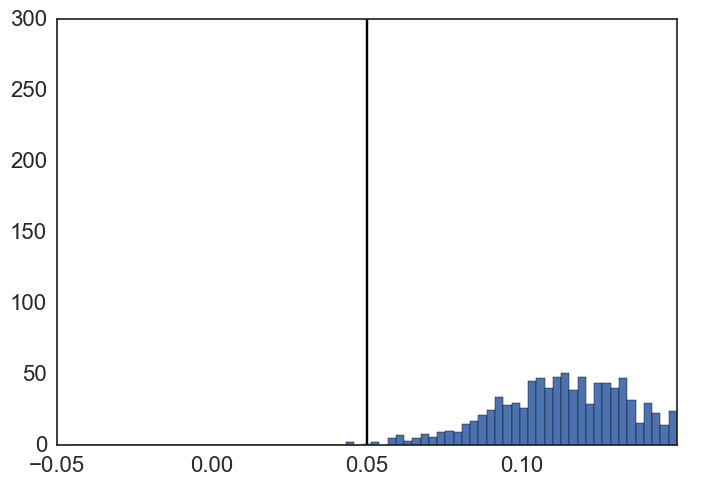

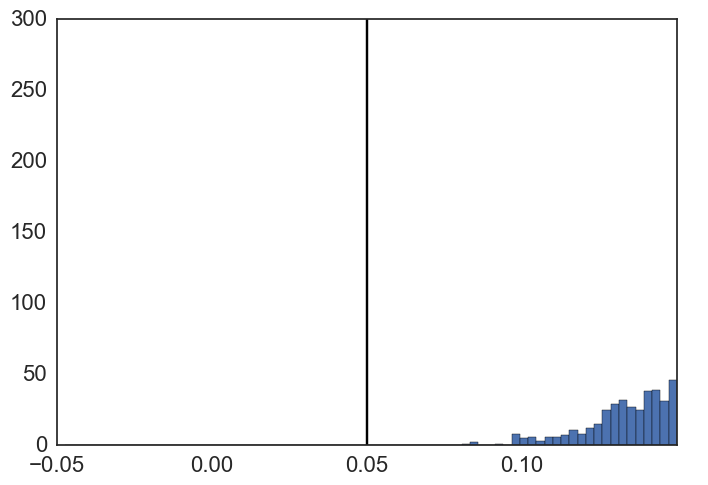

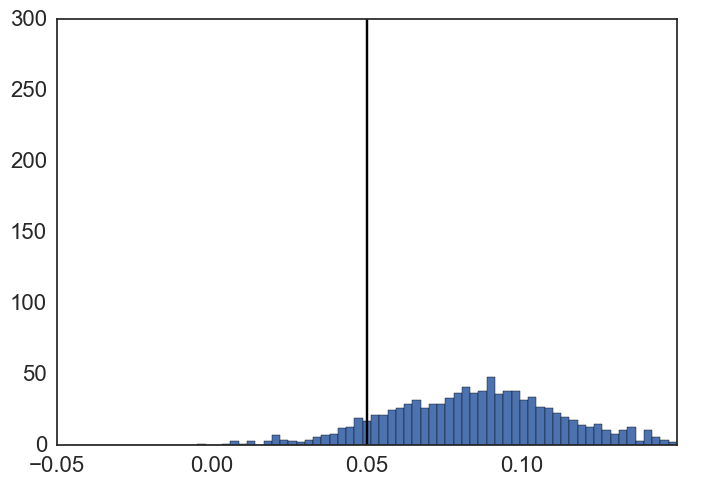

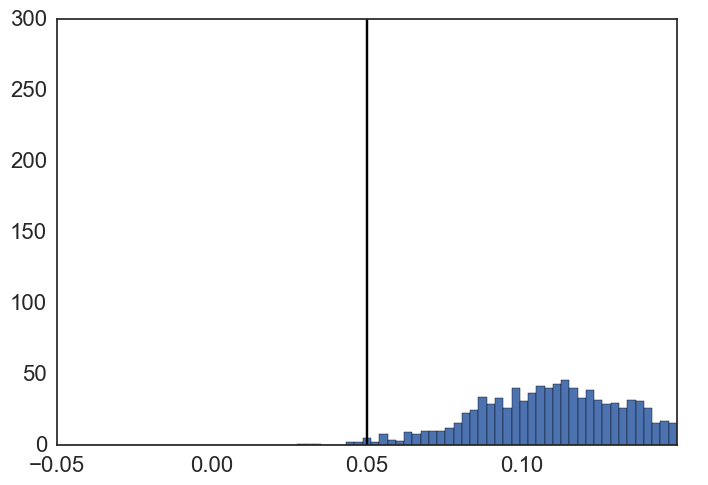

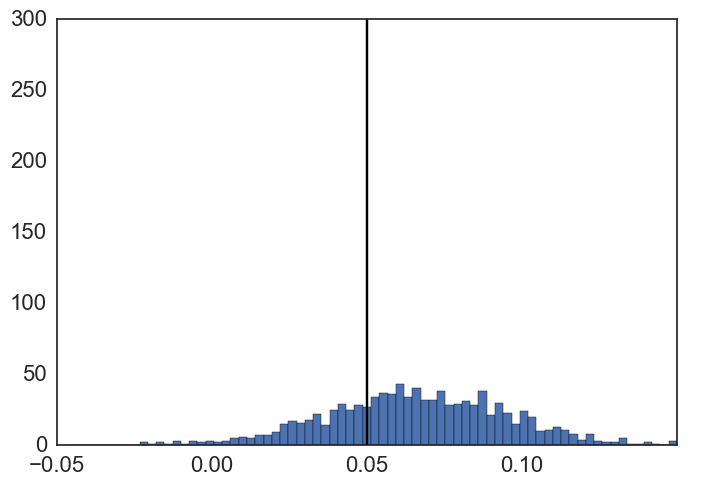

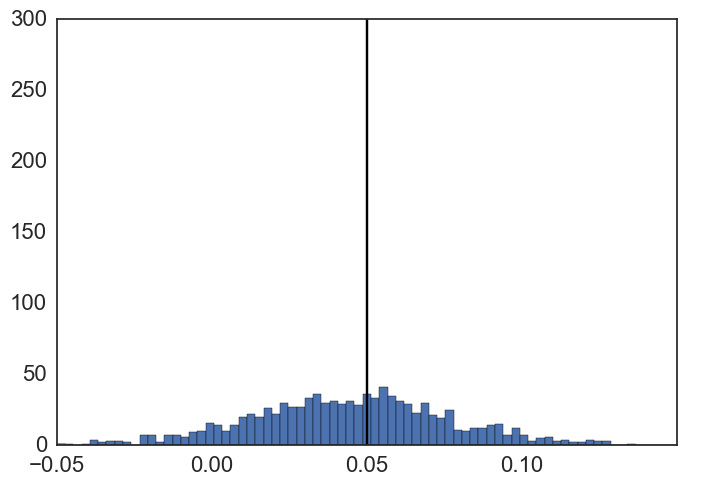

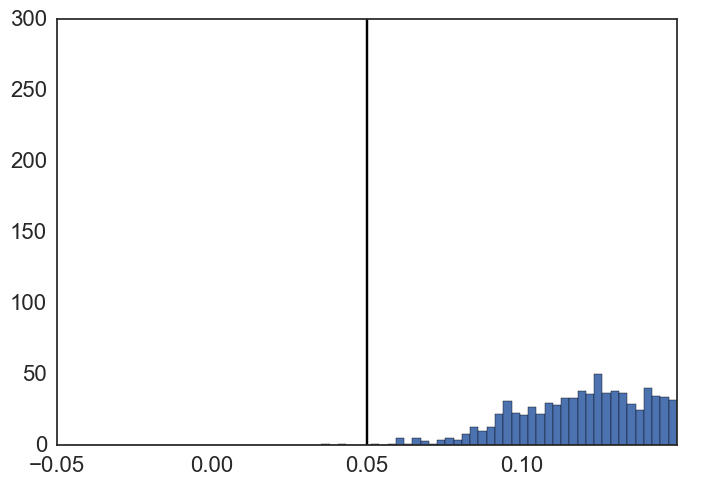

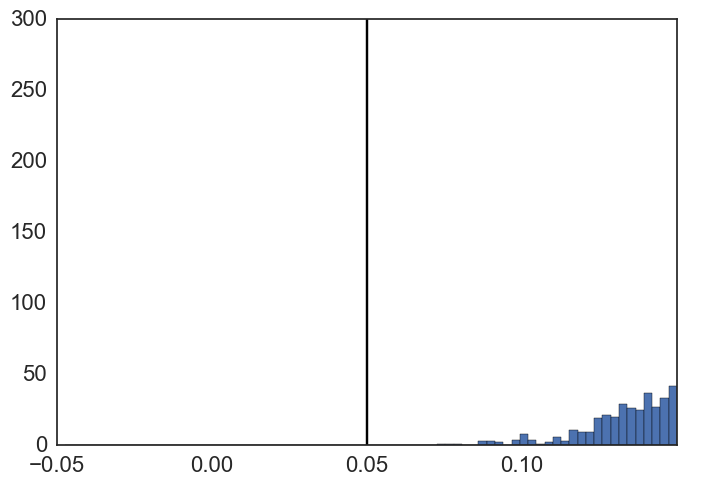

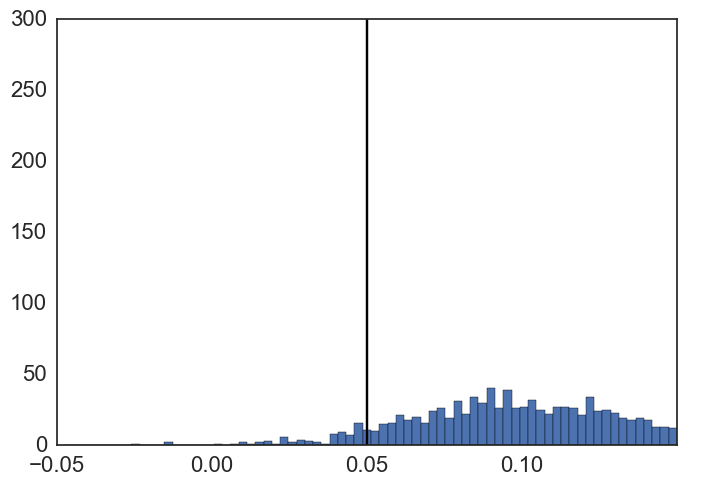

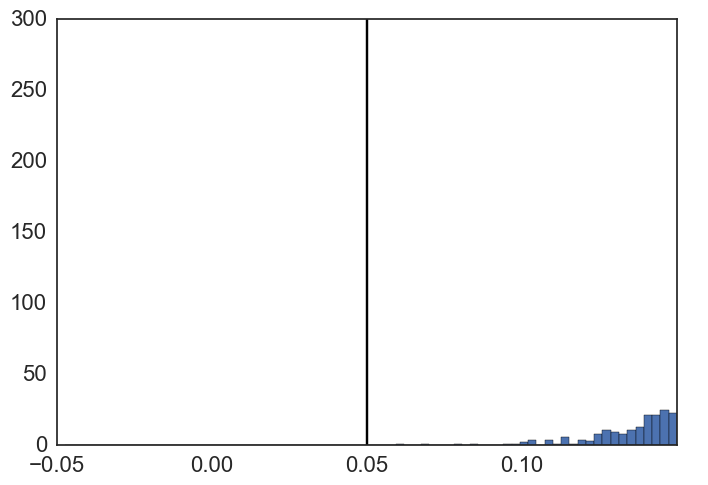

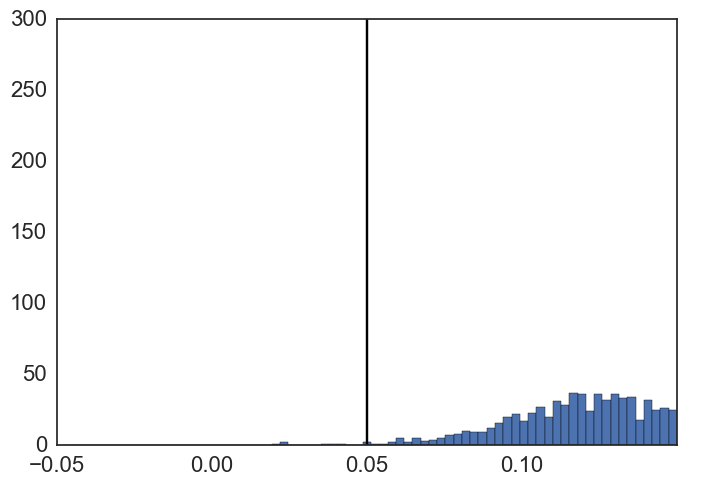

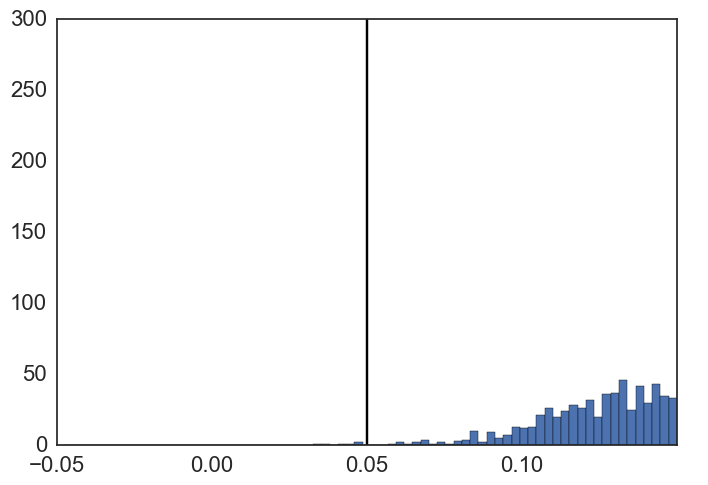

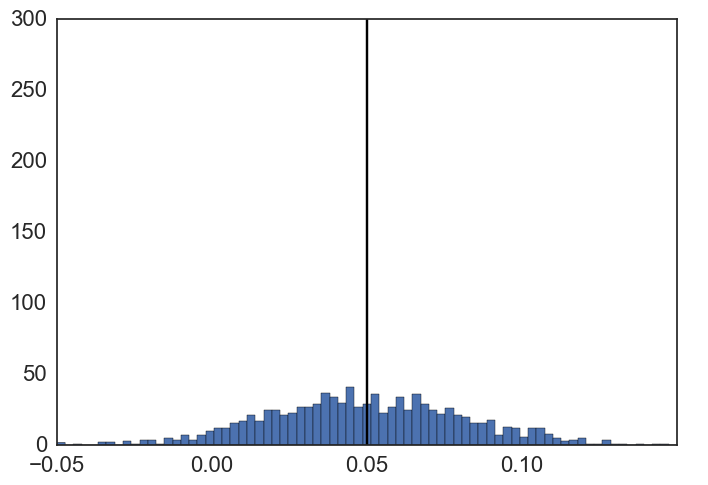

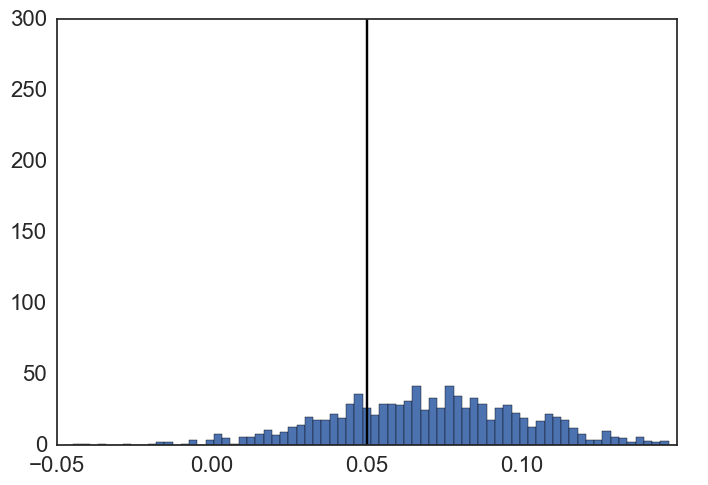

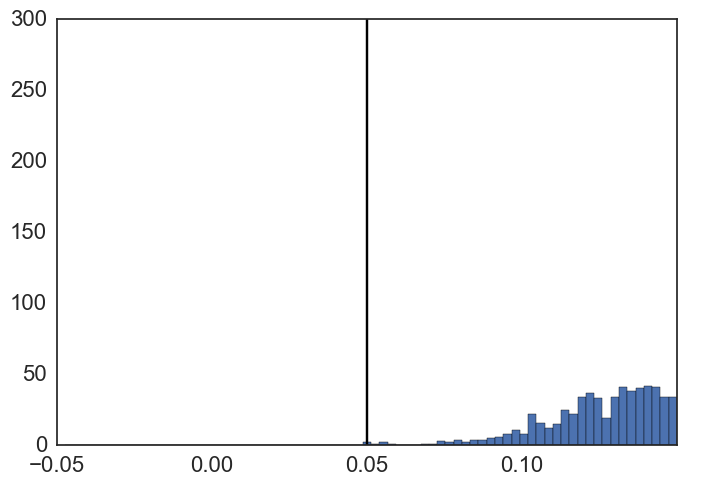

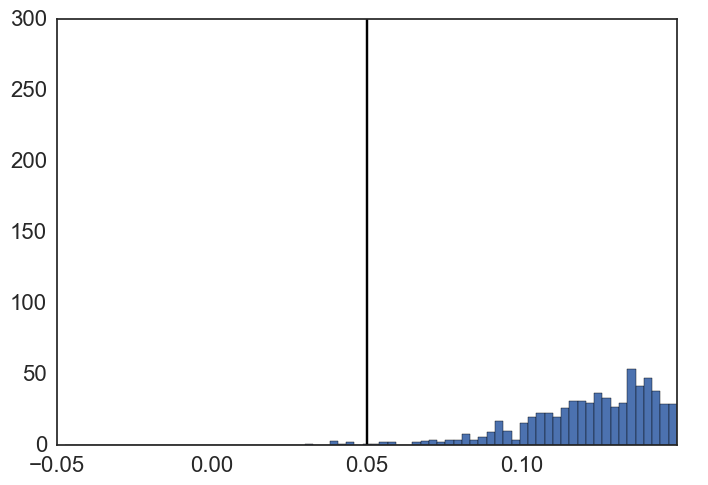

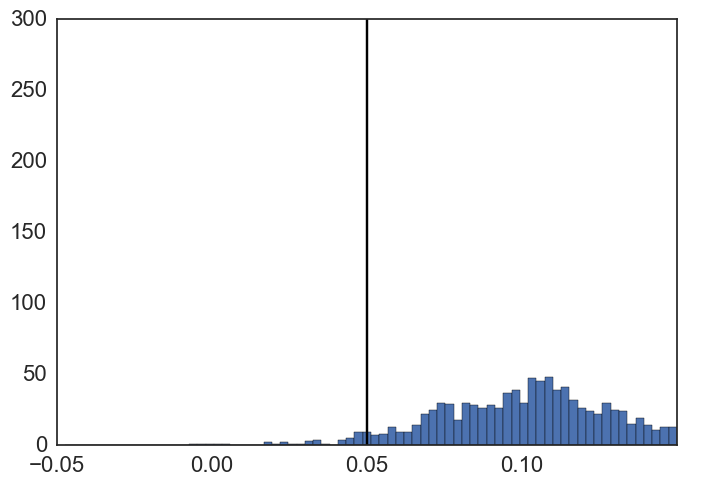

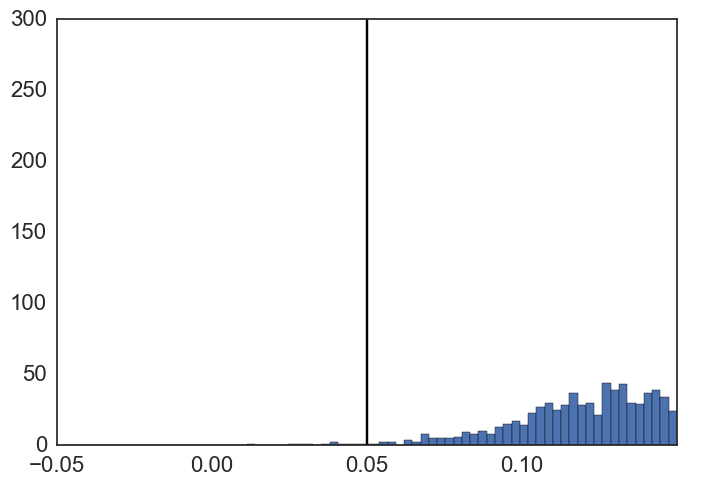

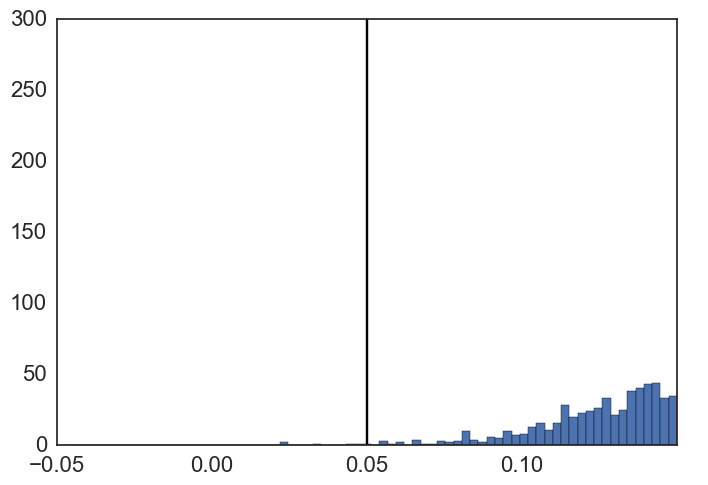

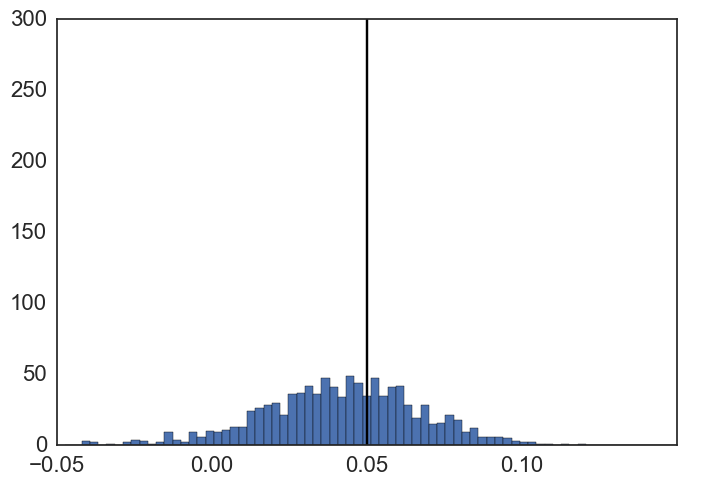

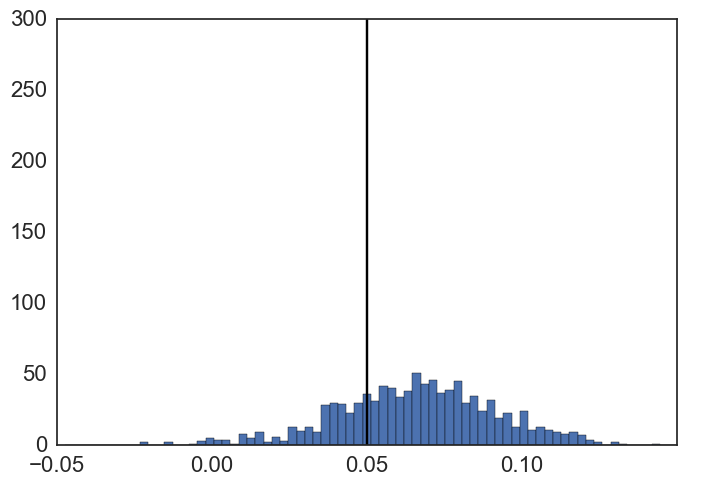

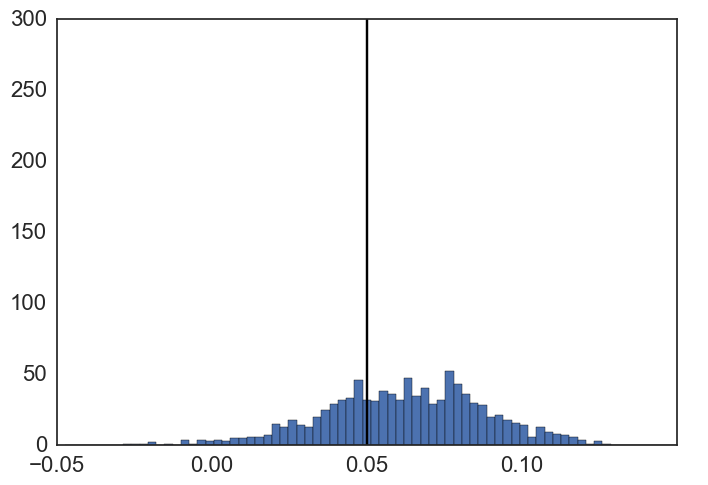

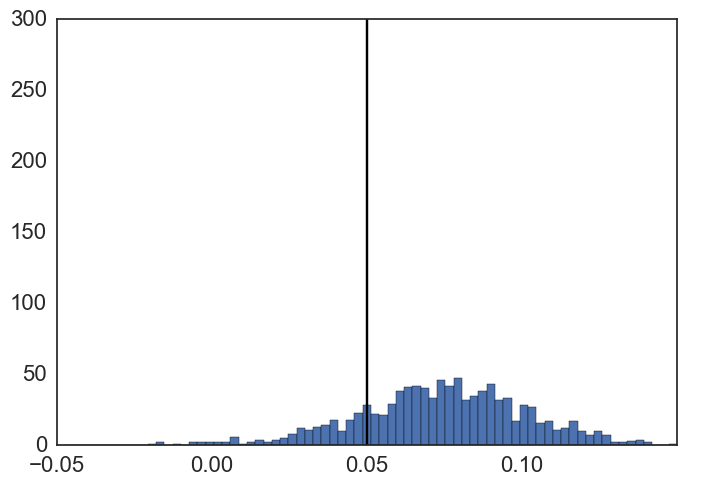

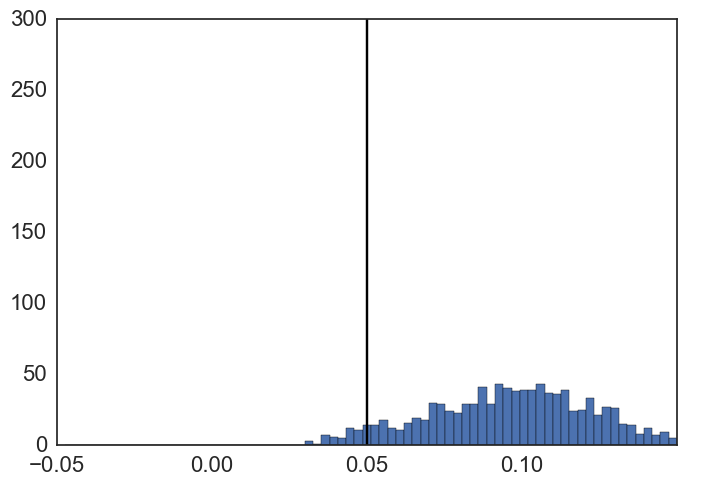

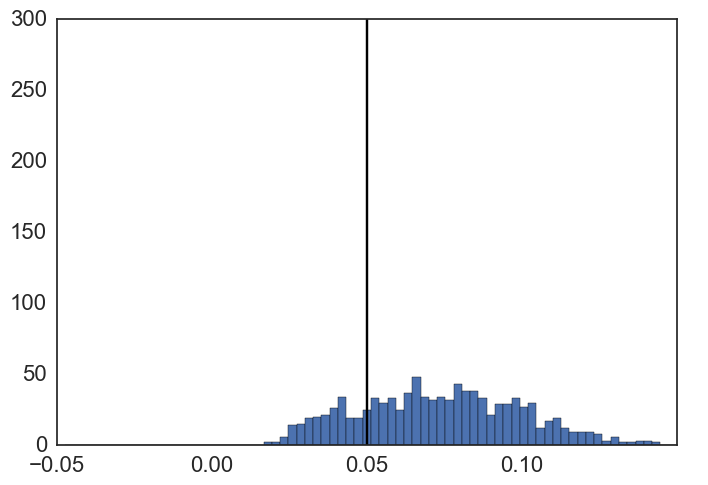

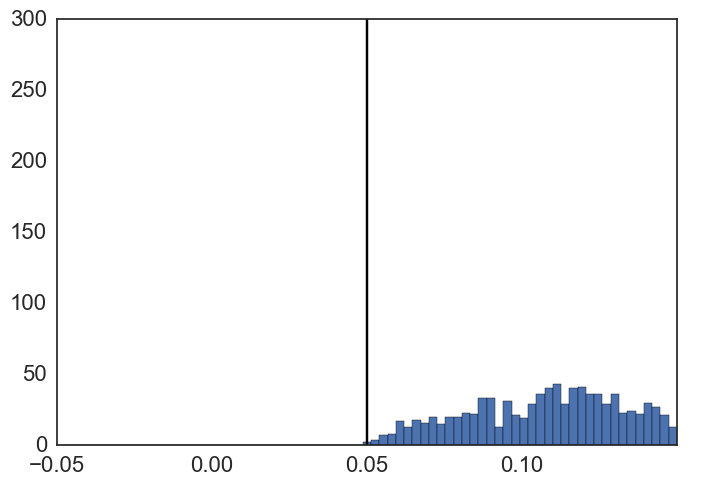

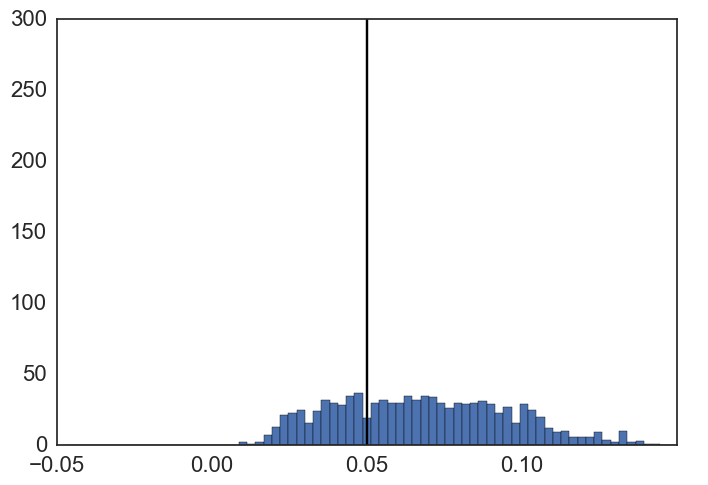

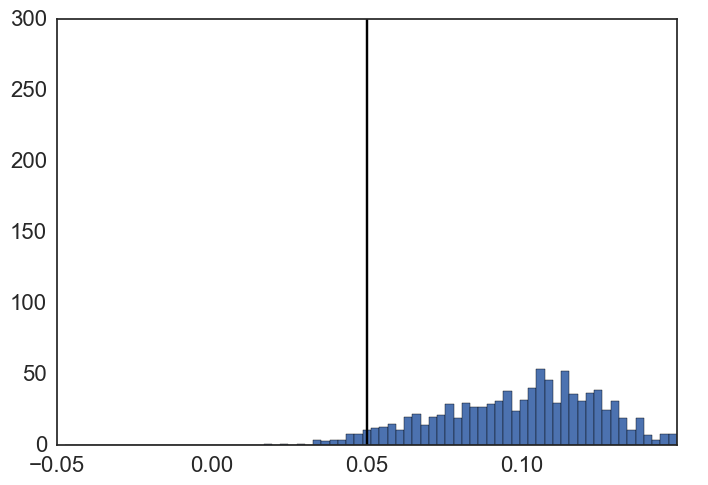

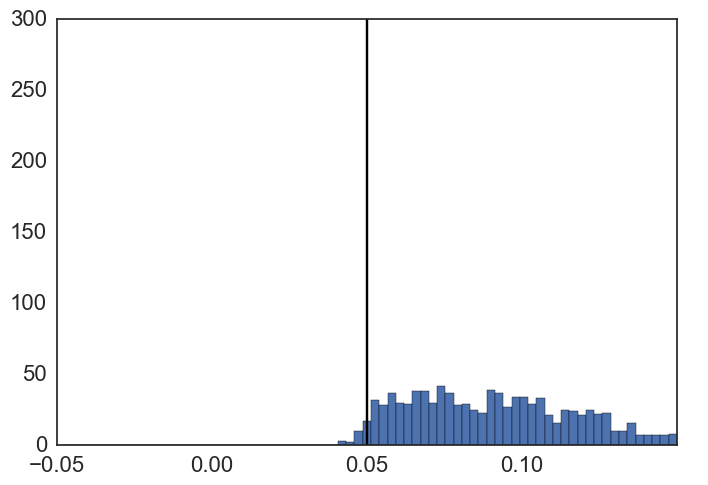

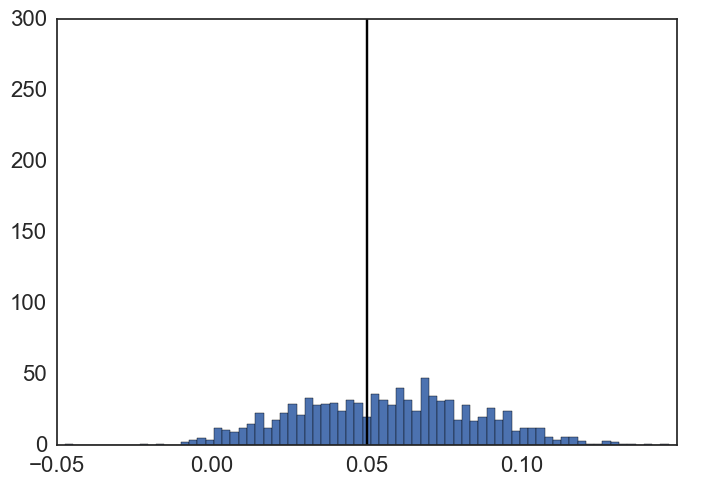

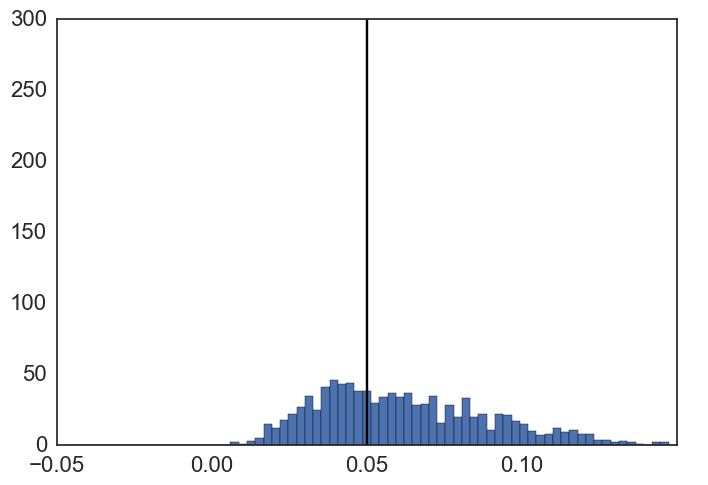

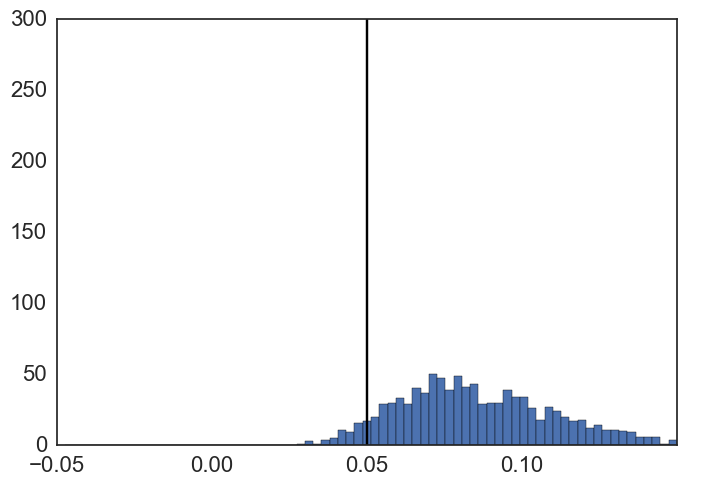

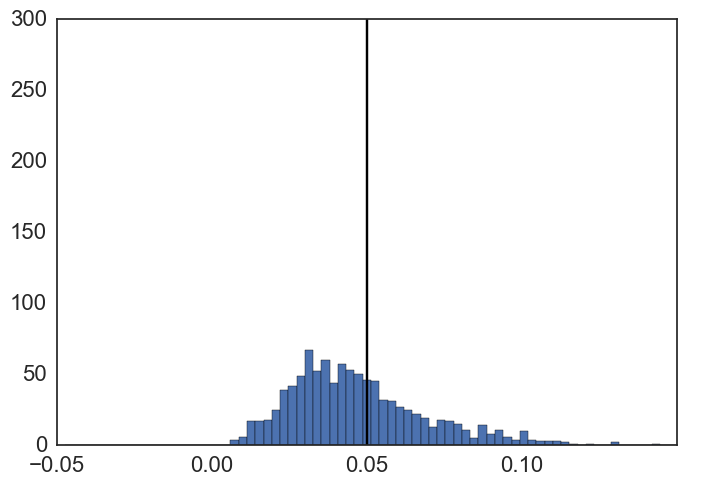

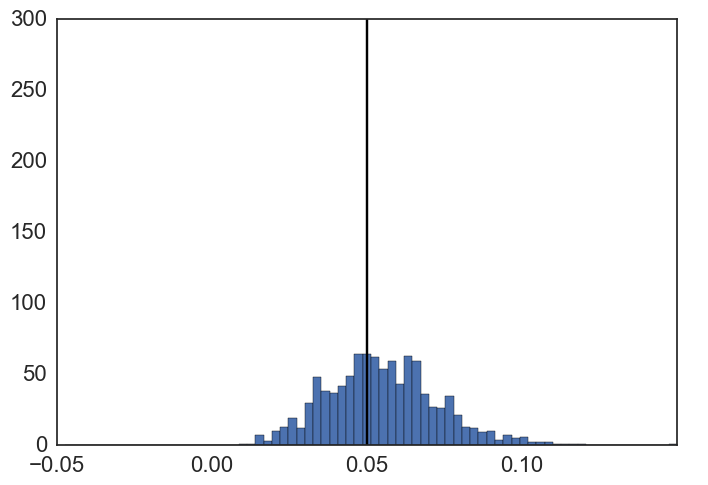

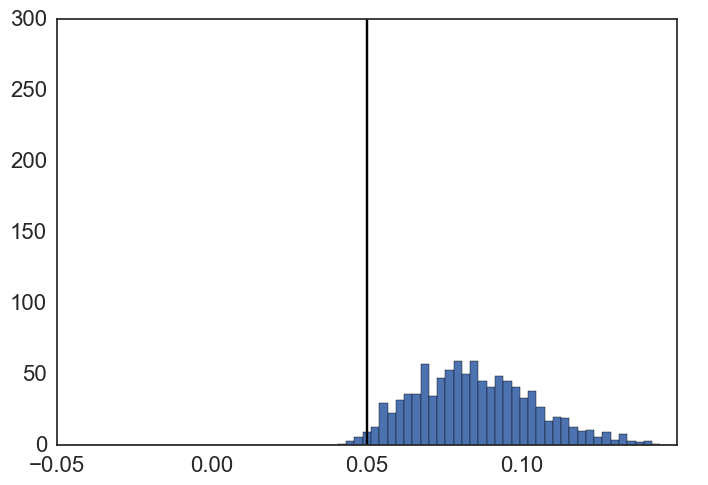

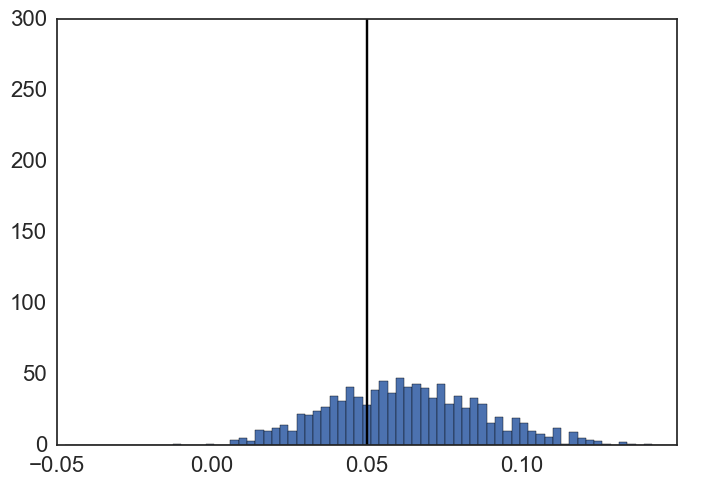

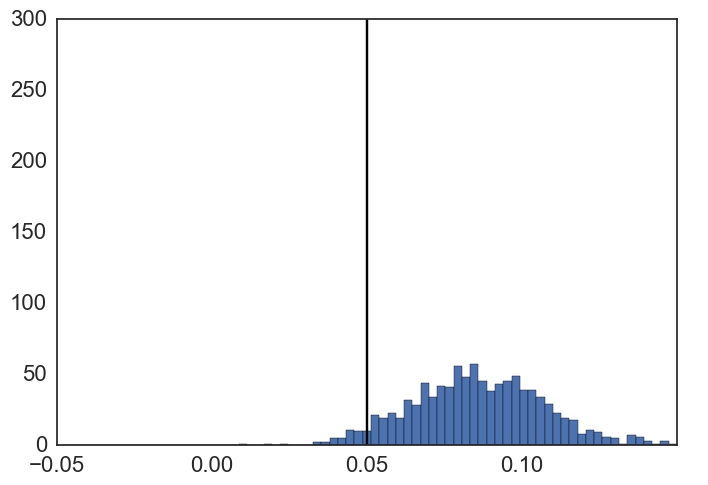

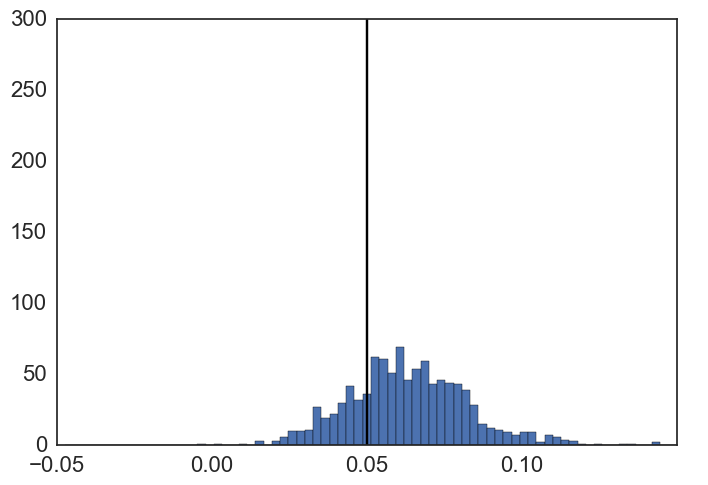

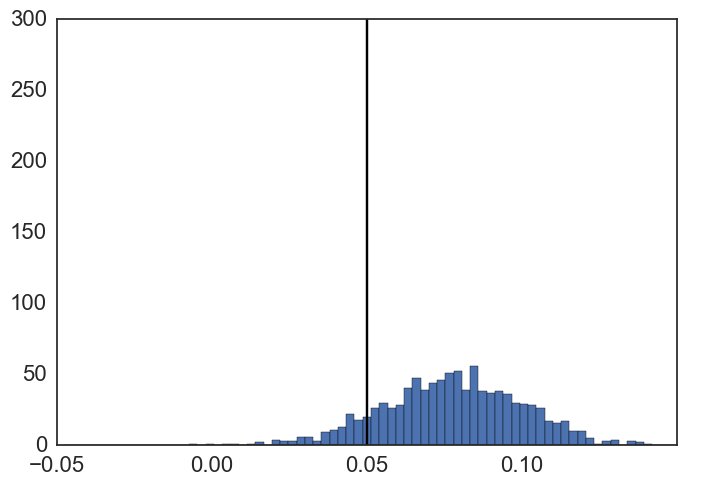

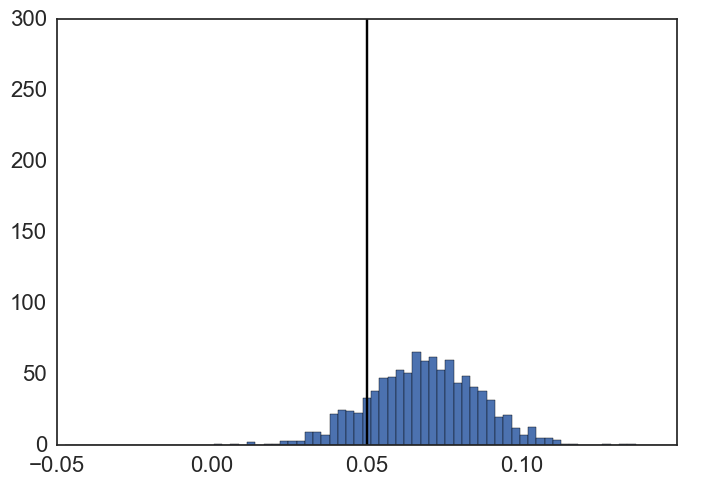

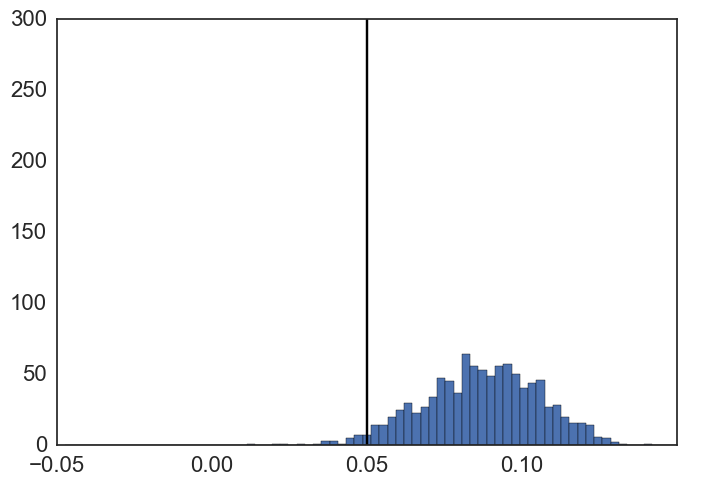

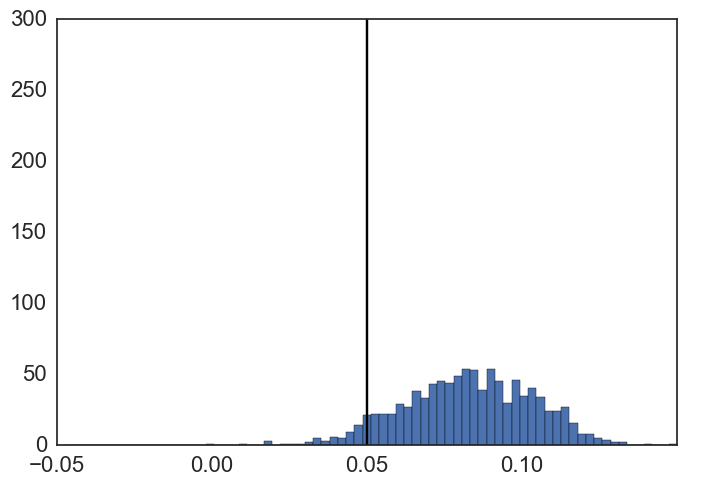

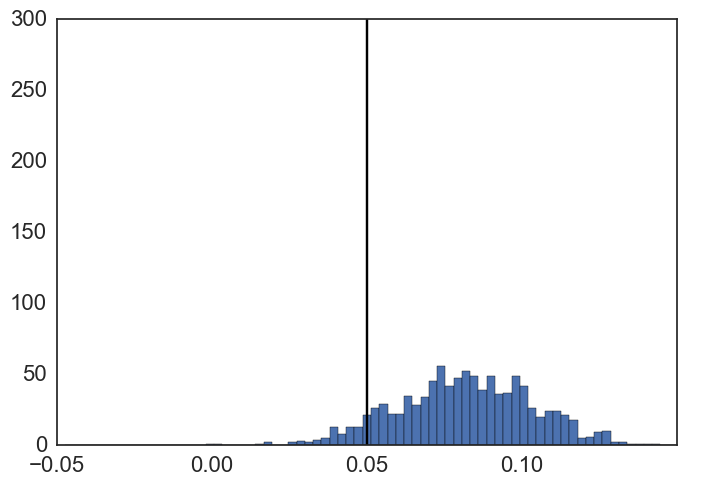

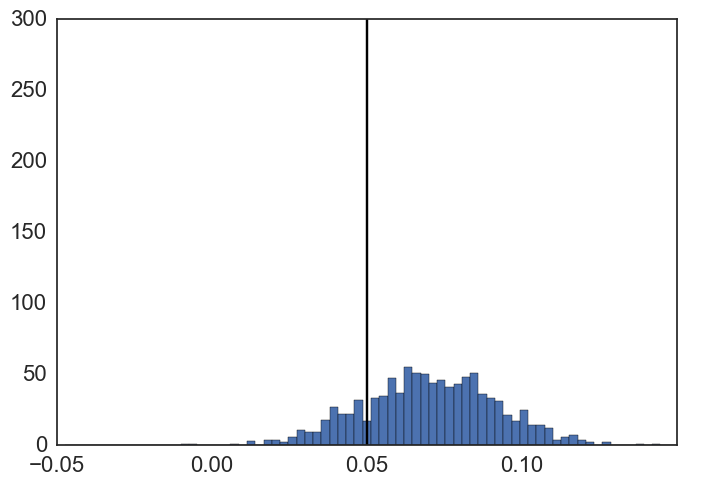

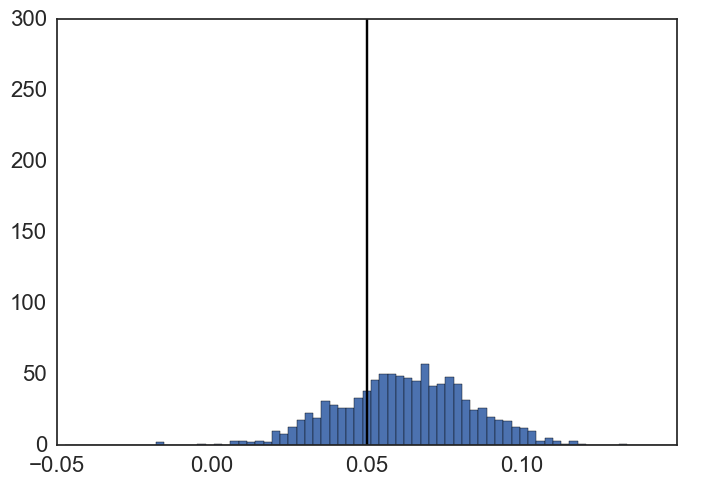

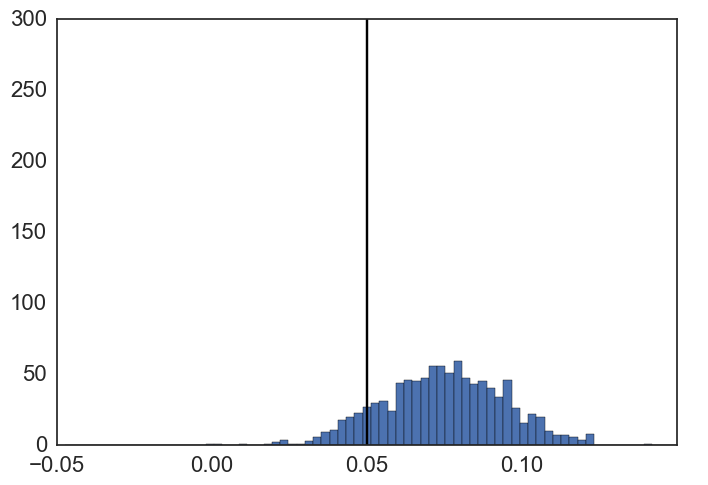

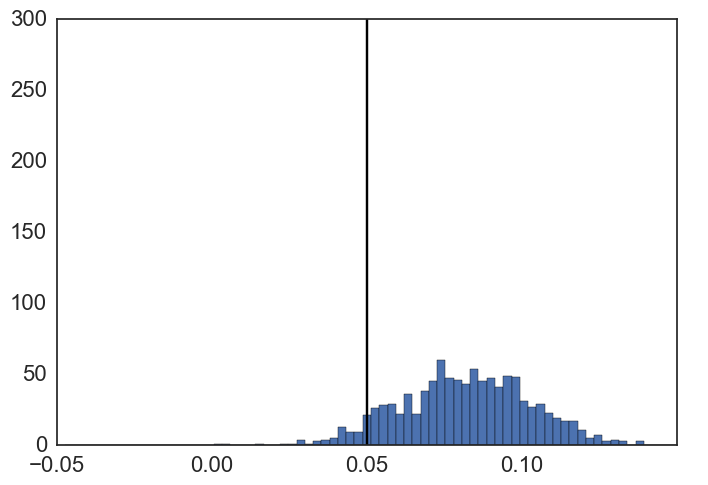

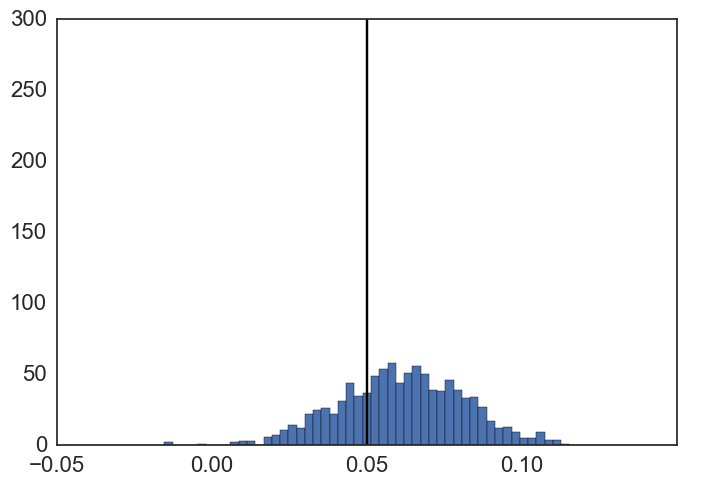

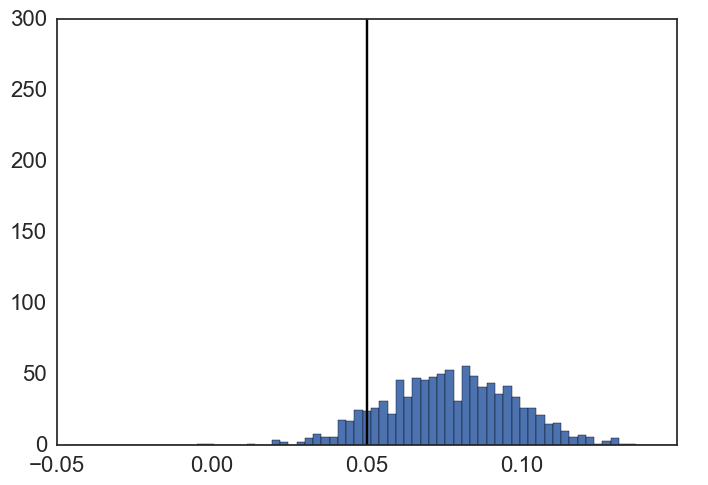

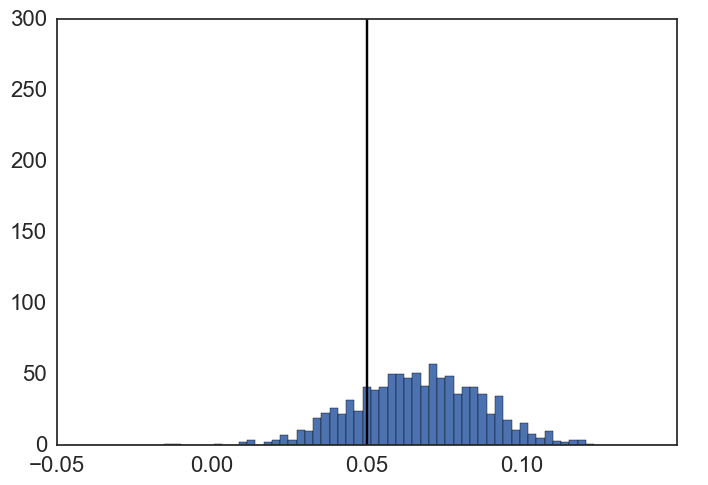

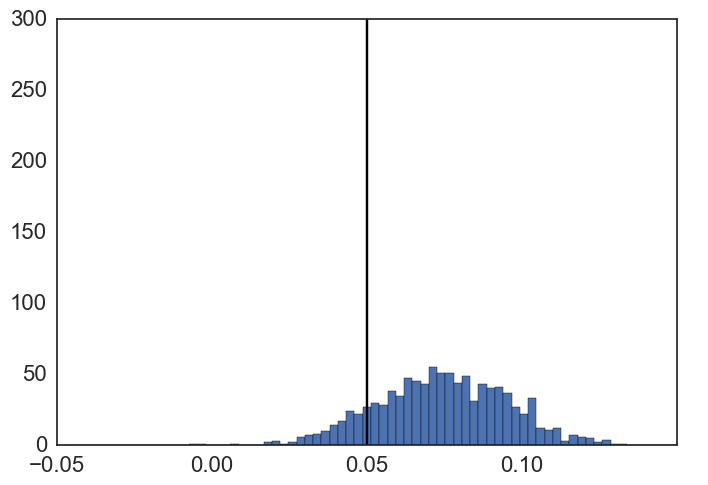

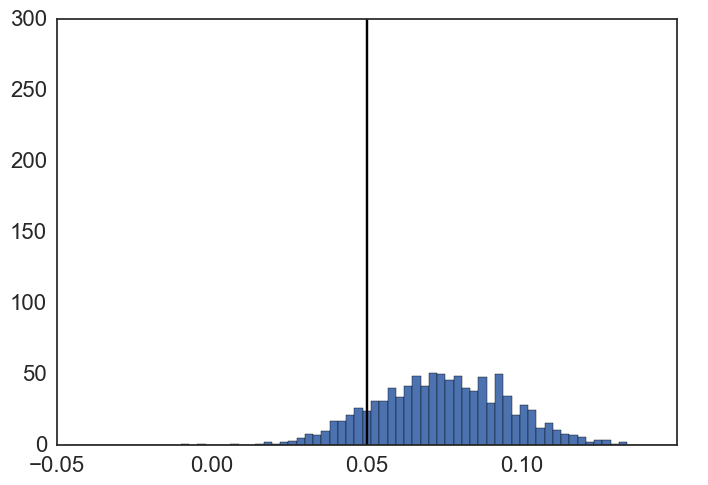

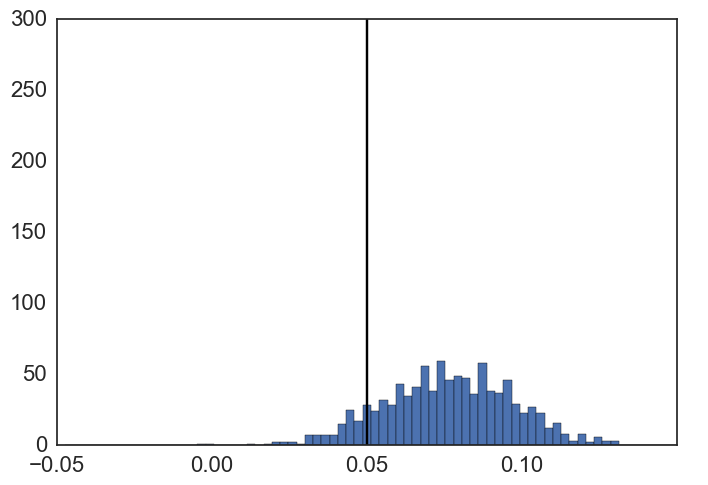

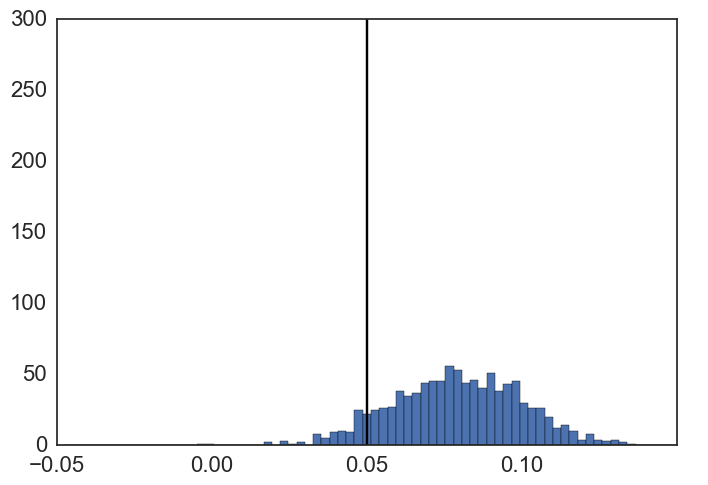

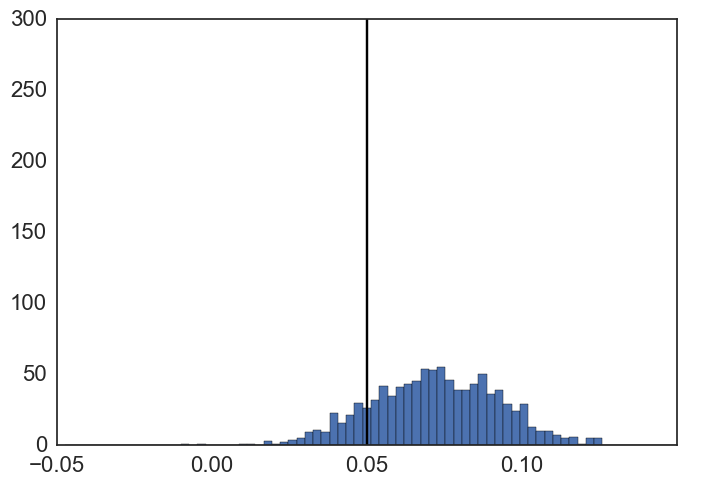

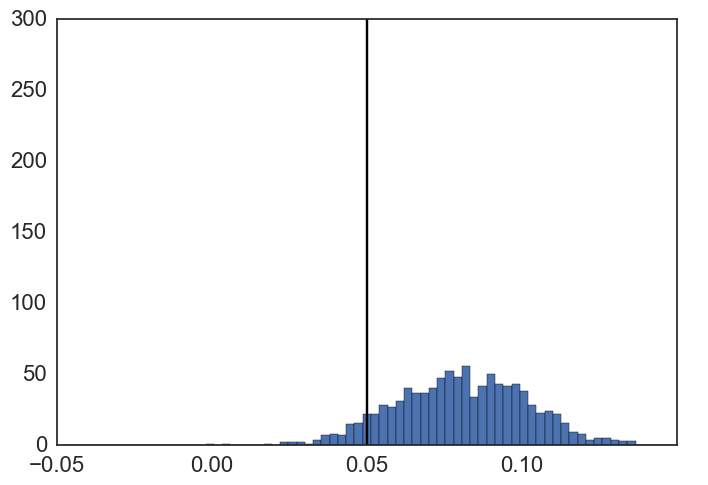

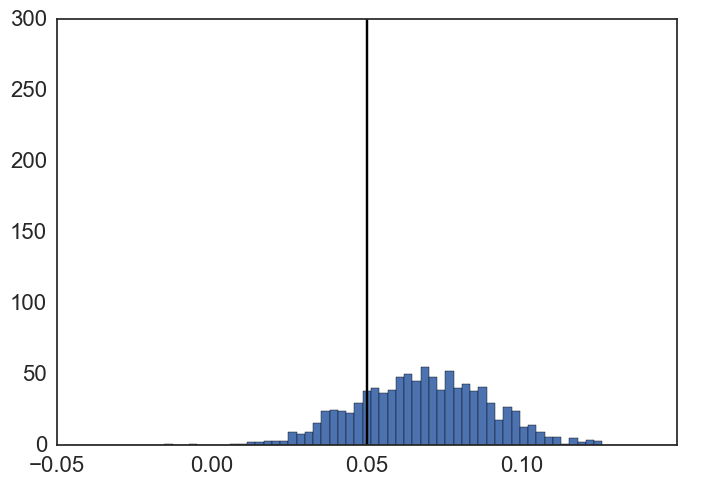

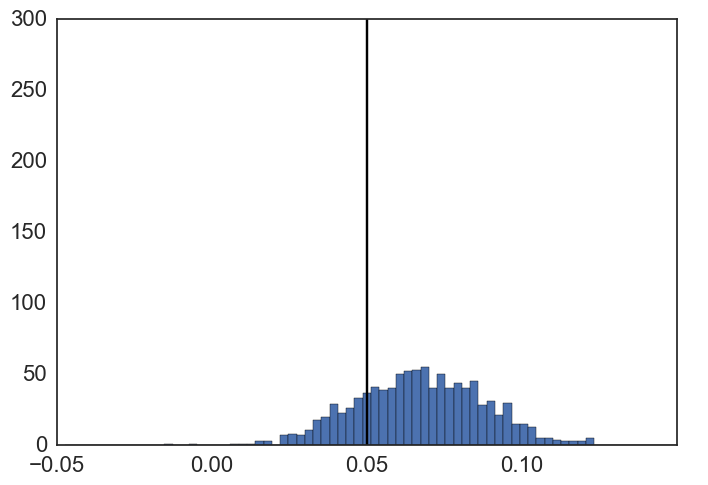

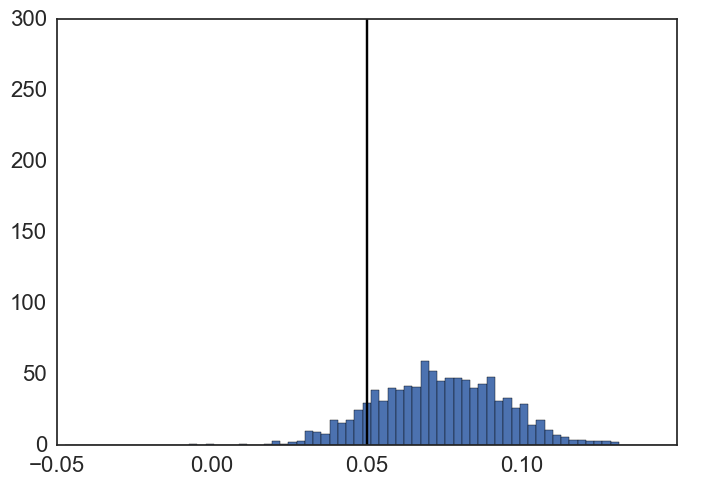

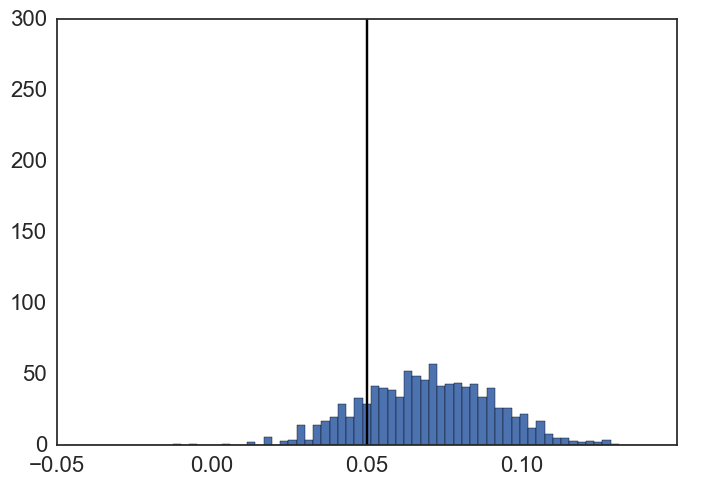

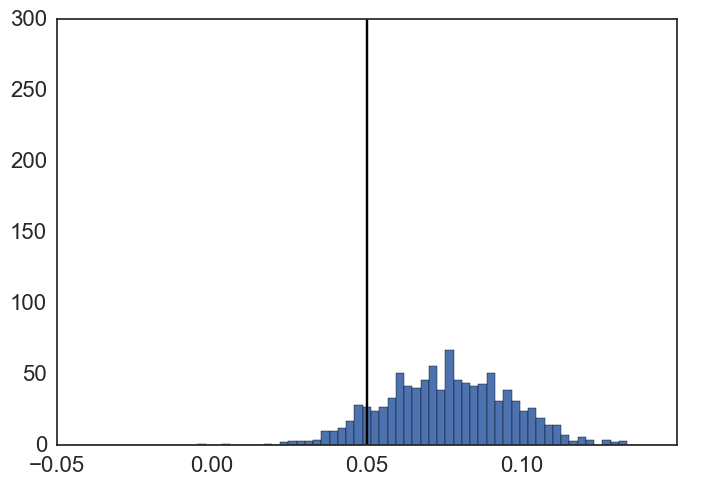

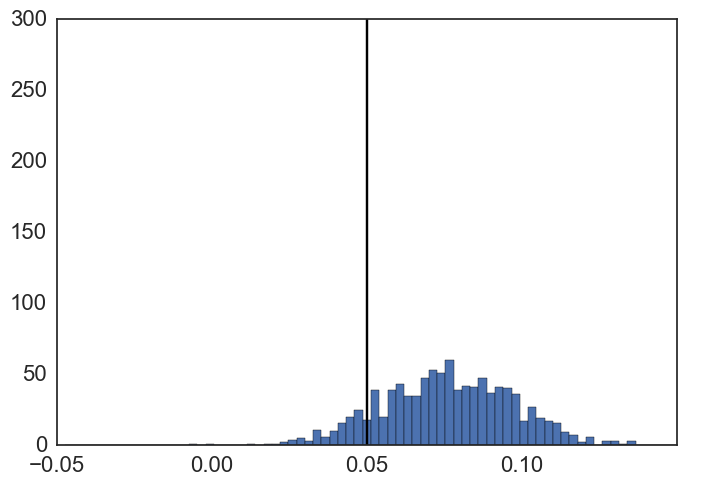

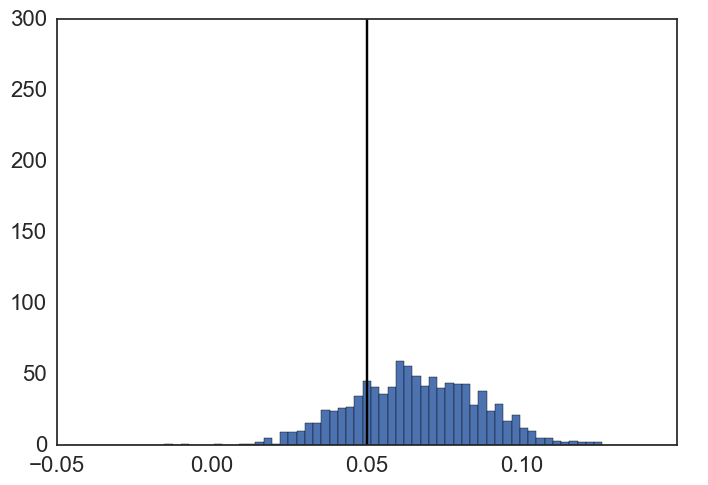

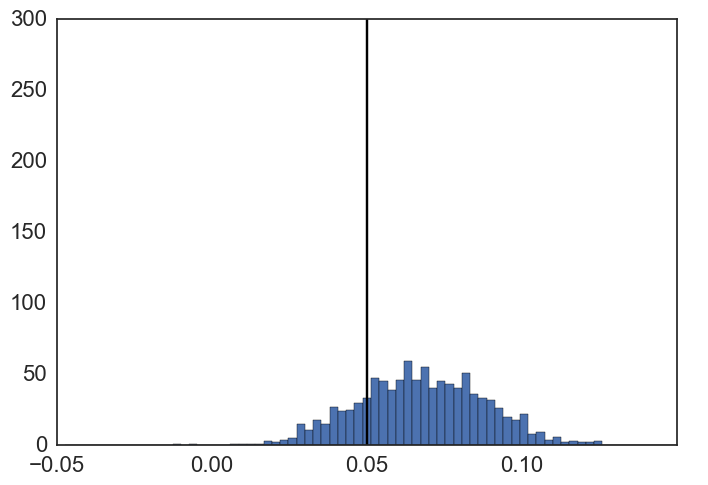

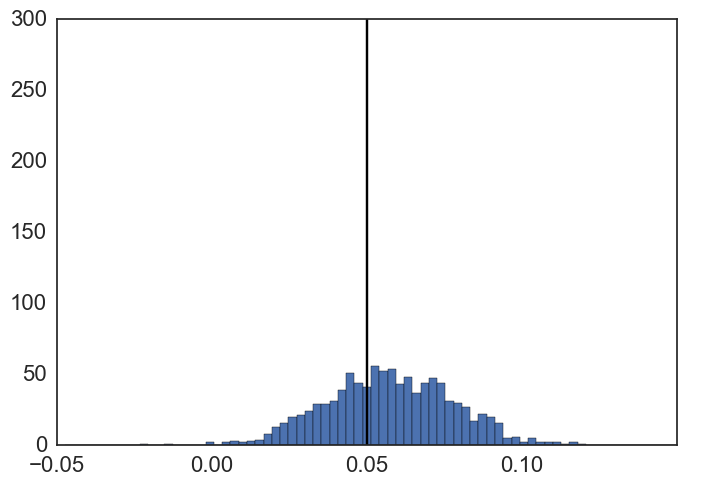

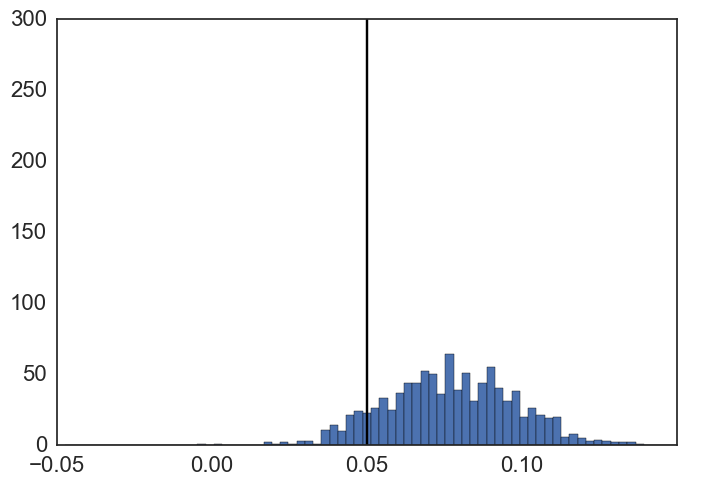

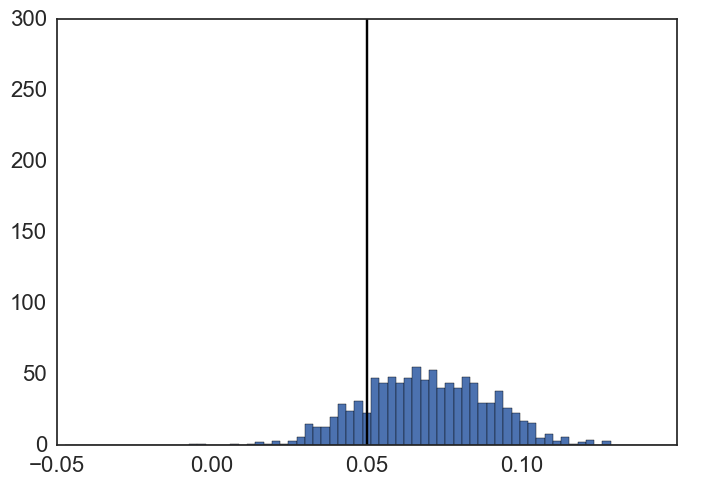

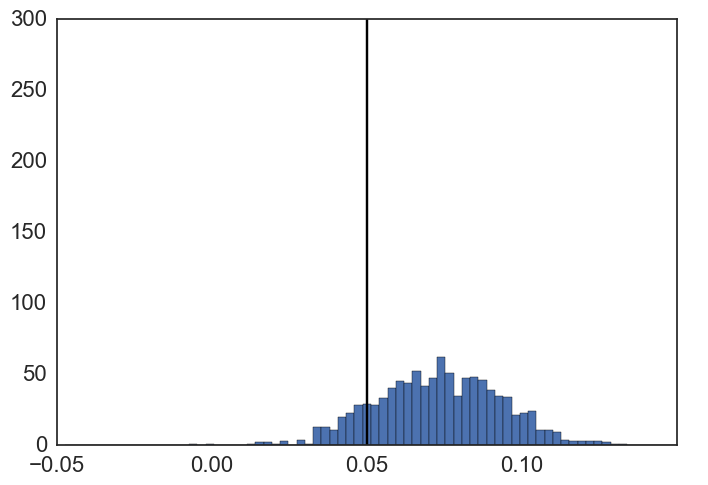

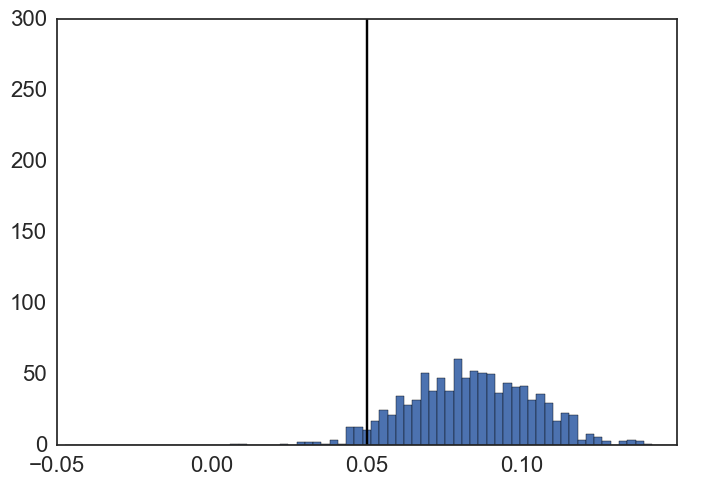

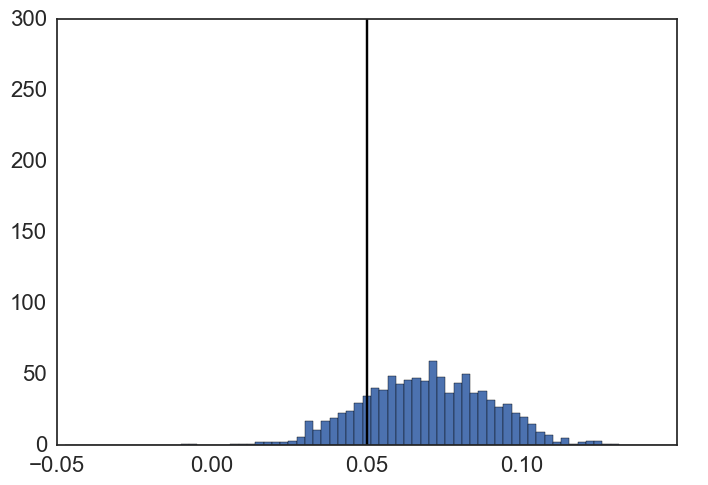

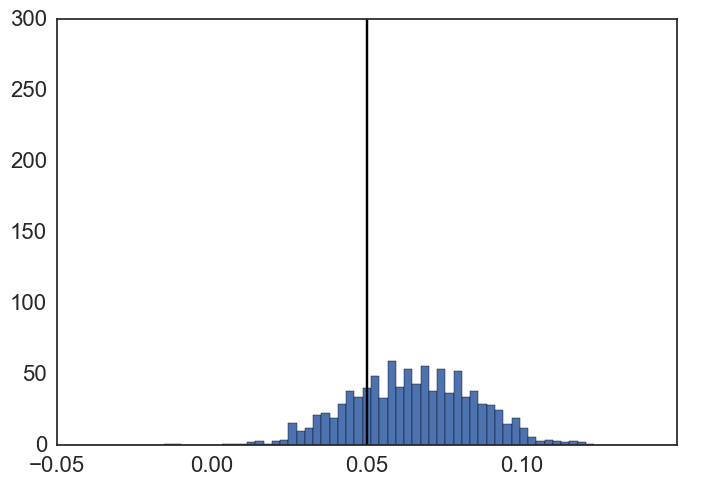

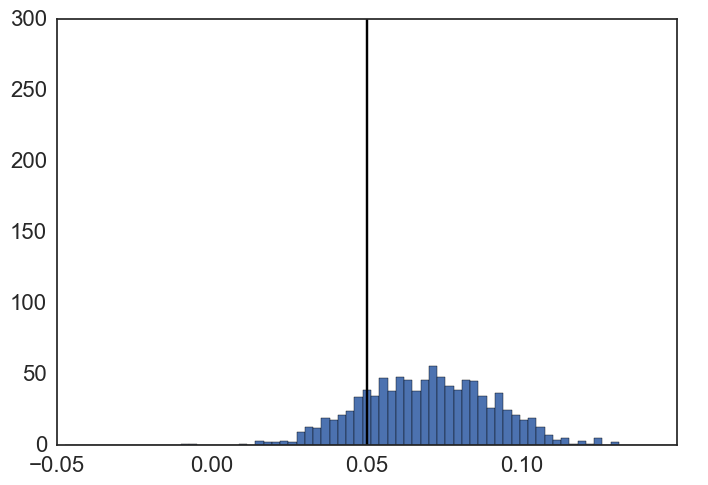

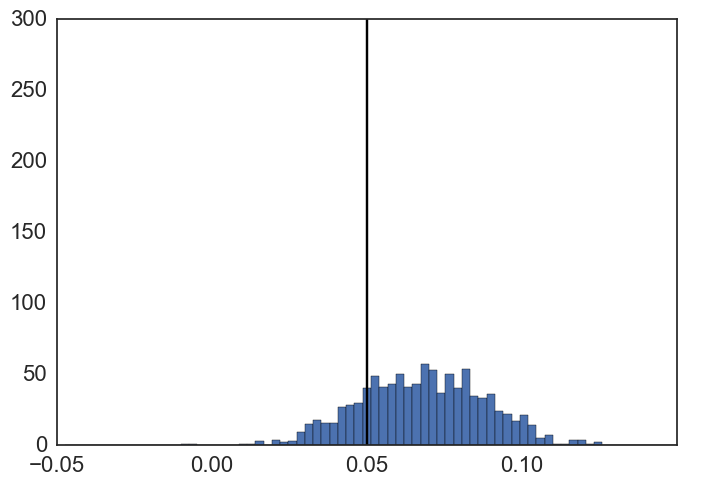

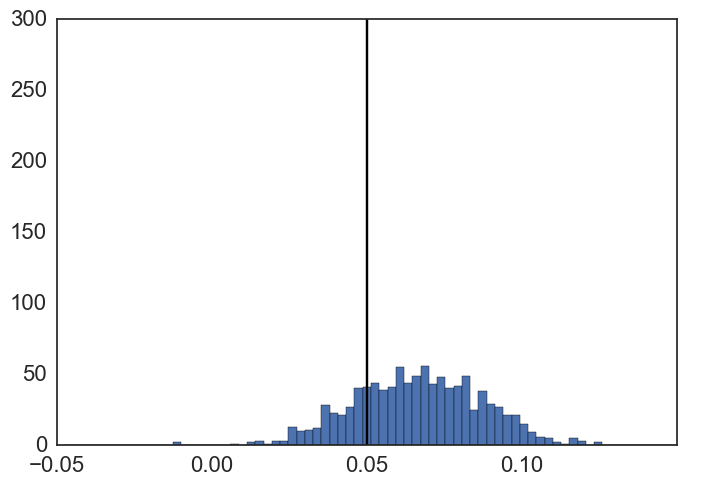

In [9]:
i = 0
for prediction_elu in covnet_mo_elu_predictions:
    i=i+1
    print(i)
    predictions_hist(np.reshape(prediction_elu[3], len(prediction_elu[3])), test_set_model_params().jumps_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps_Mu",
                 min_edge = -0.05,
                 max_edge = 0.15,
                 img_subdir = "Animations/Multiple_Output/Jumps_Mu/"+str(i),
                 y_lim = (0, 300));

1


/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/Users/Rayno/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


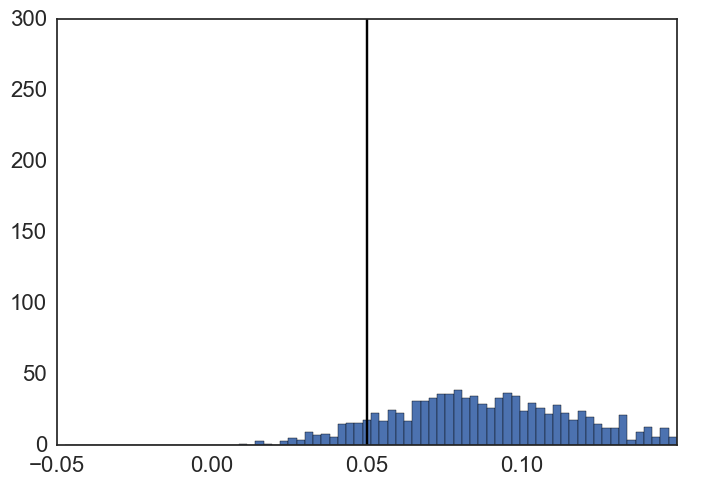

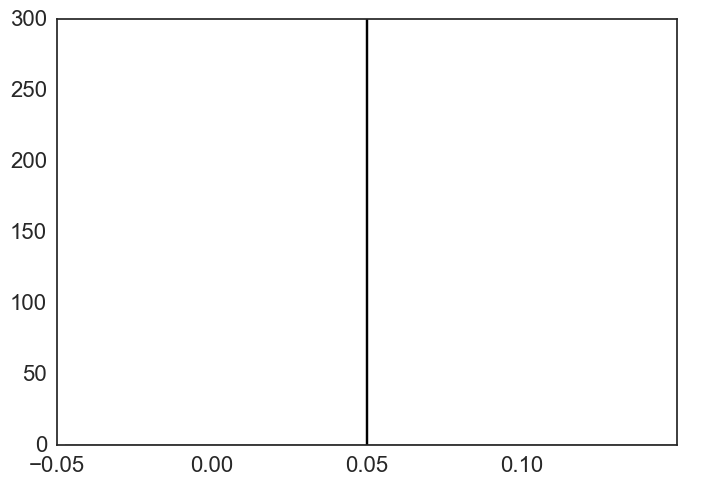

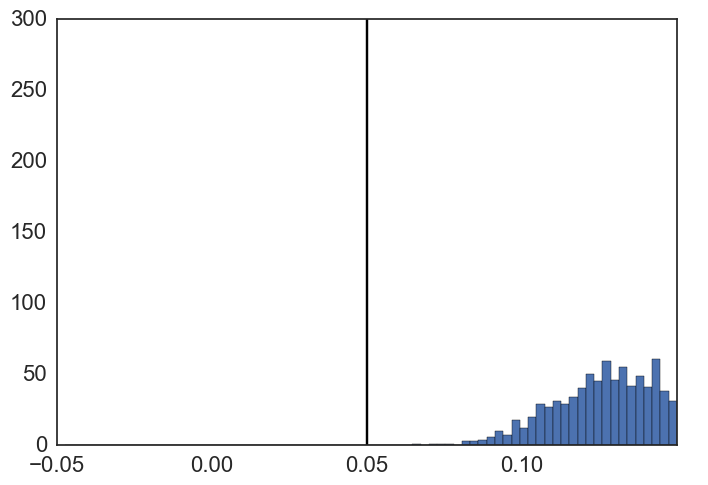

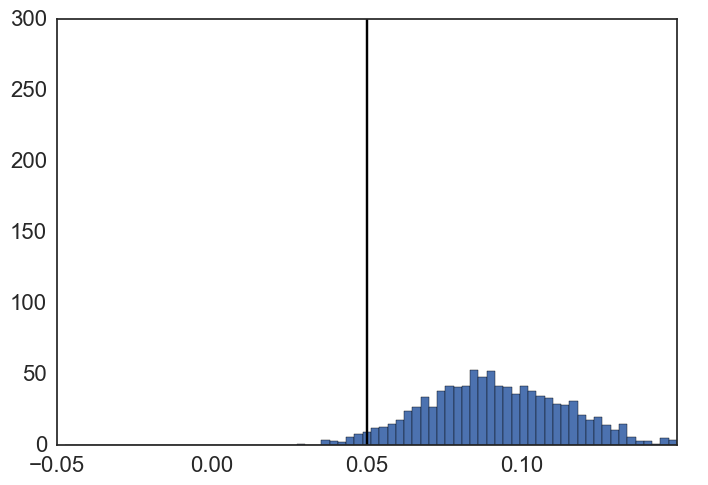

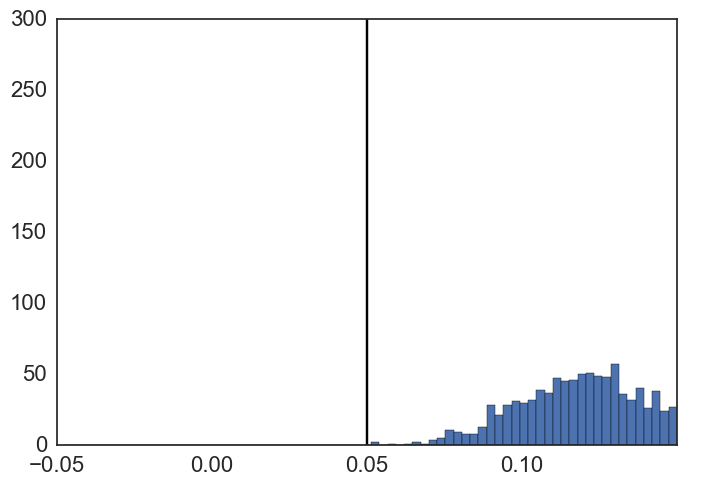

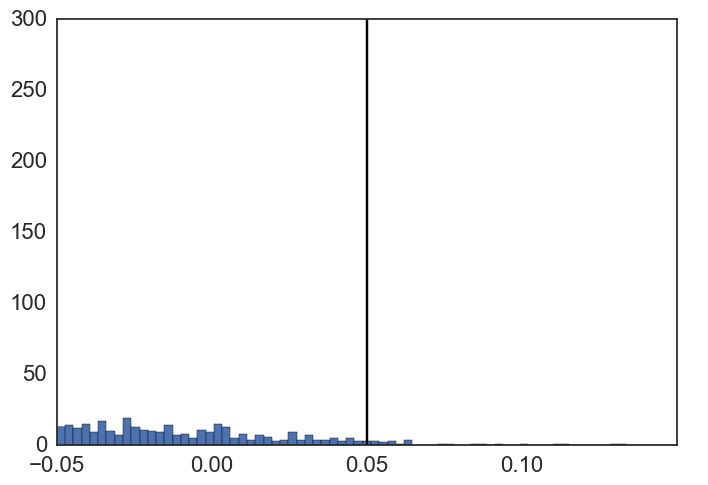

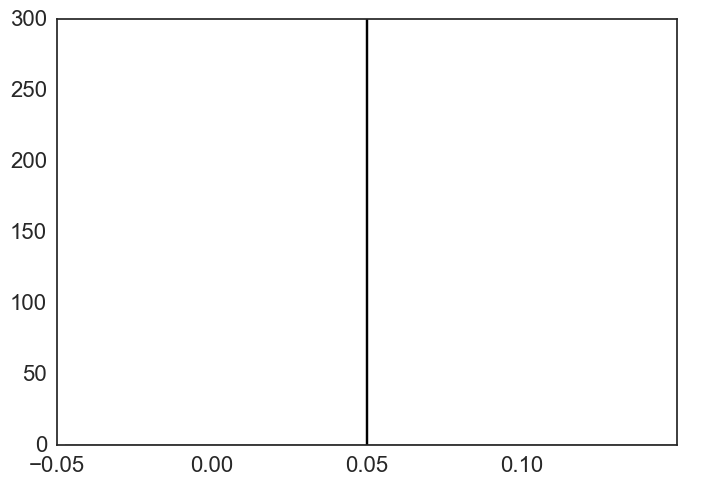

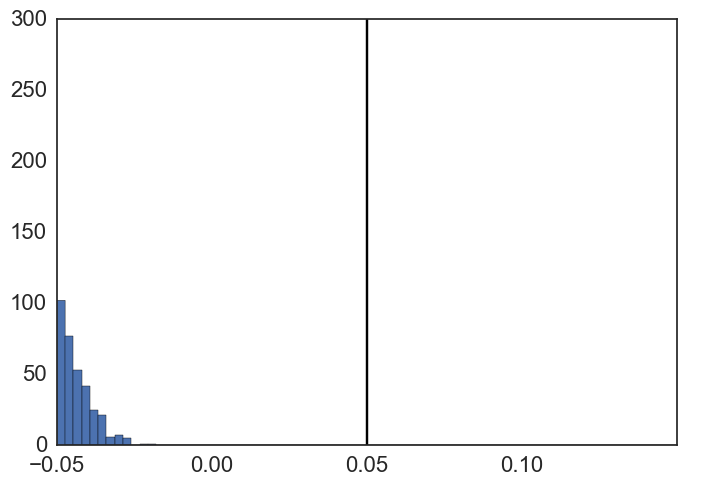

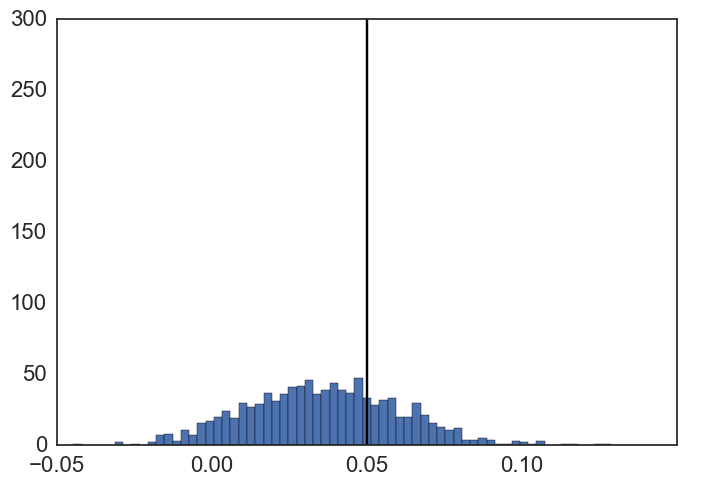

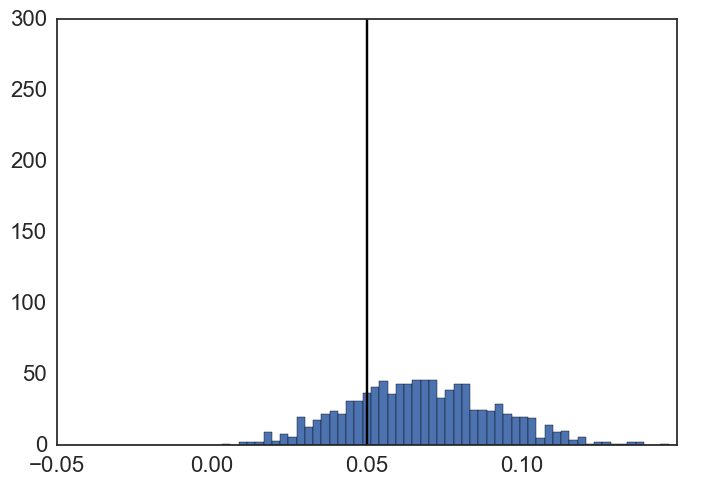

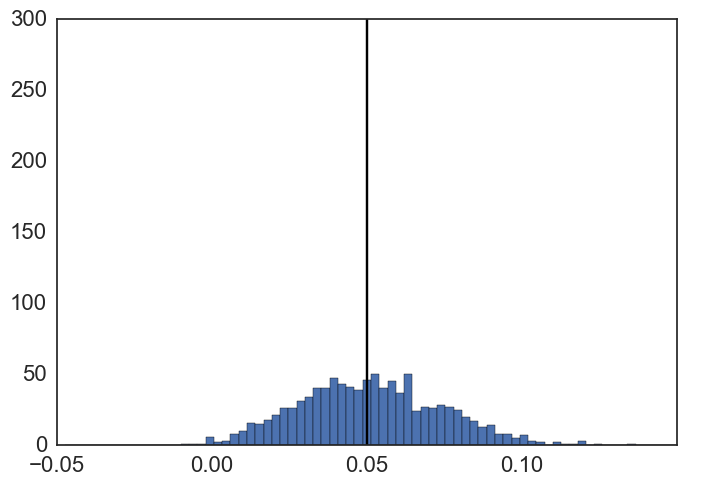

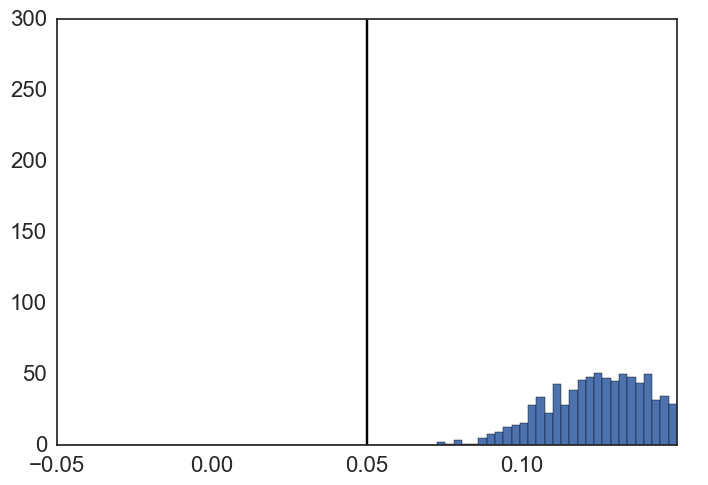

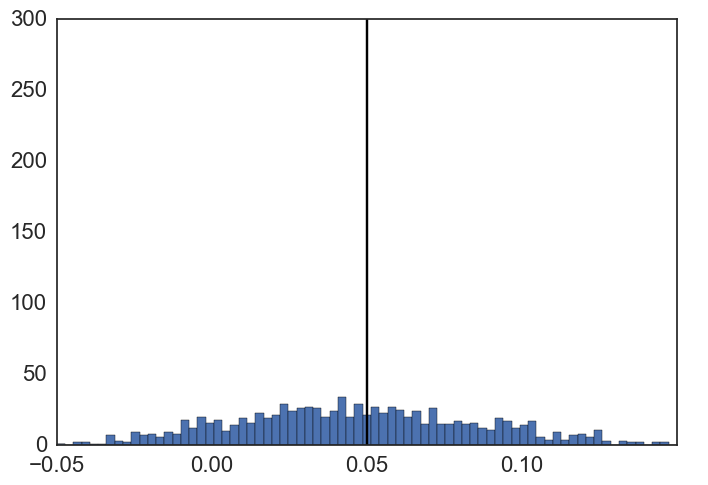

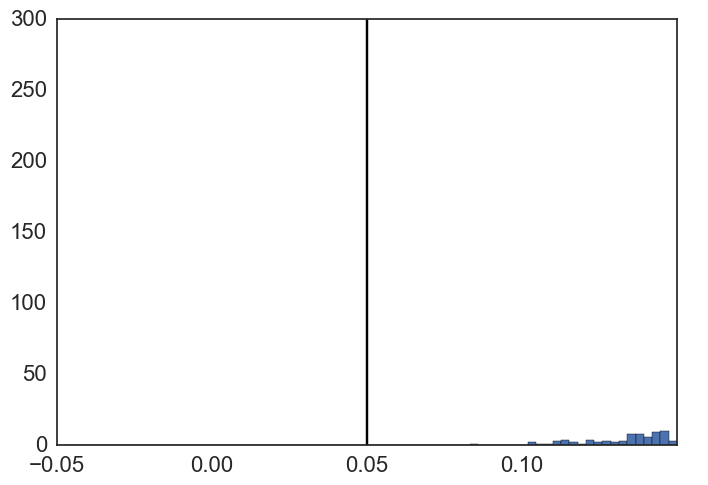

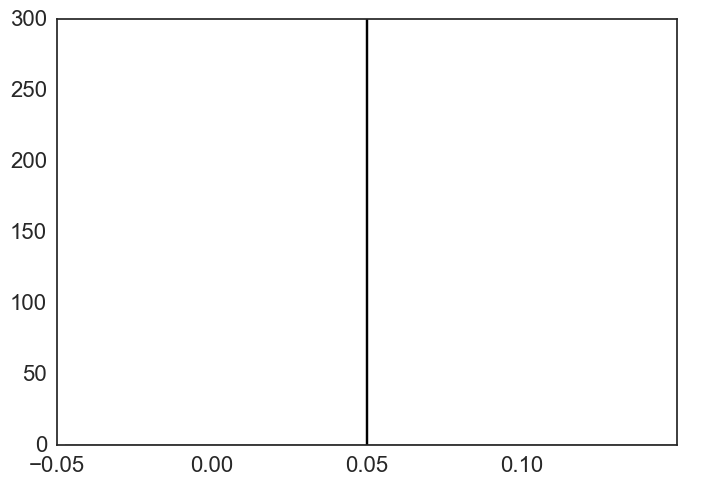

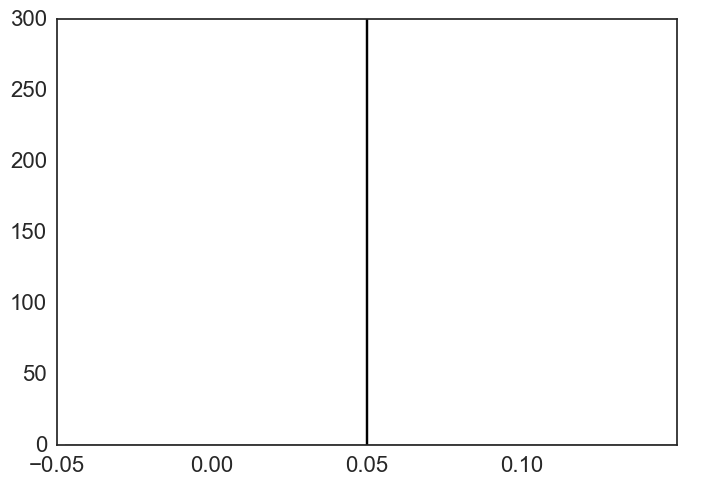

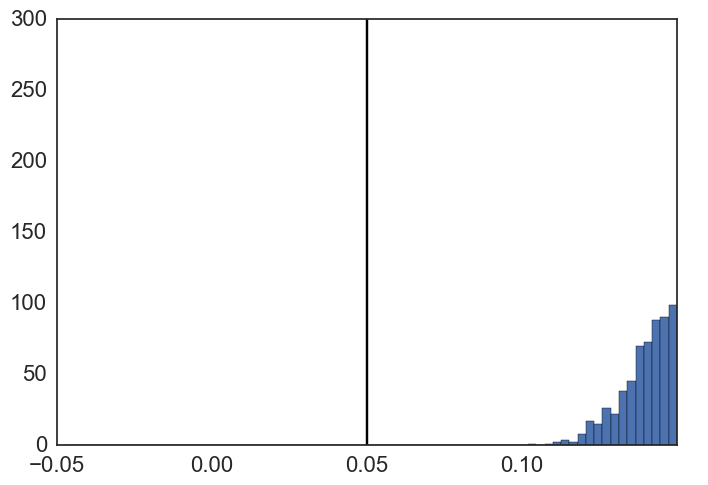

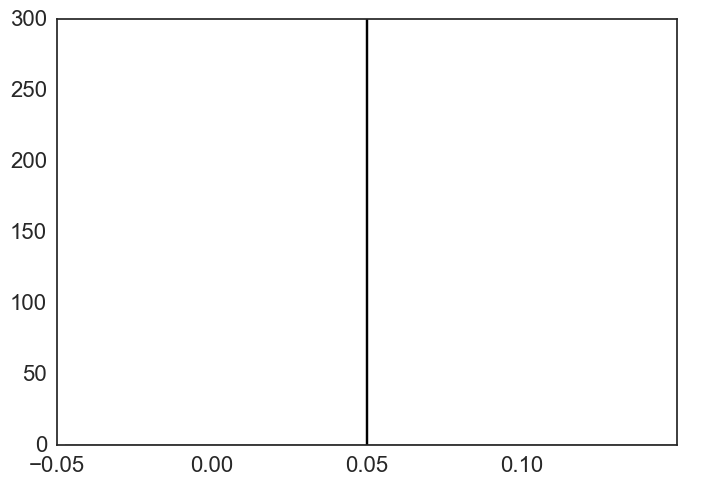

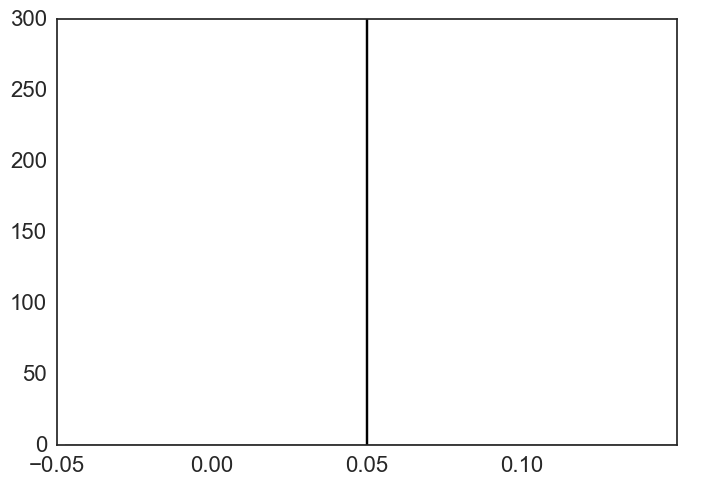

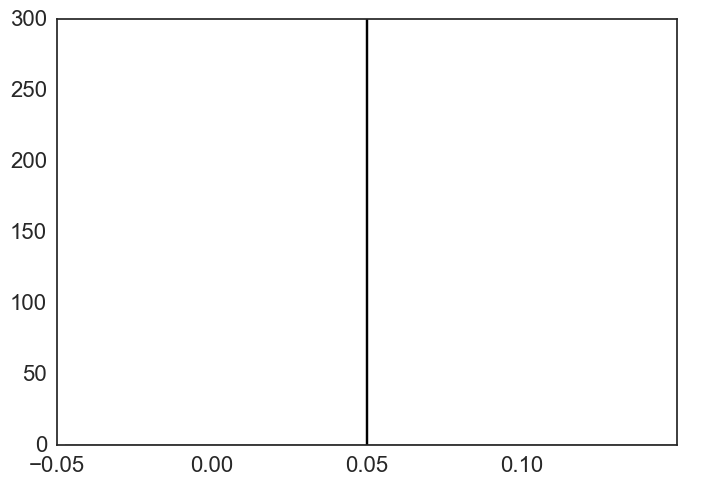

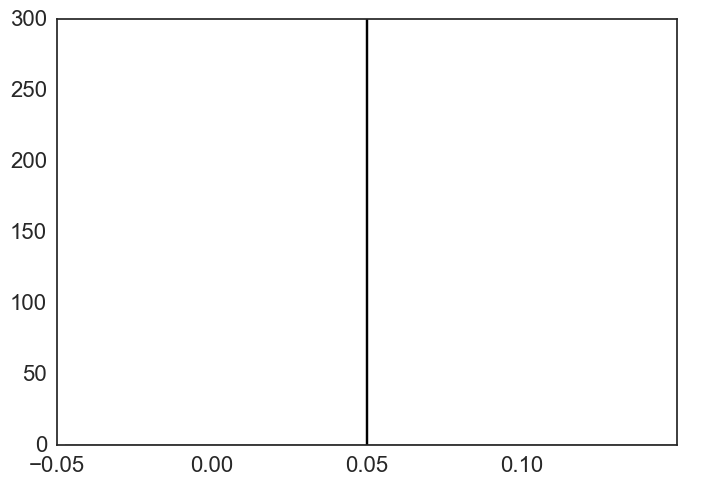

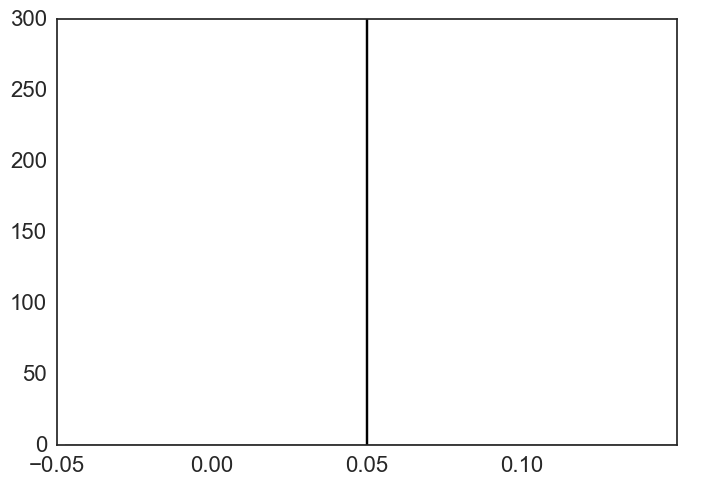

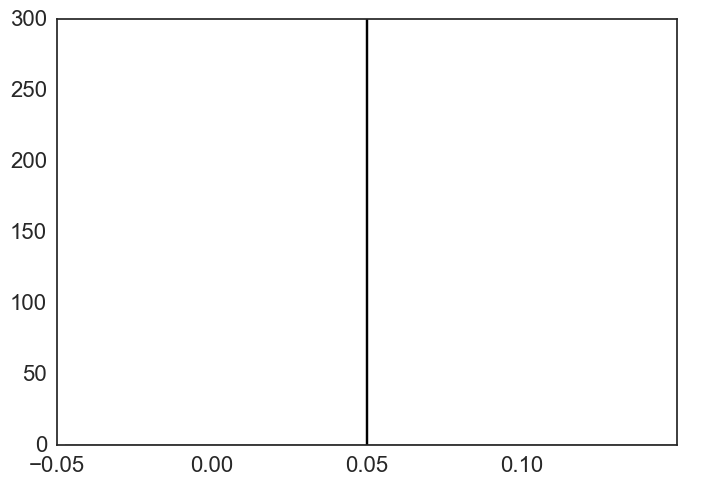

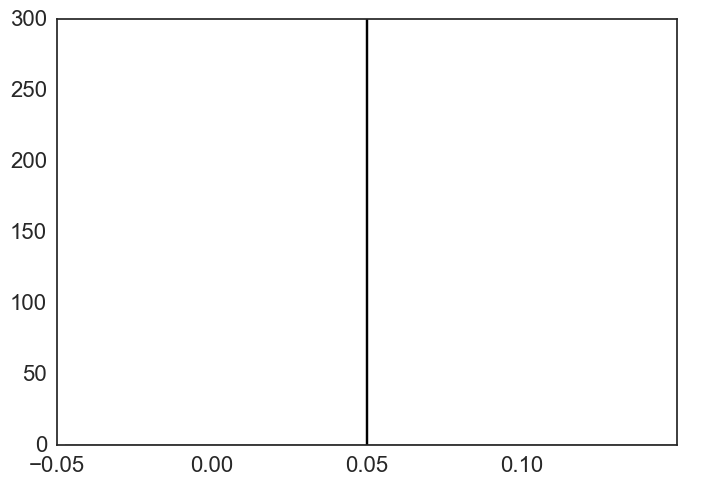

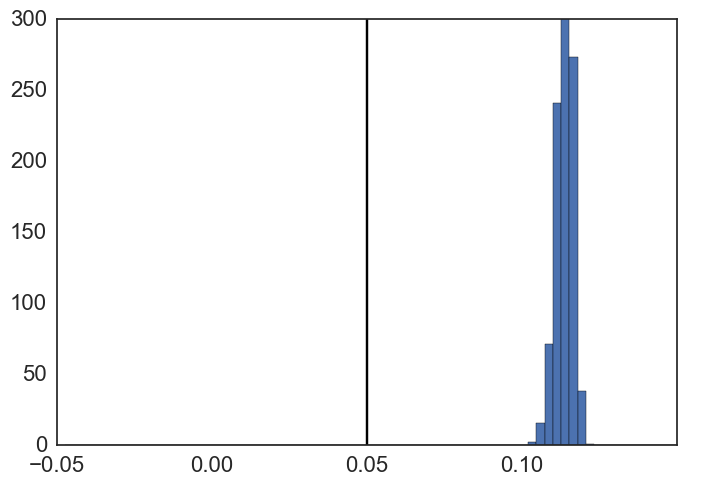

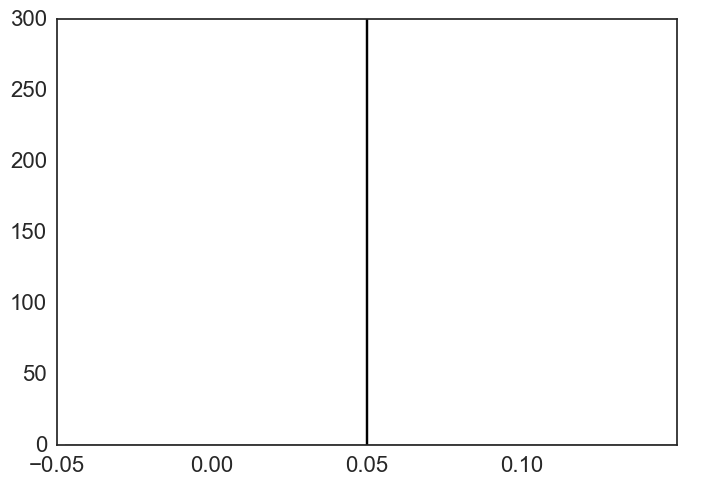

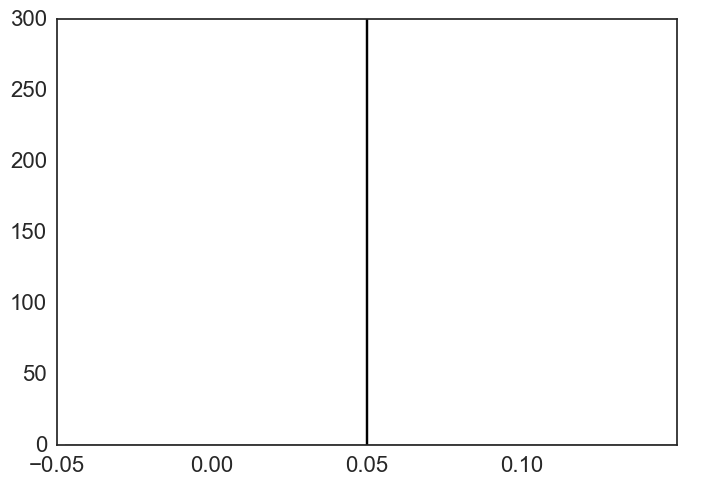

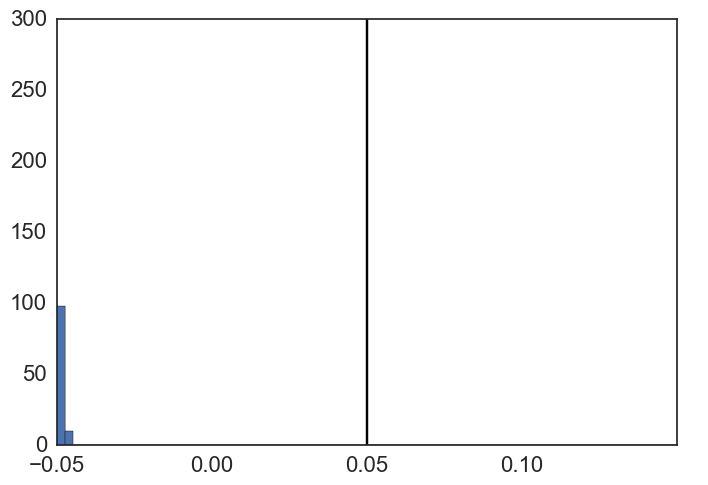

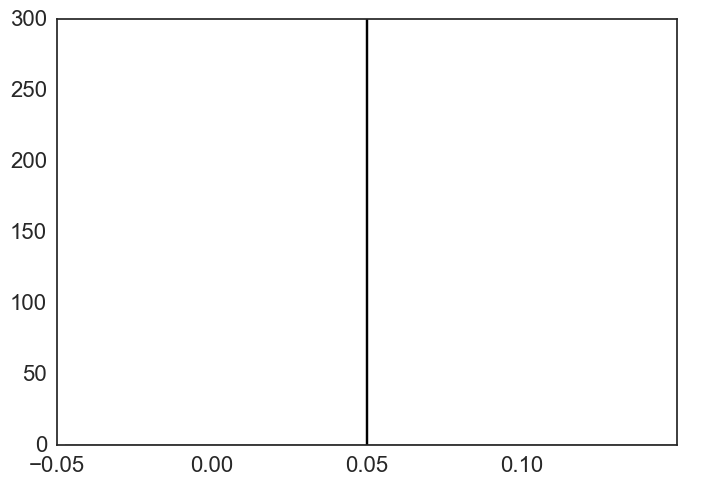

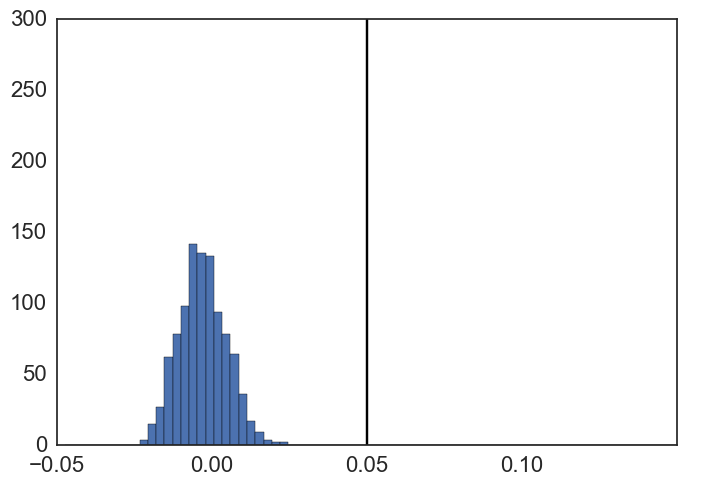

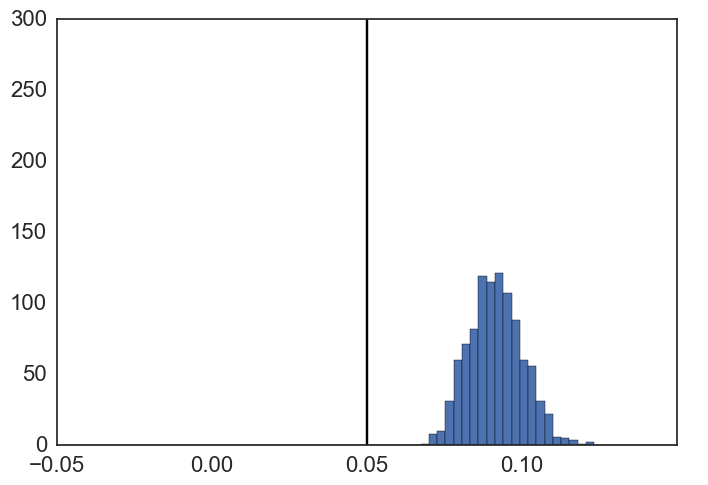

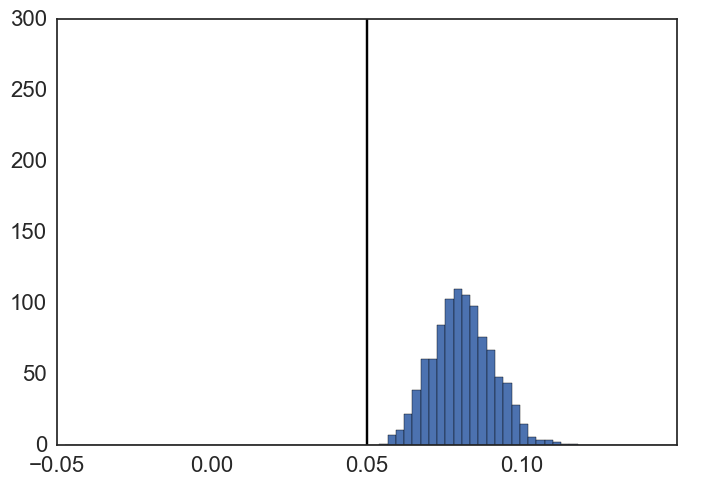

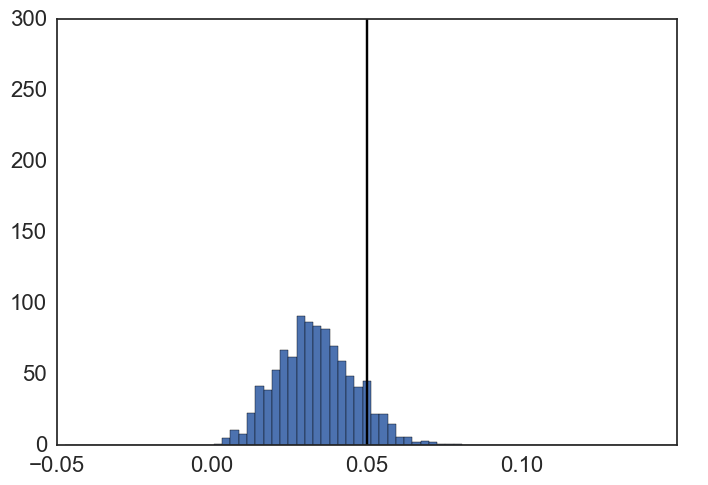

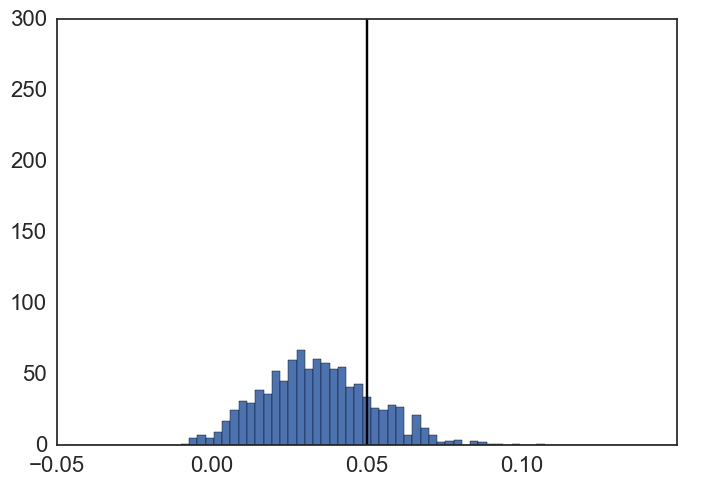

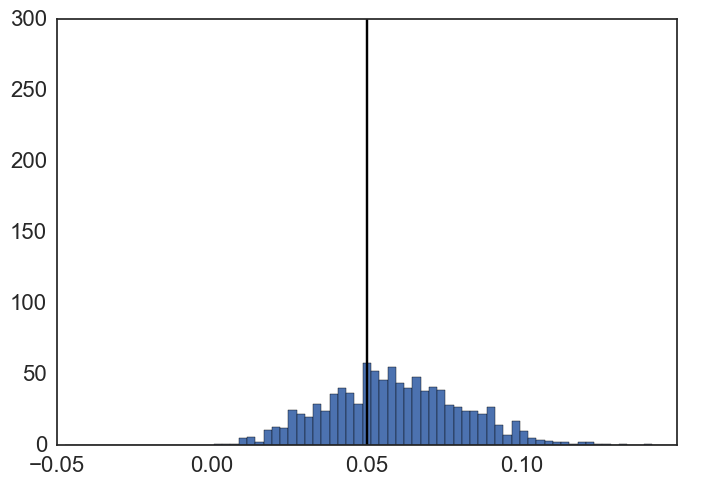

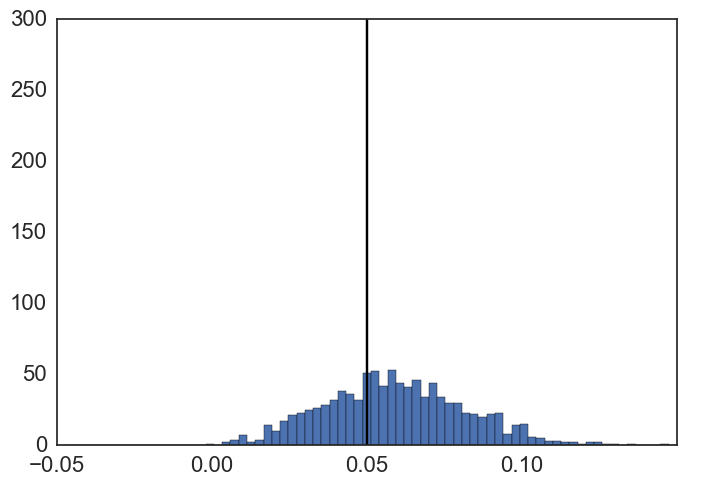

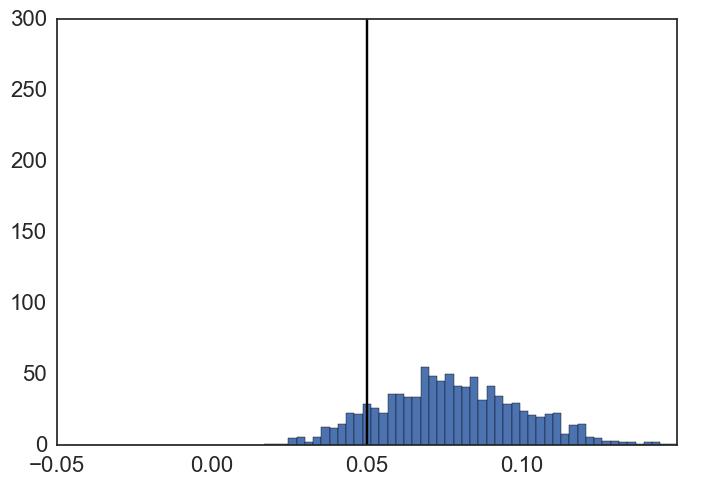

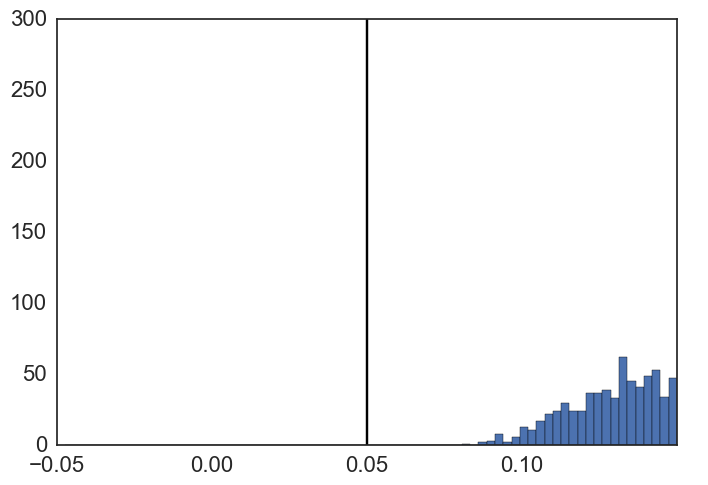

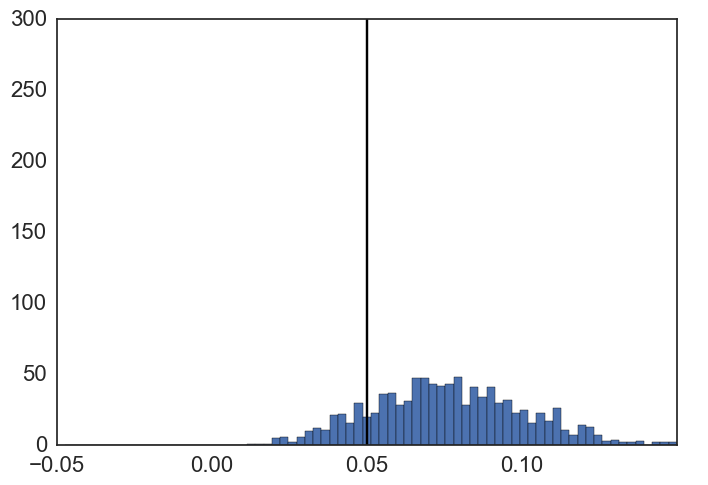

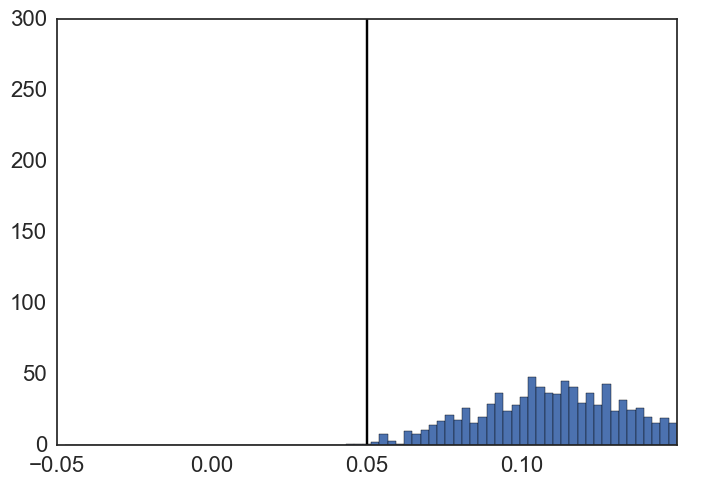

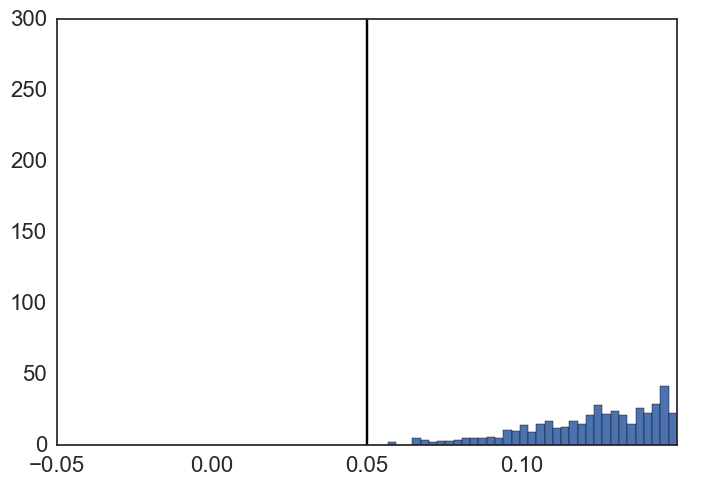

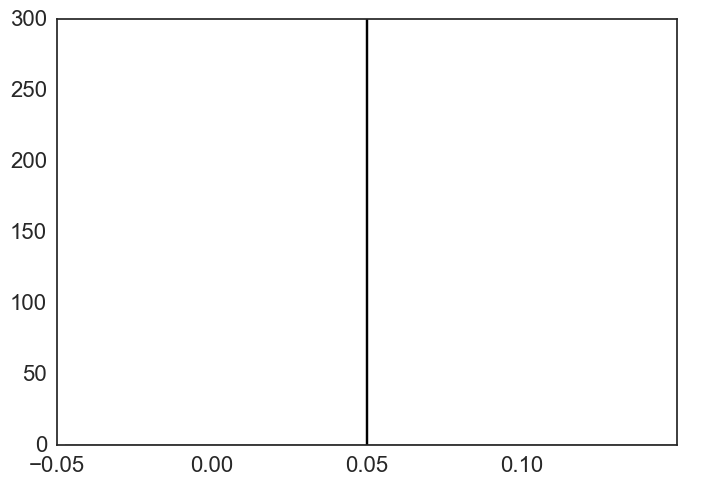

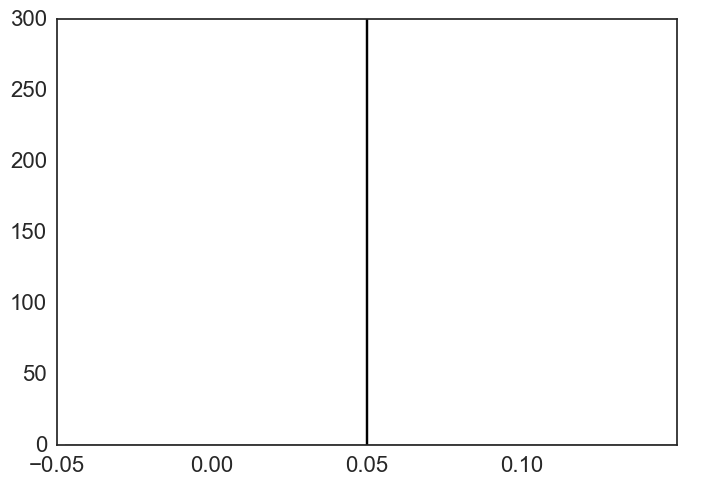

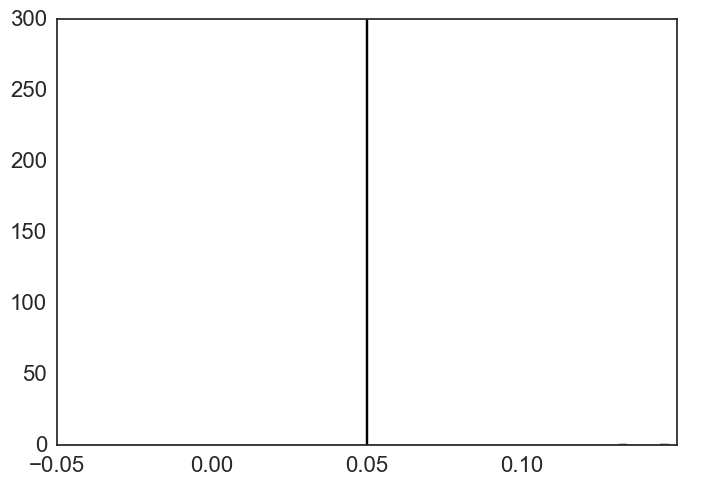

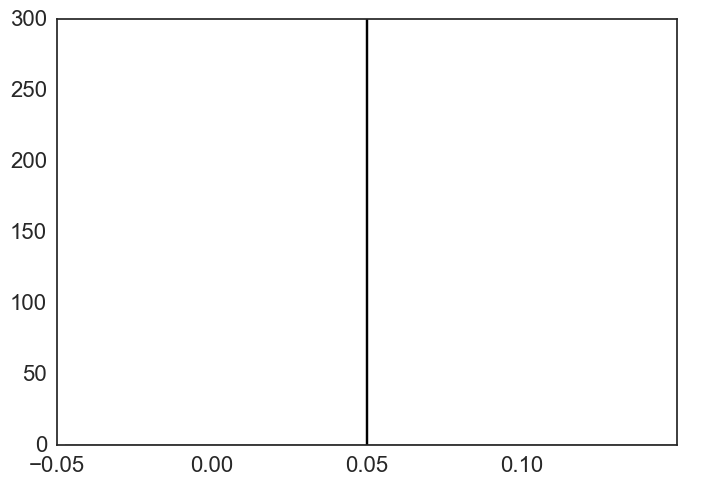

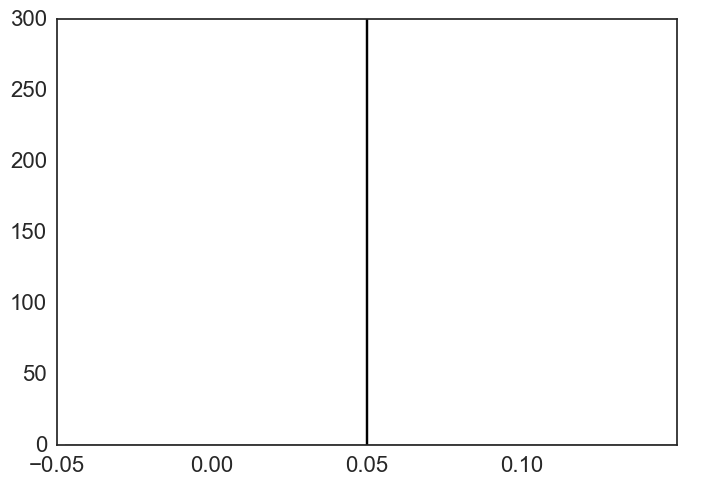

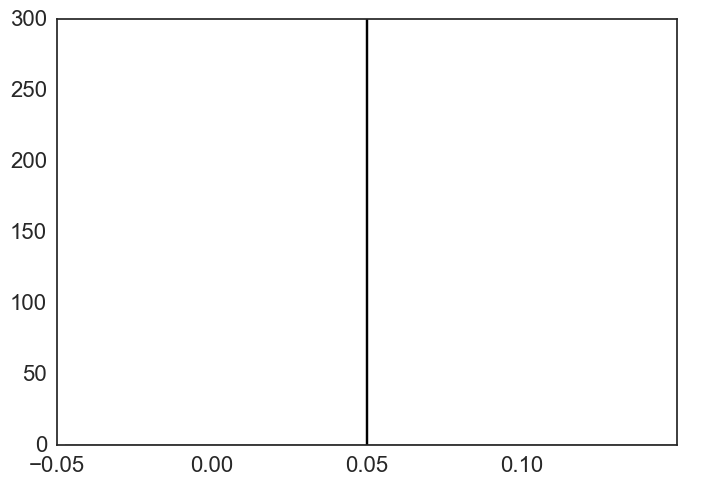

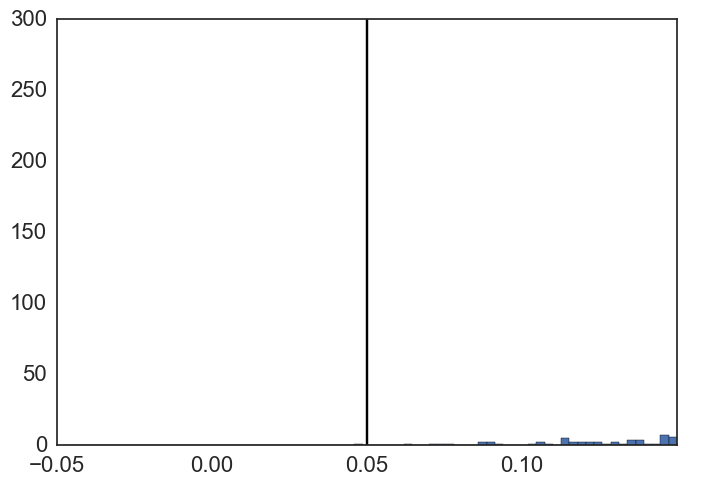

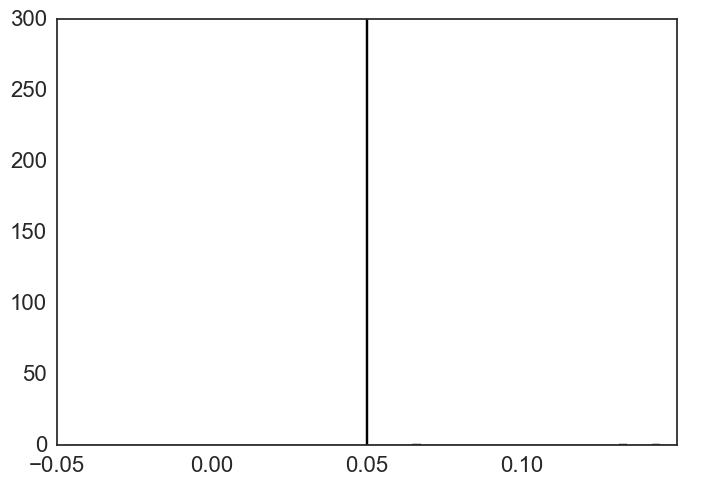

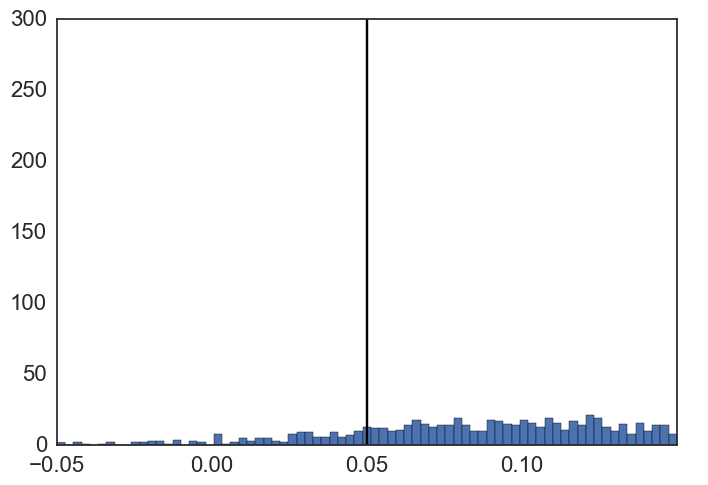

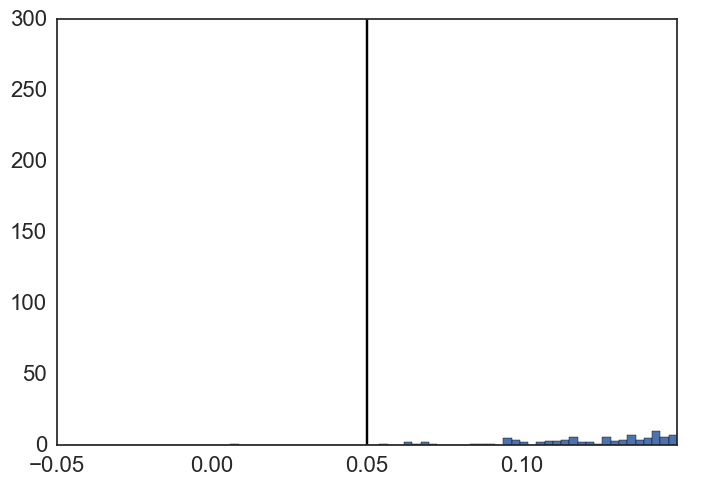

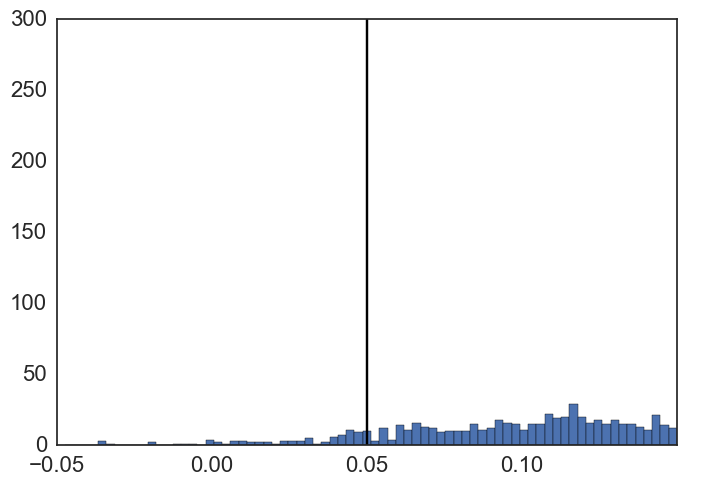

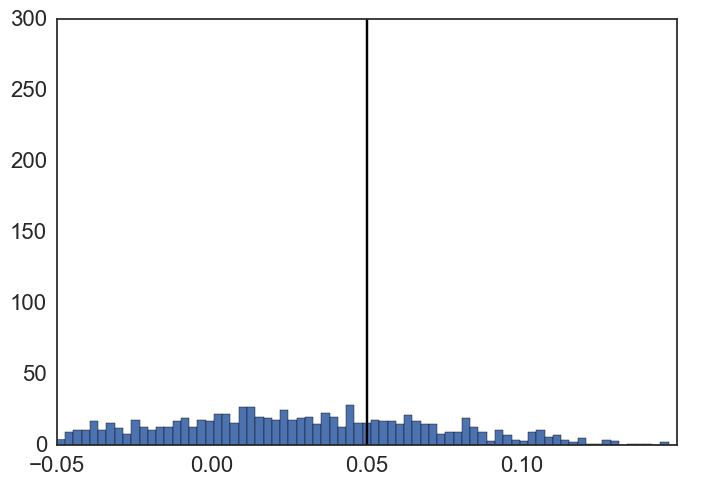

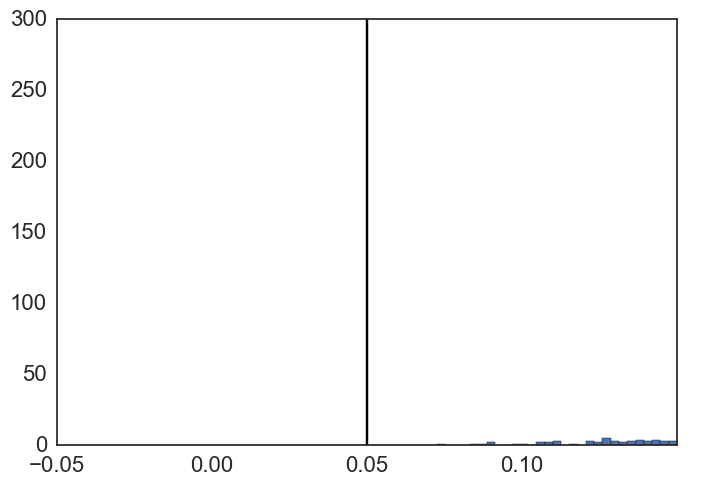

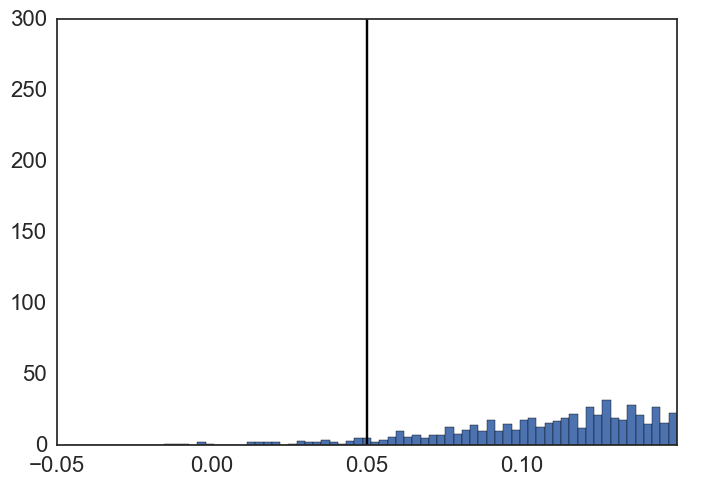

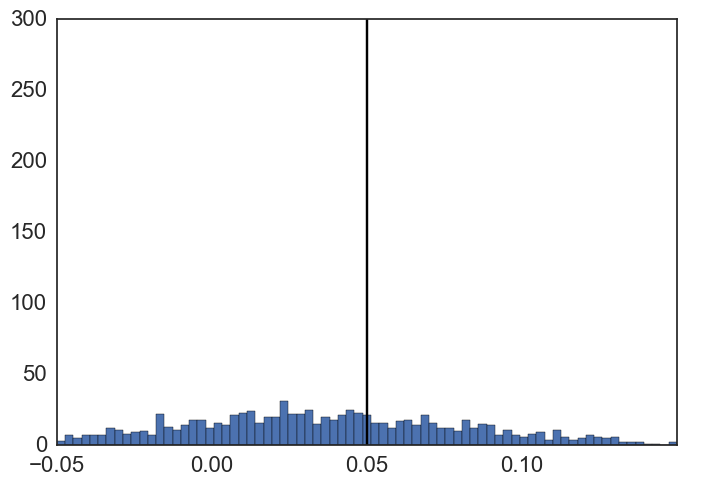

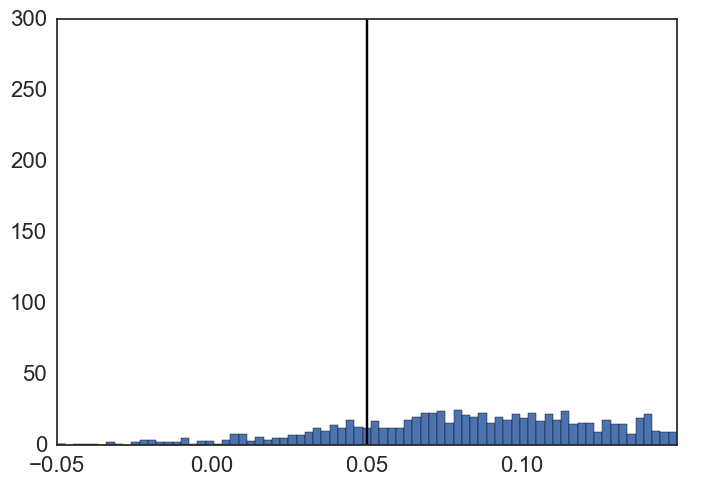

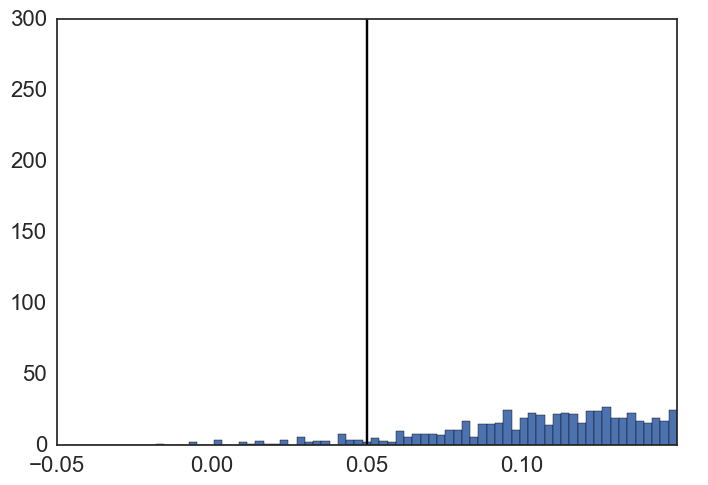

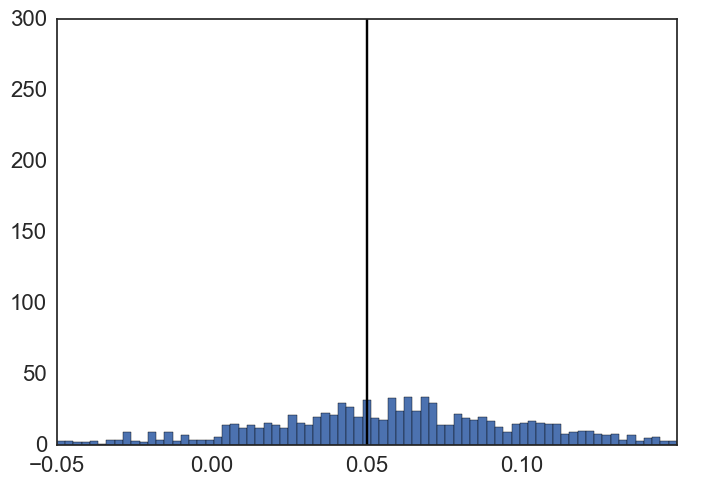

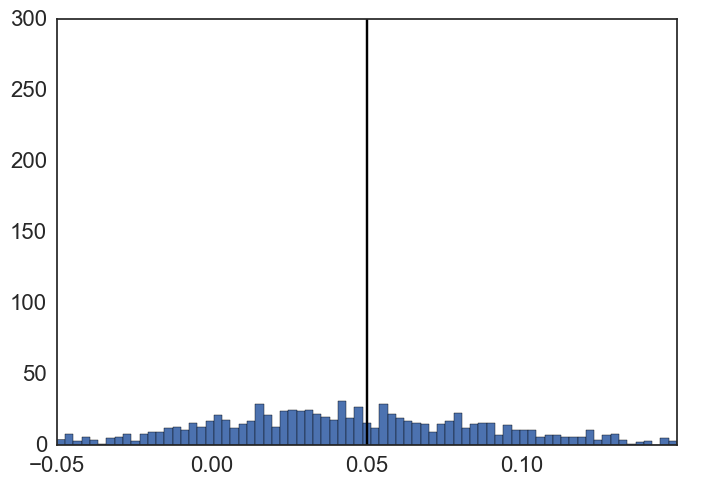

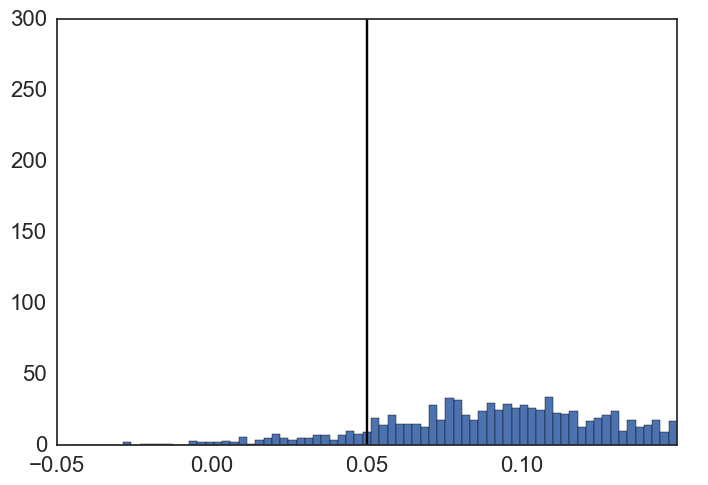

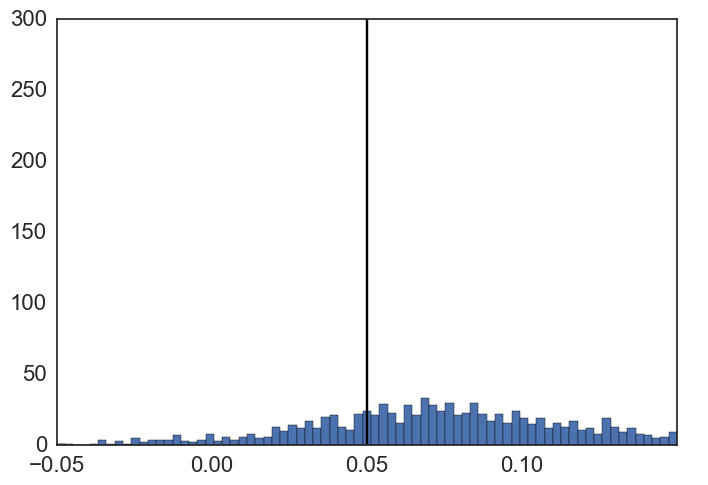

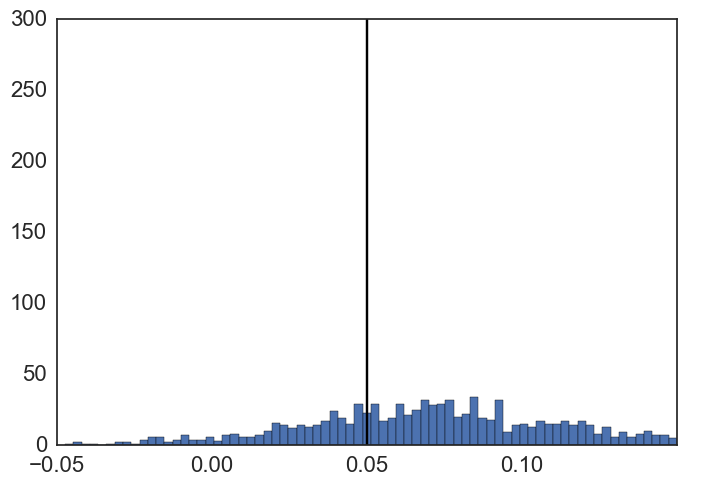

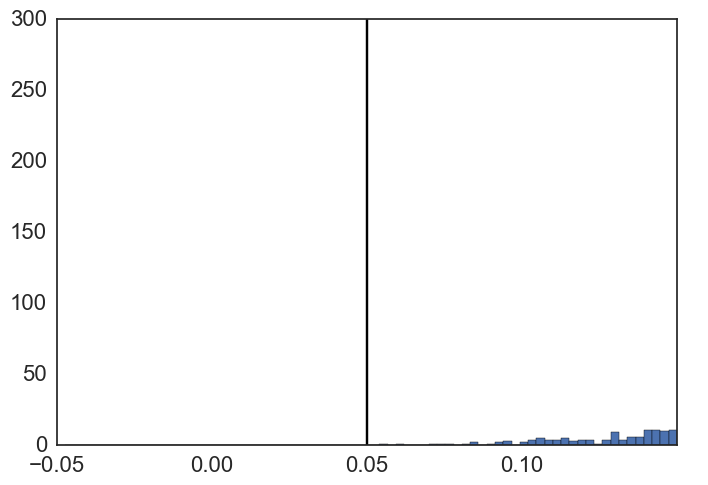

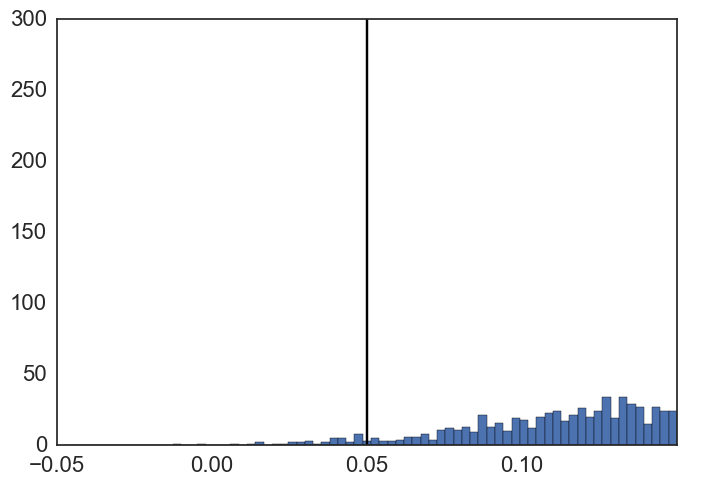

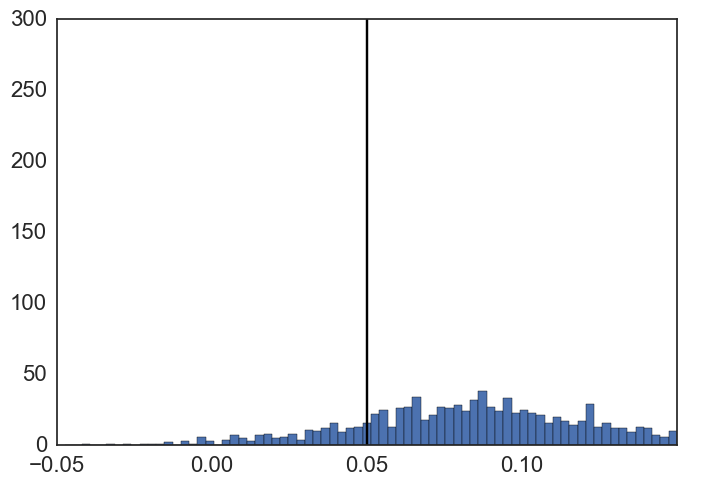

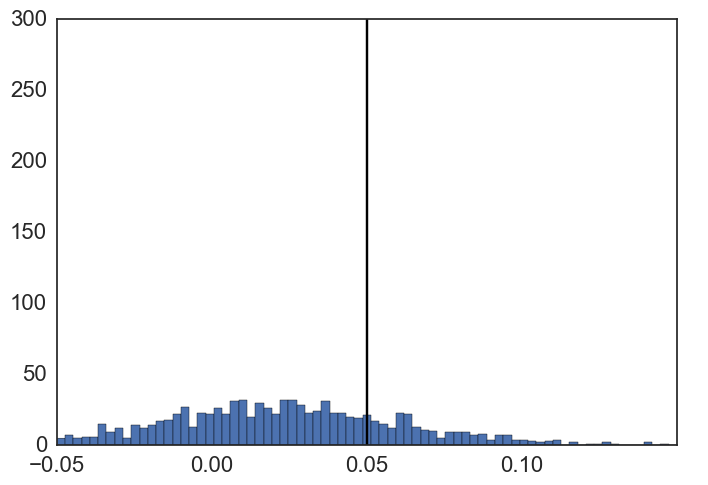

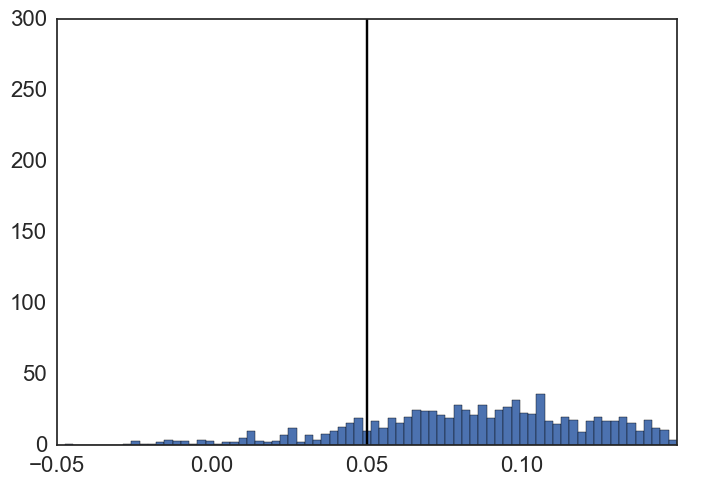

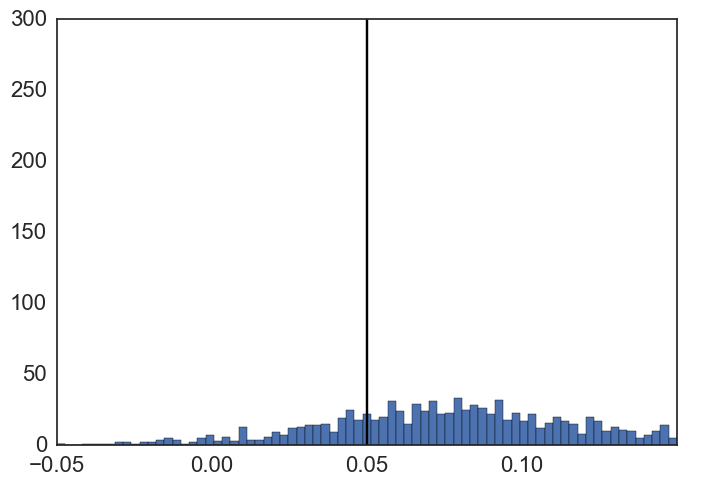

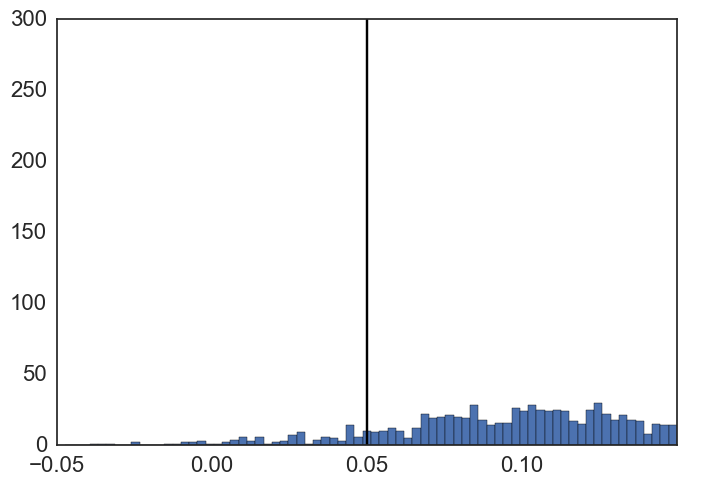

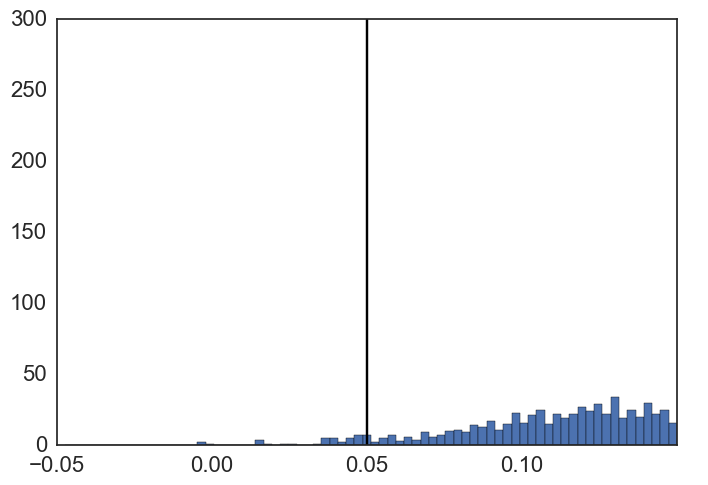

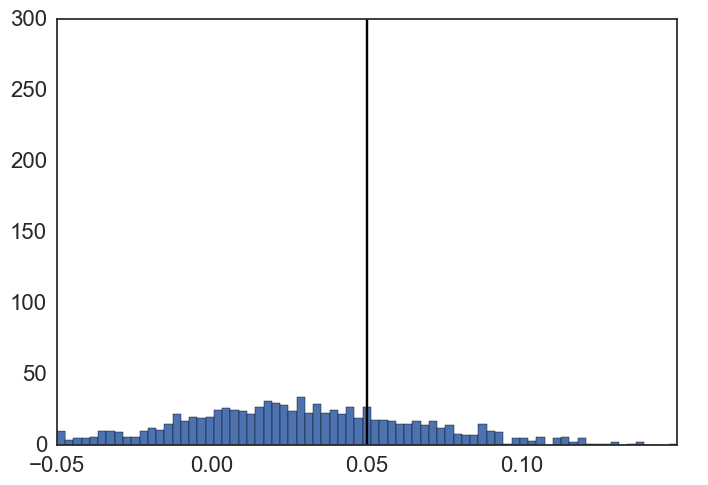

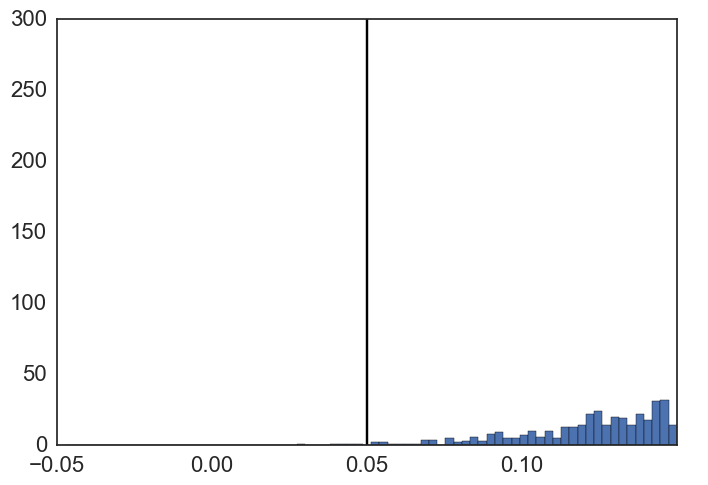

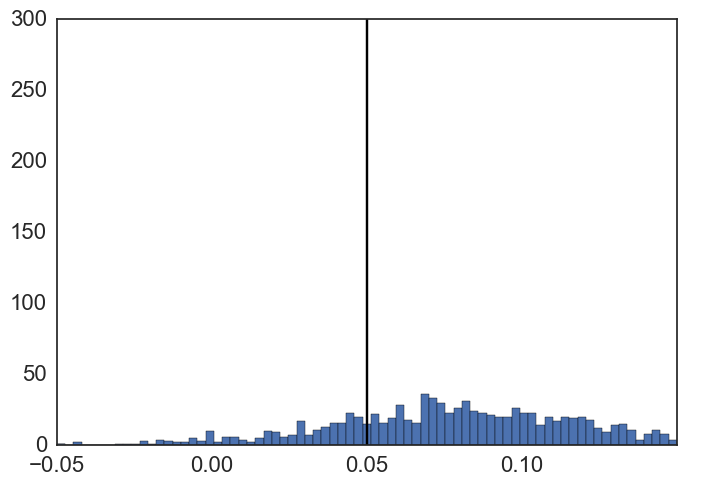

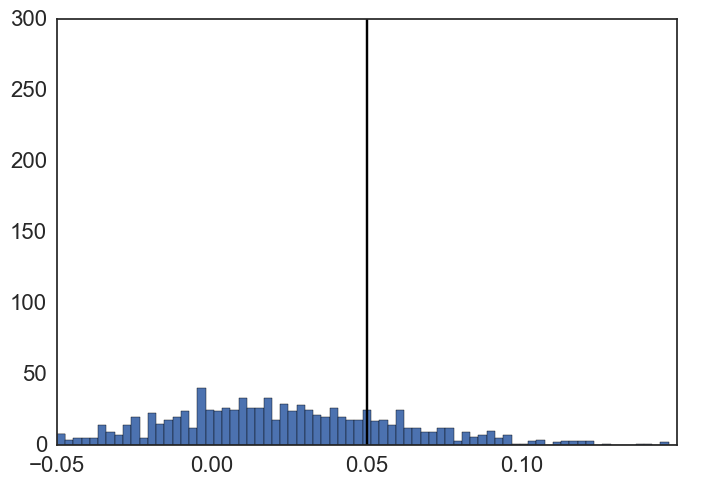

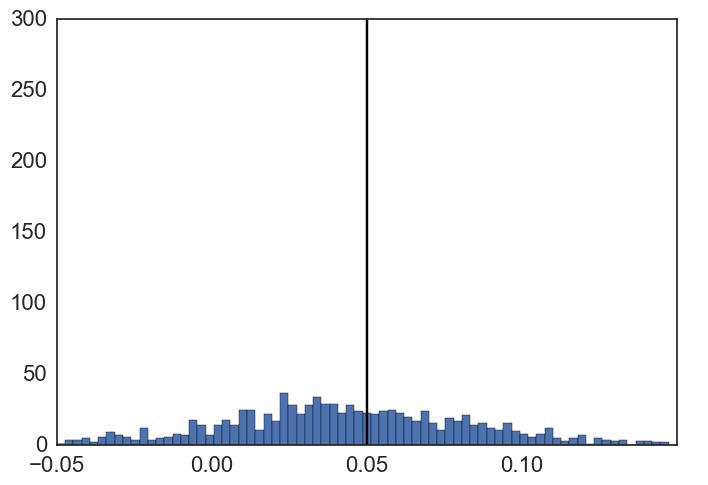

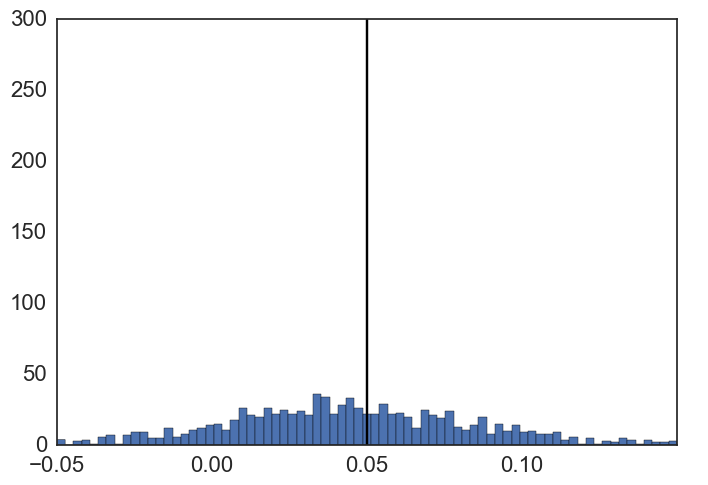

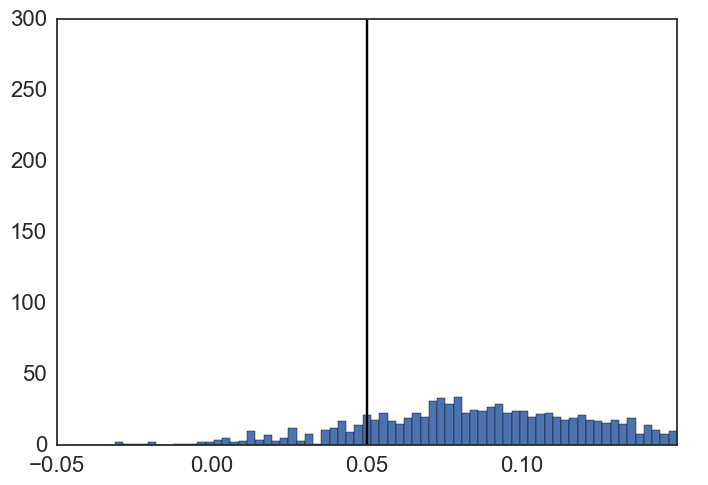

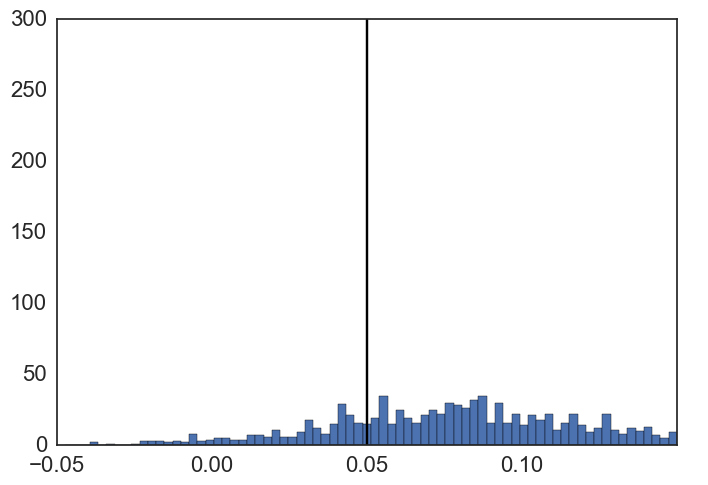

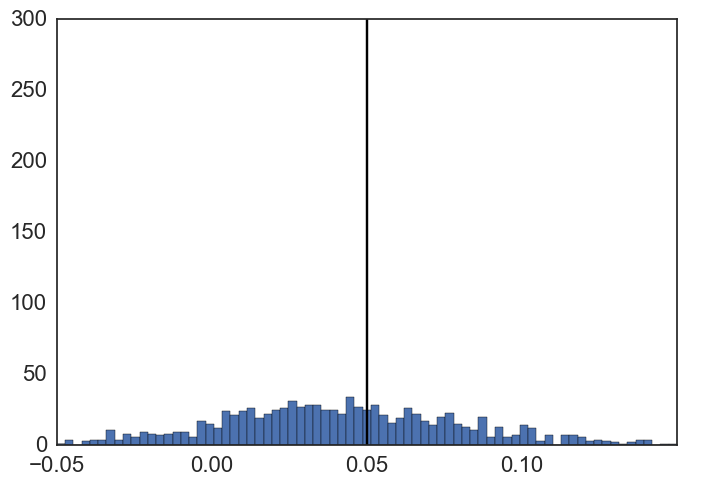

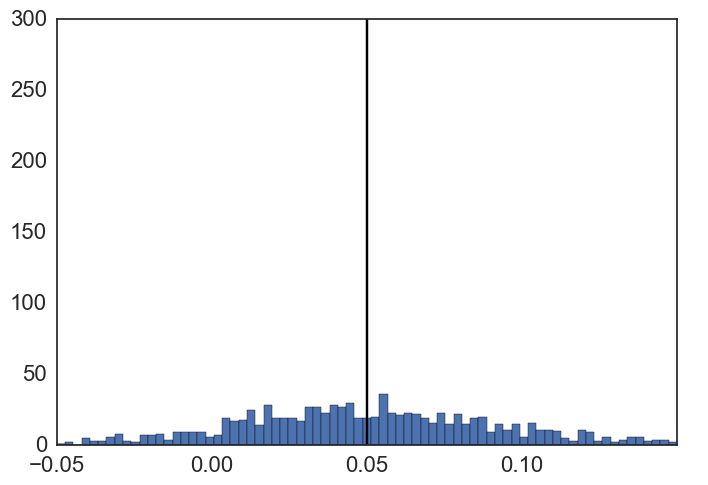

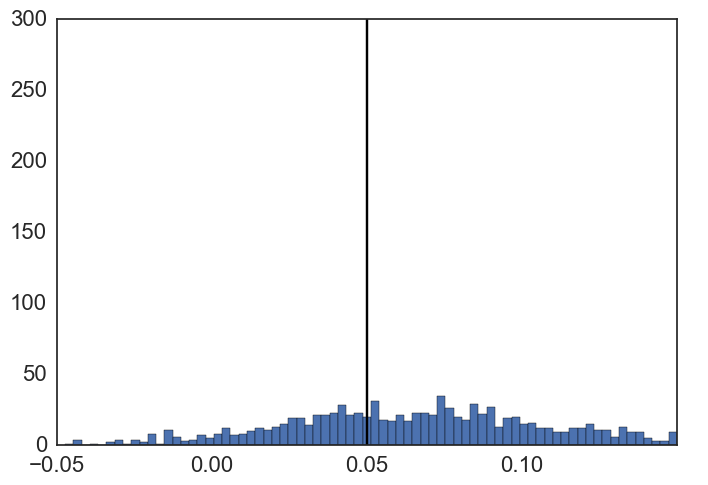

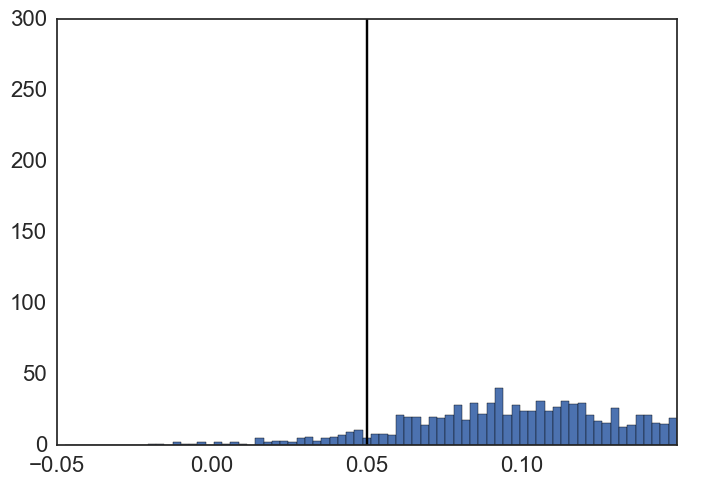

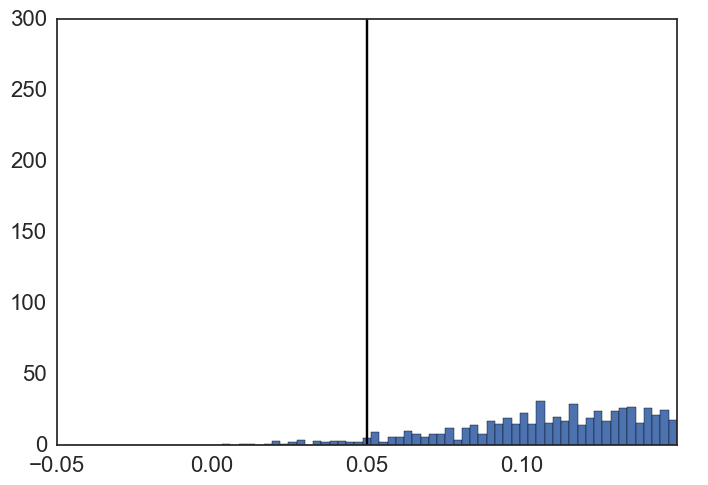

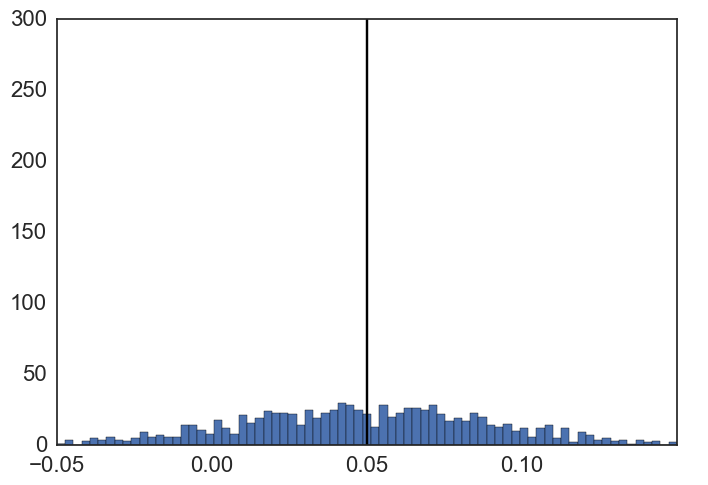

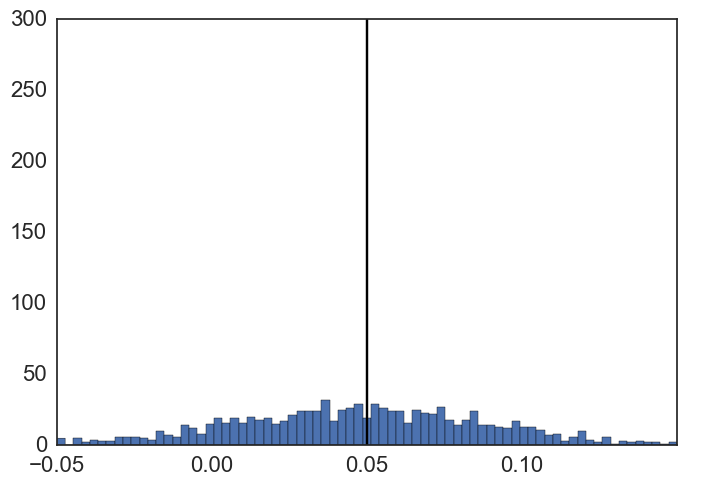

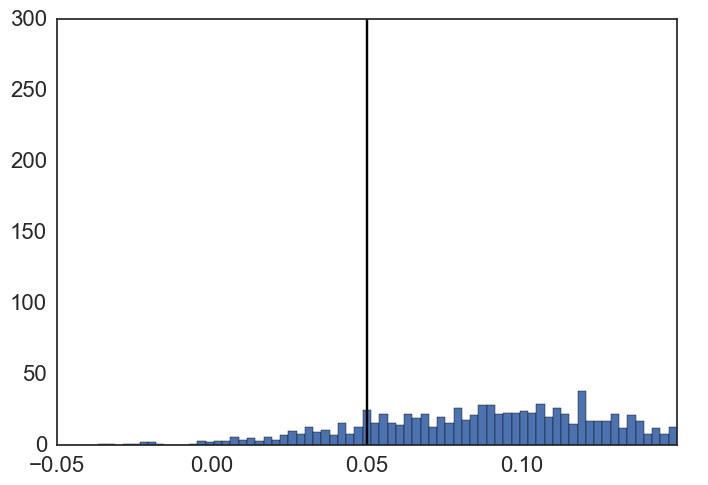

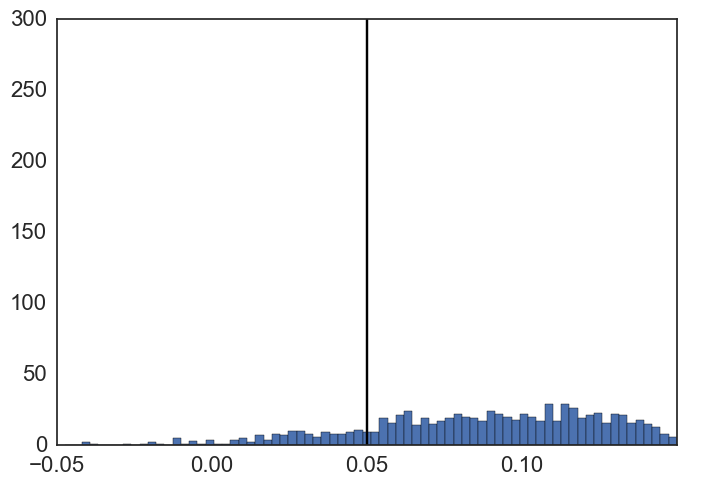

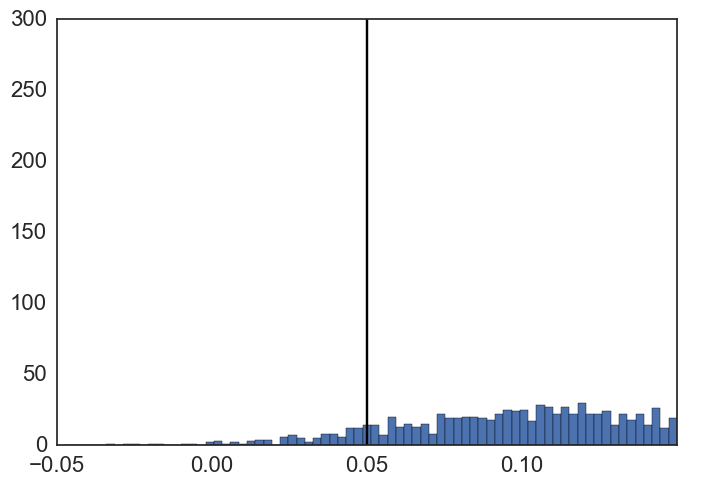

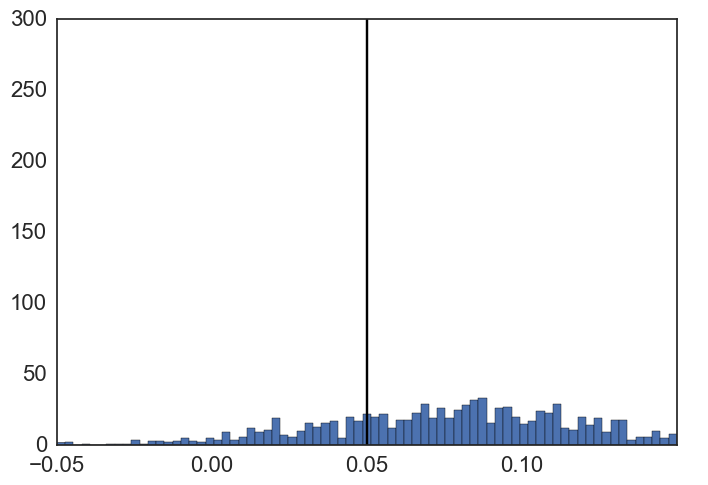

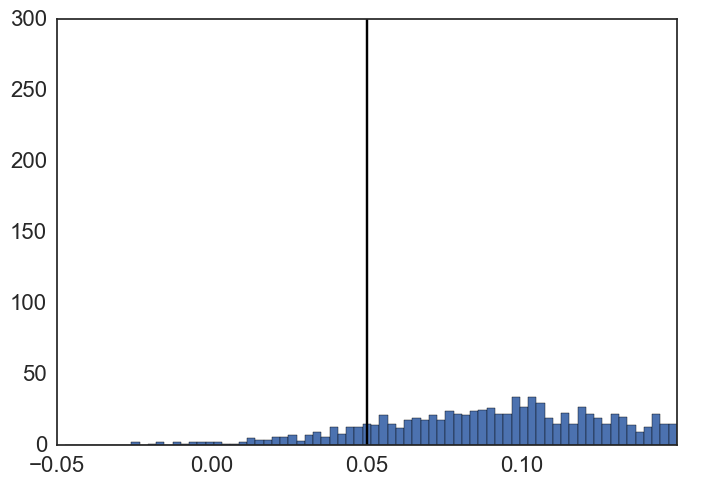

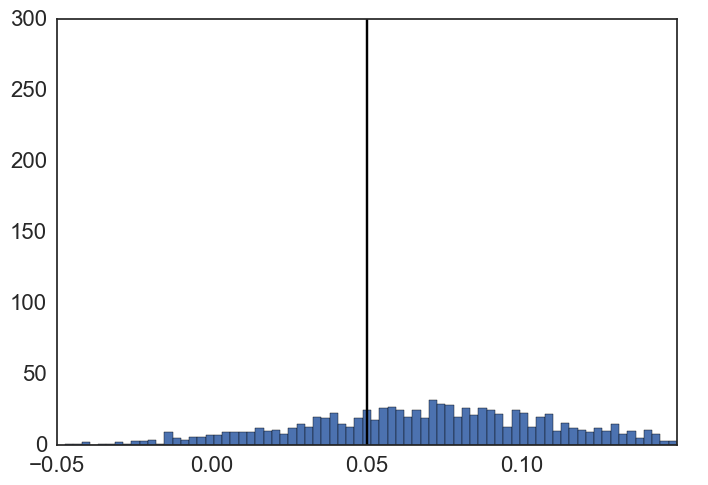

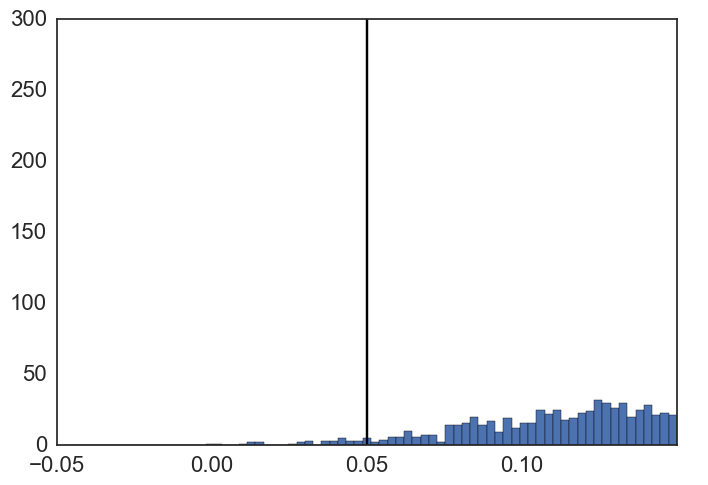

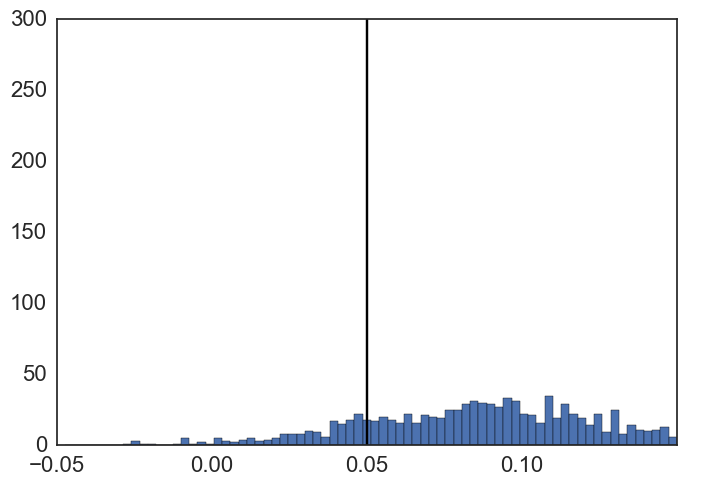

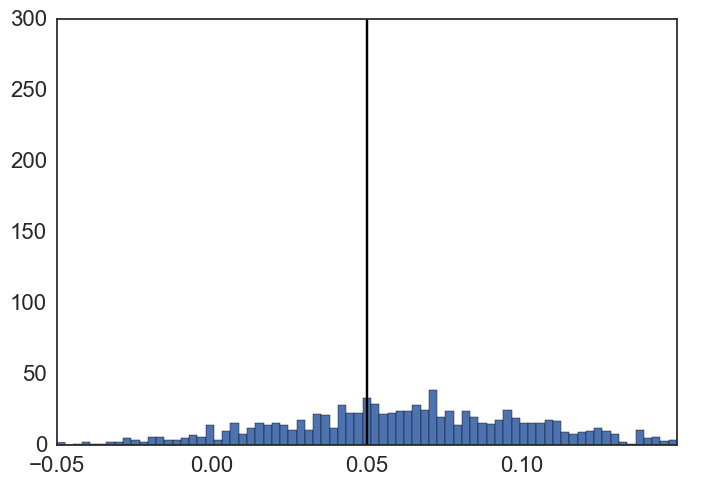

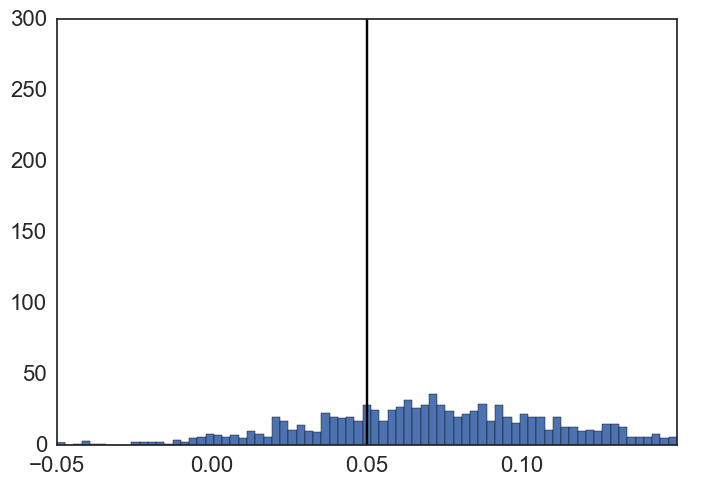

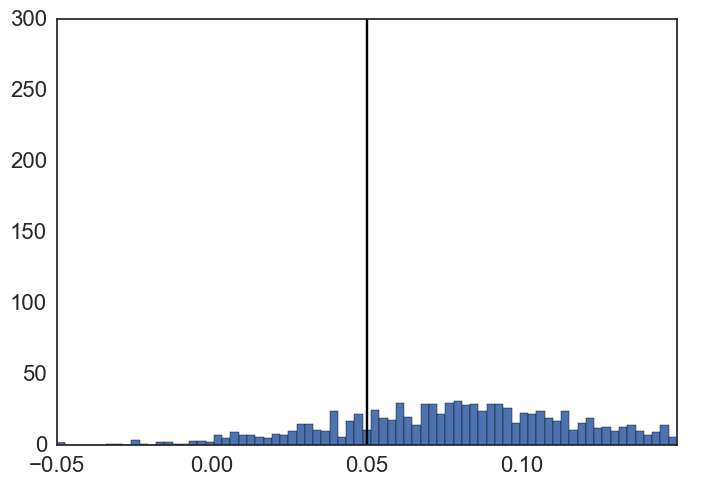

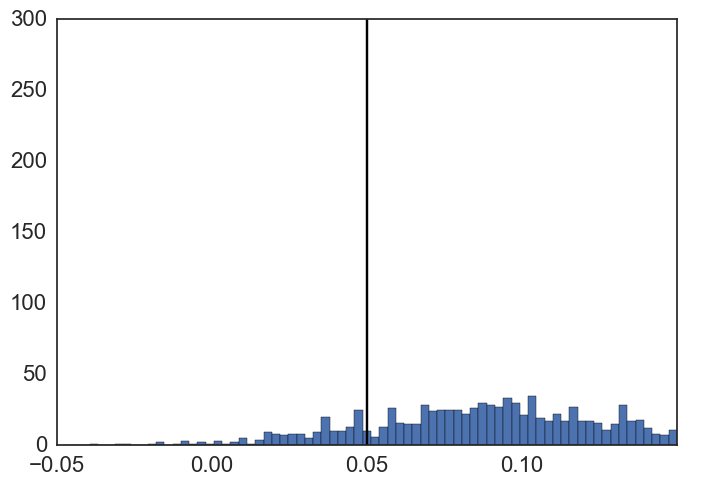

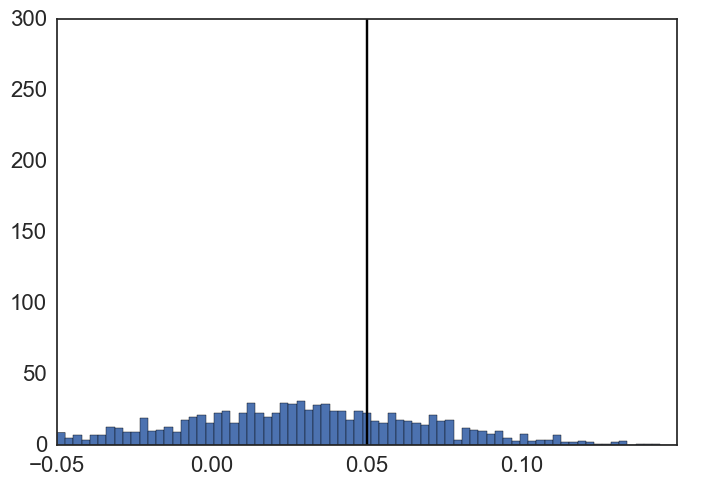

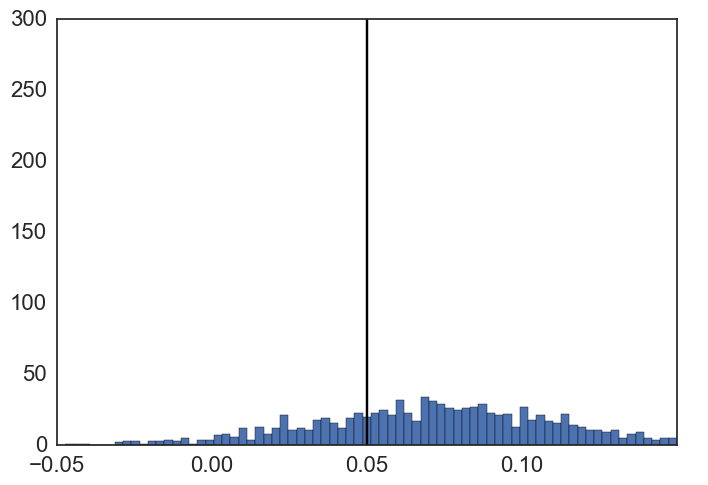

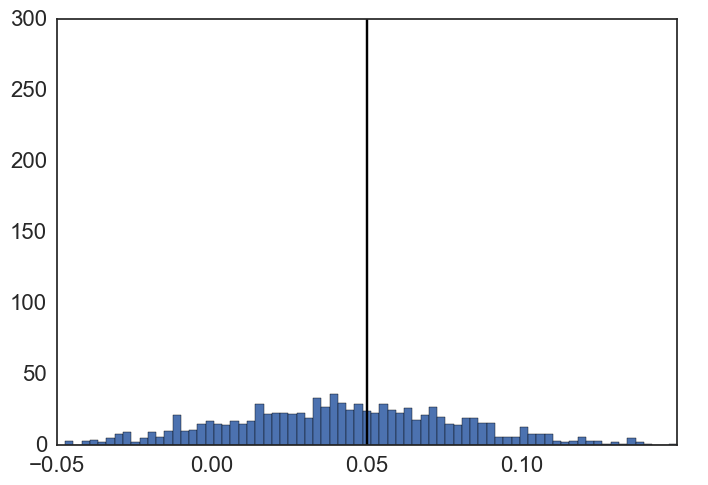

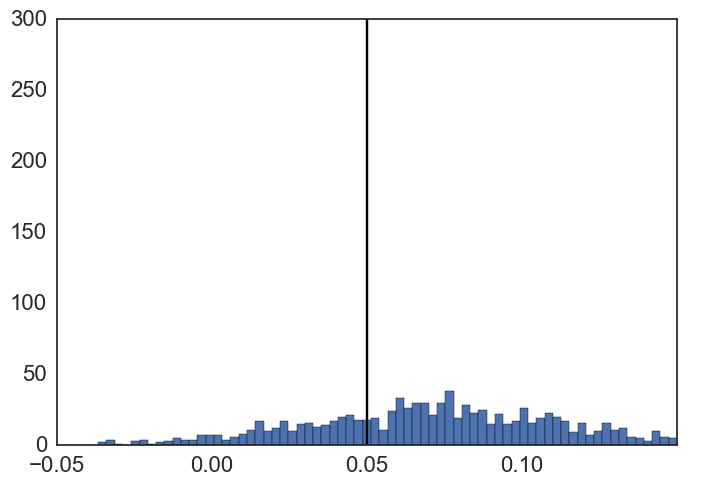

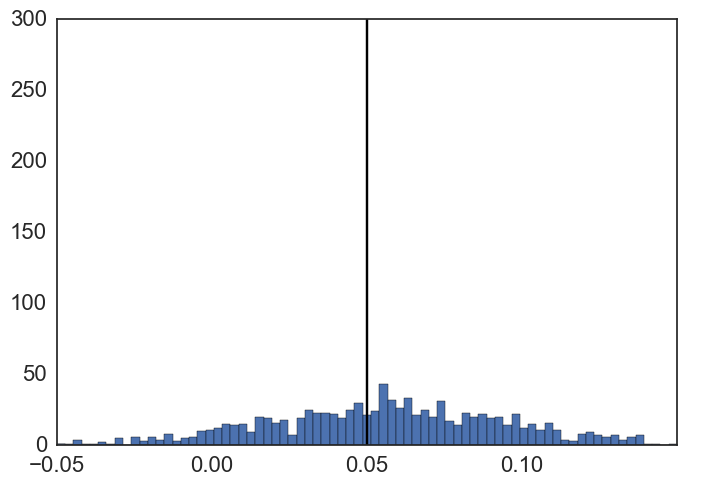

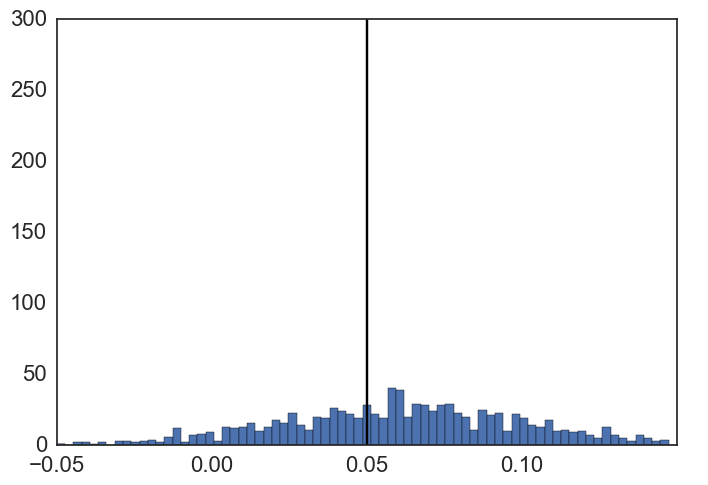

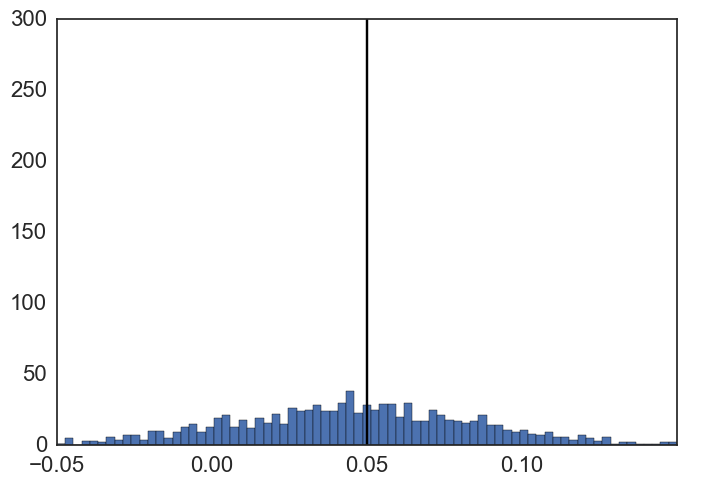

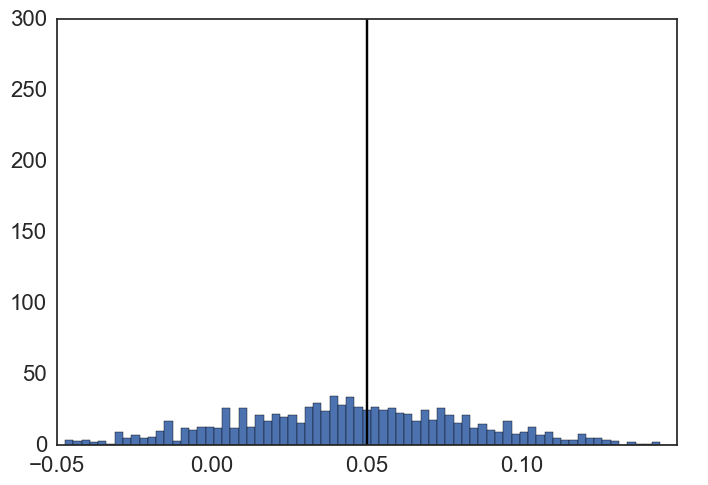

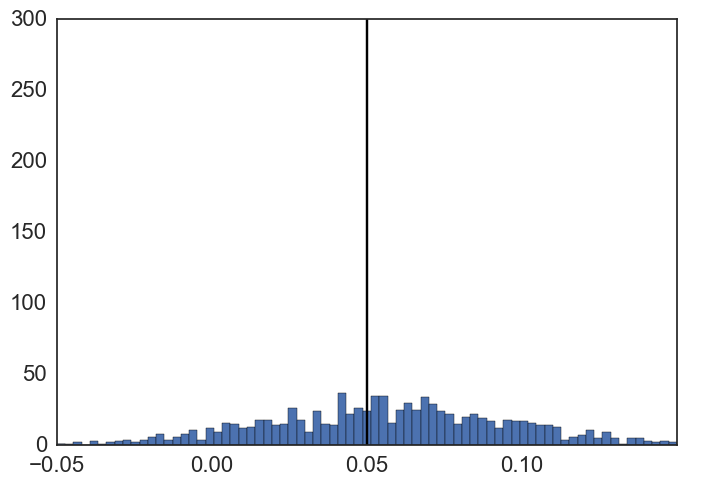

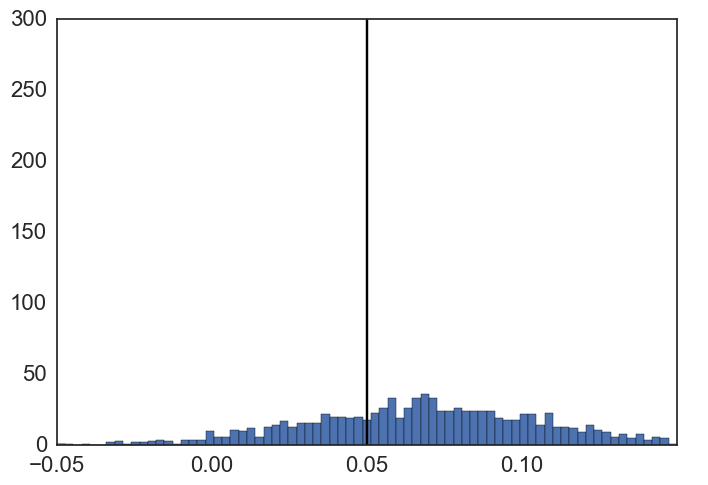

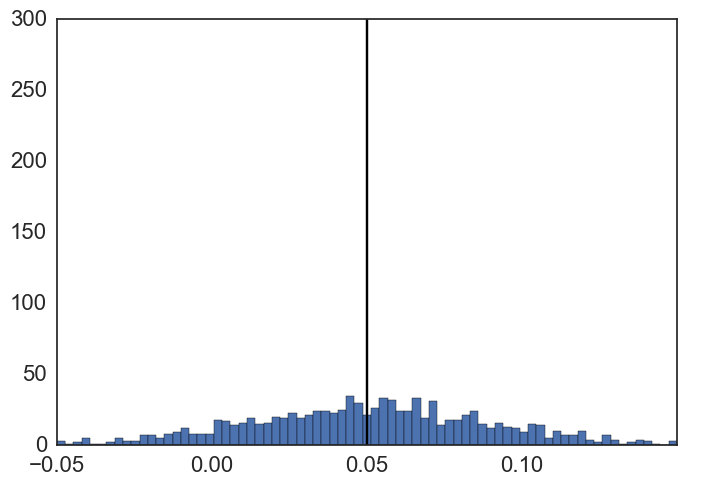

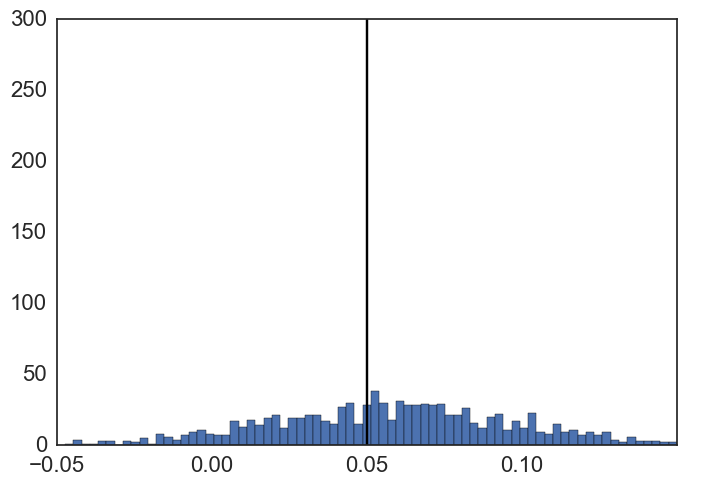

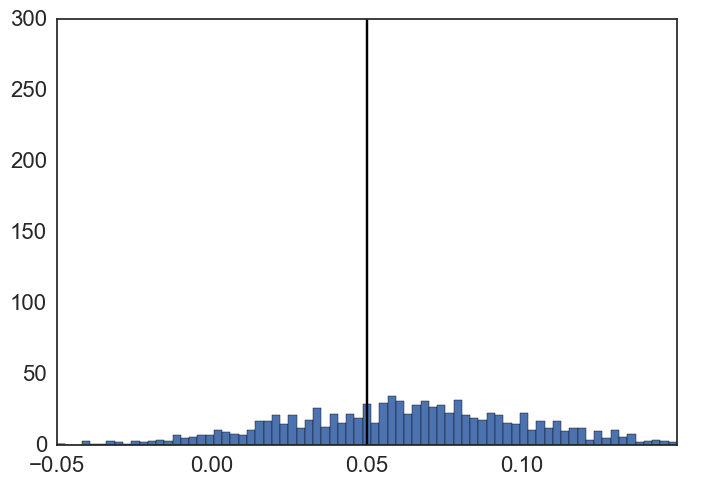

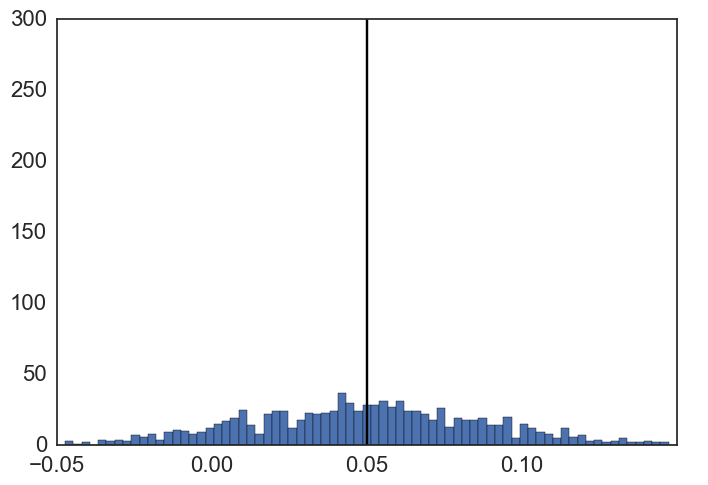

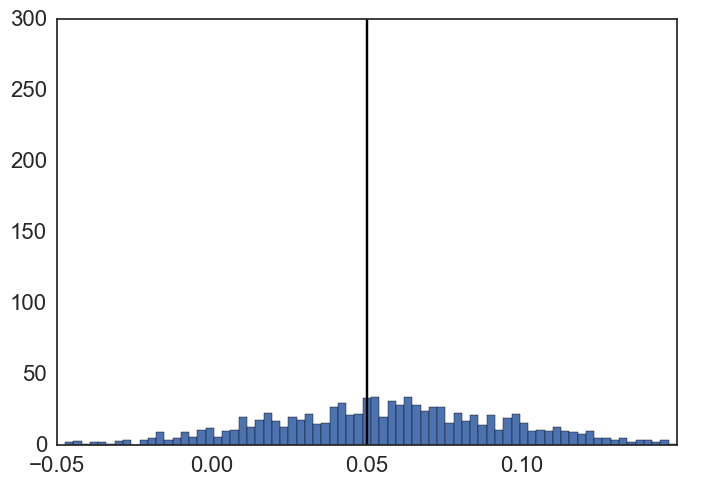

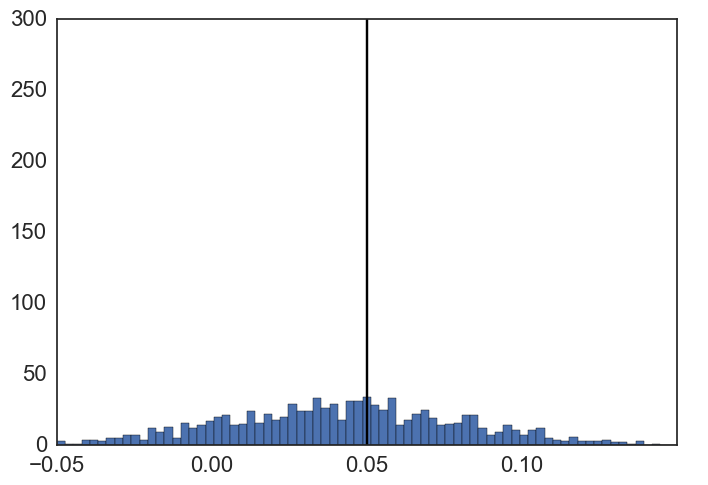

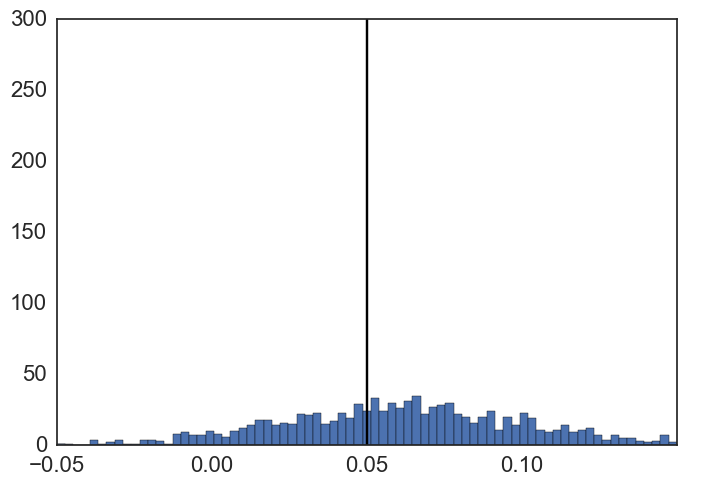

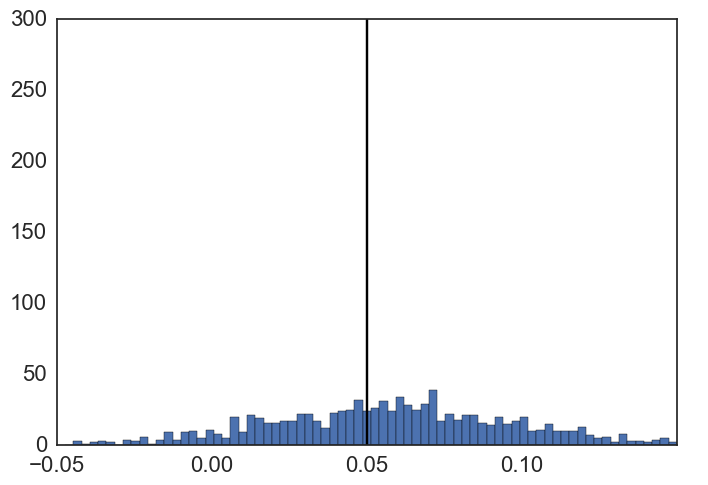

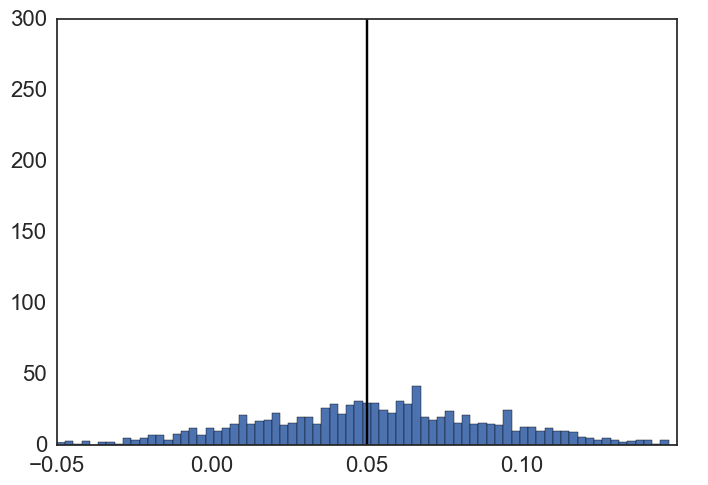

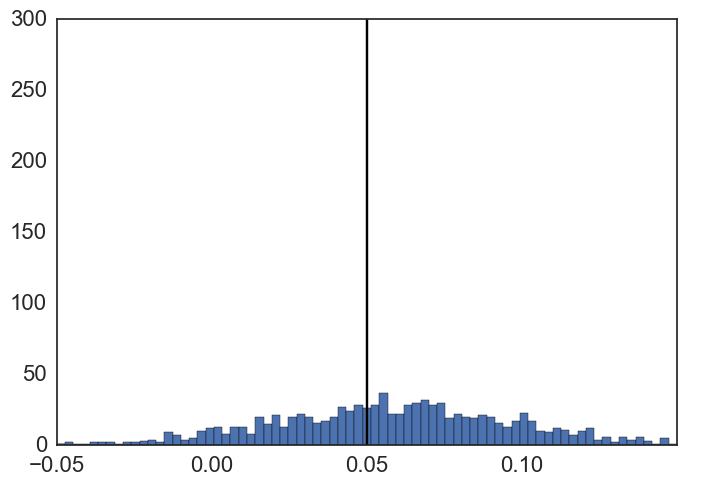

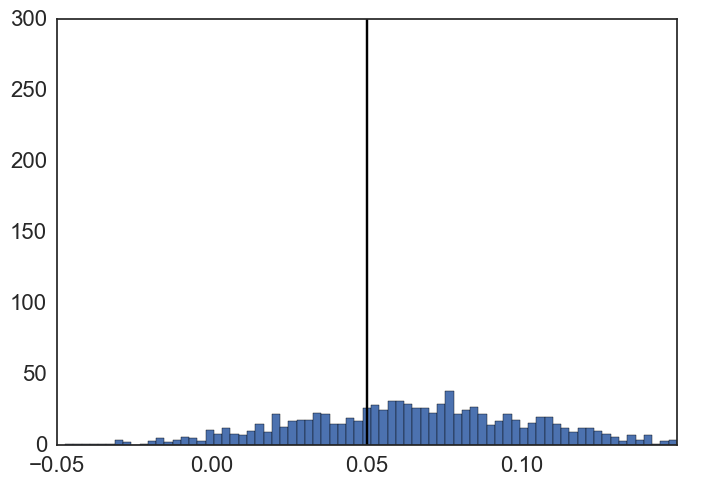

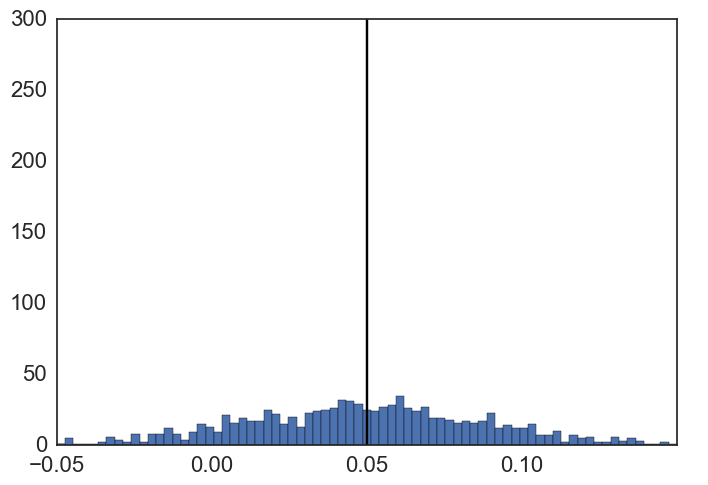

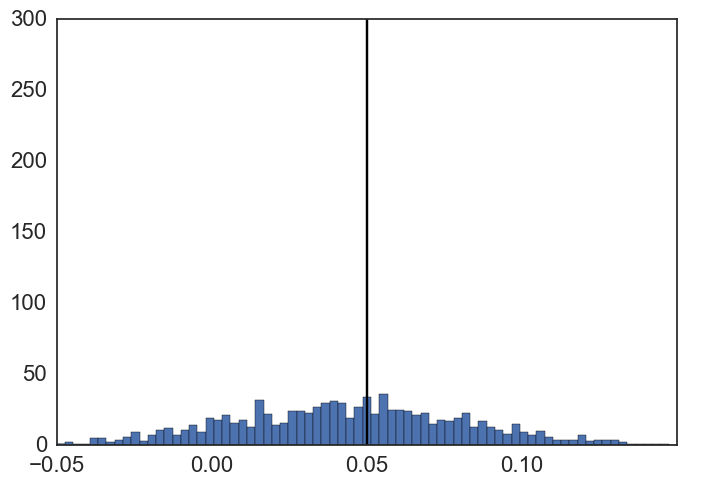

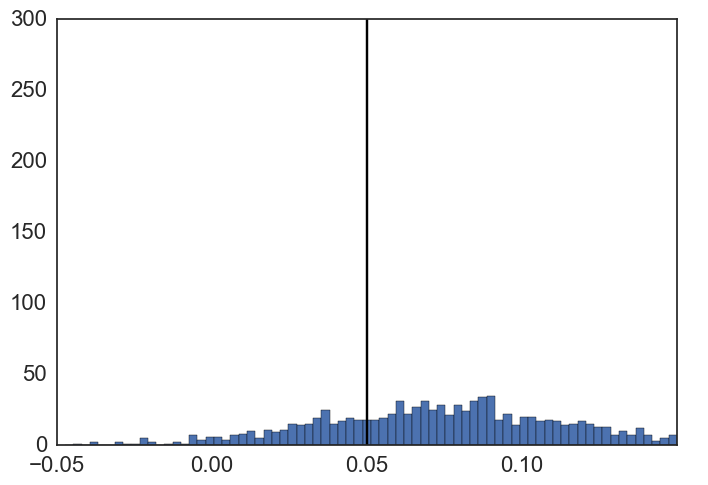

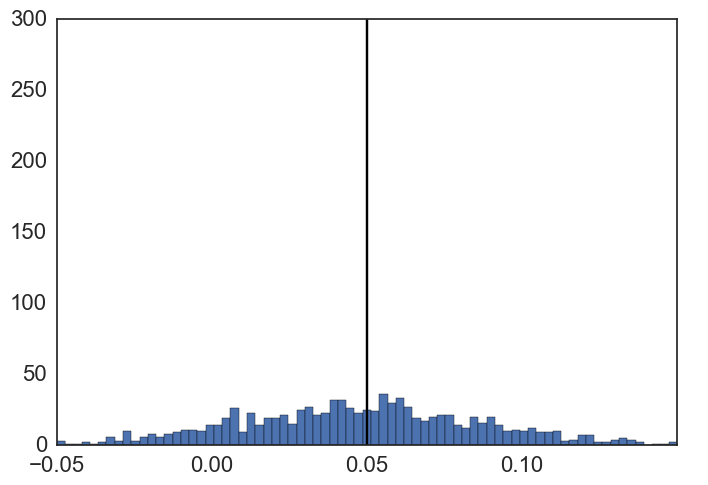

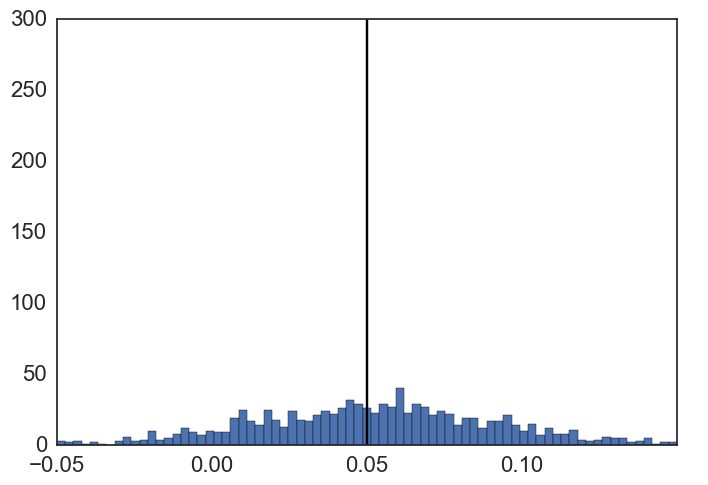

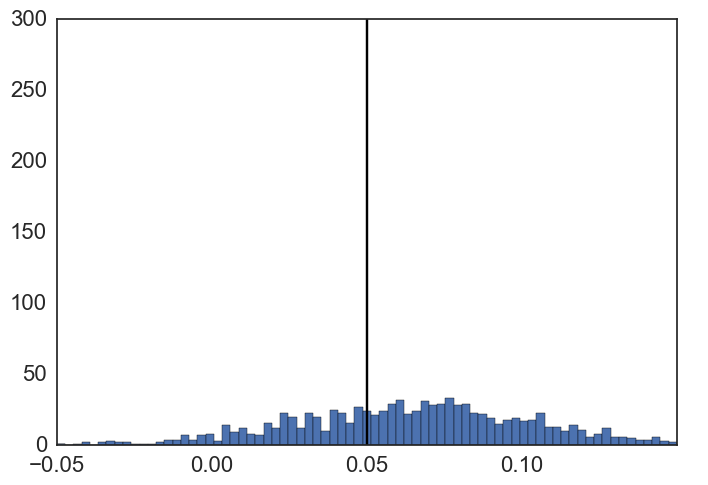

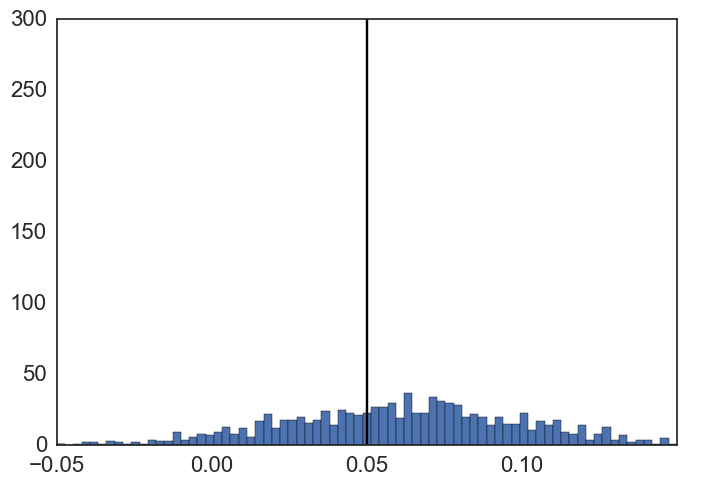

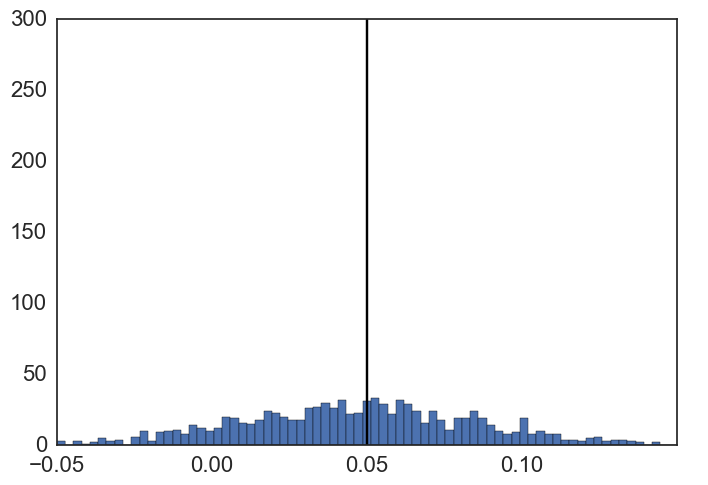

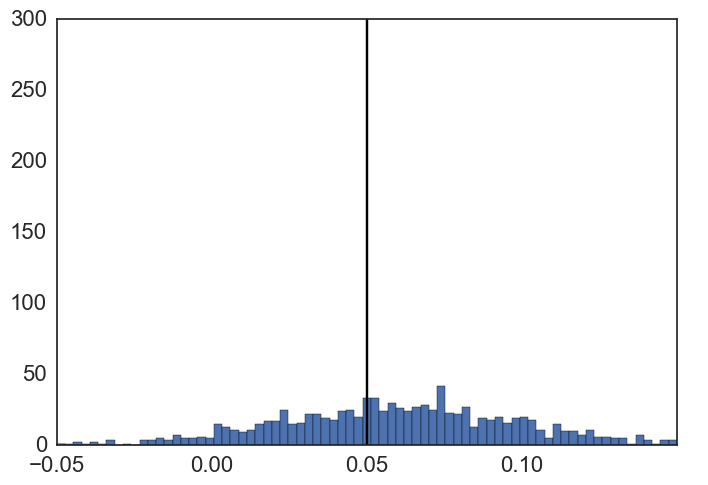

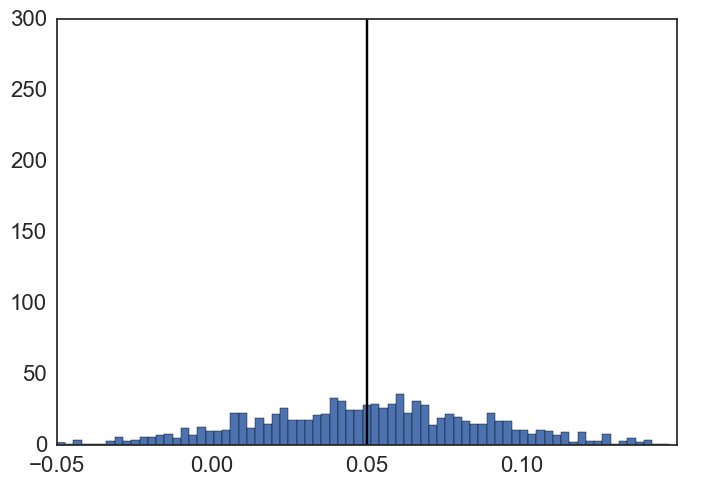

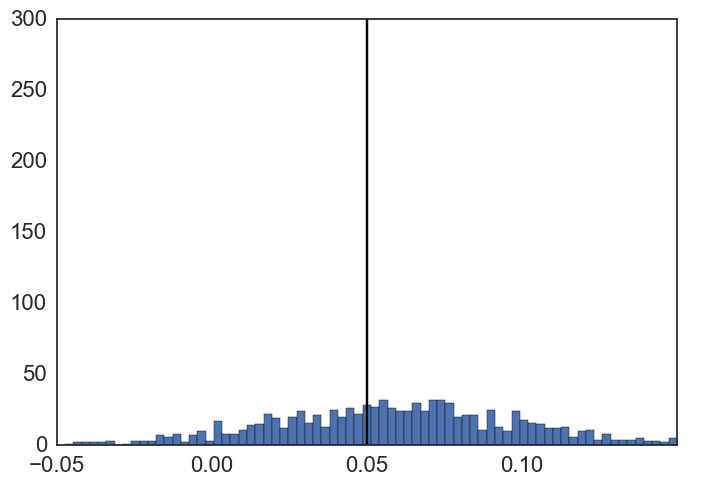

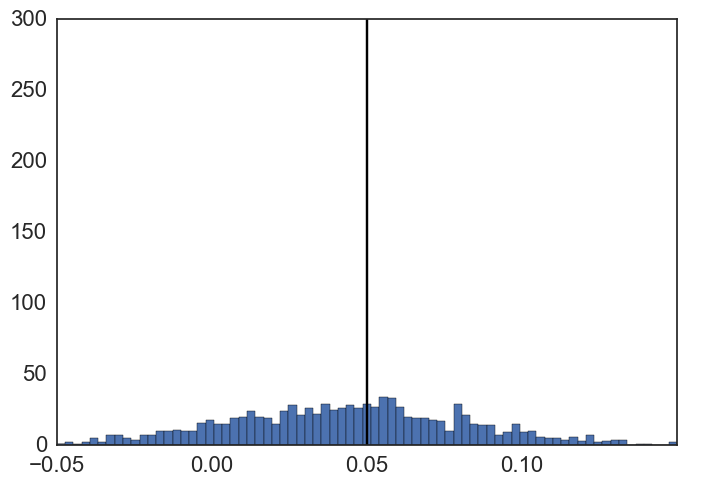

In [ ]:
i = 0
for prediction_elu in covnet_mo_elu_predictions:
    i=i+1
    print(i)
    predictions_hist(np.reshape(prediction_elu[1], len(prediction_elu[3])), test_set_model_params().gbm_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Mu",
                 min_edge = -0.05,
                 max_edge = 0.15,
                 img_subdir = "Animations/Multiple_Output/Mu/"+str(i),
                 y_lim = (0, 300));

## Training / Convergence Graphs

In [8]:
def extract_history(histories, param_name = None):
    mape = []
    mse = []
    r2 = []
    
    r2_string = "r2"
    loss_string = "loss"
    mape_string = "mean_absolute_percentage_error"
    
    if param_name != None:
        r2_string = param_name + "_" + r2_string
        loss_string = param_name + "_" + loss_string
        mape_string = param_name + "_" + mape_string

    for history in histories:
        r2.append(history[r2_string])
        mse.append(history[loss_string])
        mape.append(history[mape_string])

    mape = np.reshape(mape, len(mape))
    r2 = np.reshape(r2, len(r2))
    mse = np.reshape(mse, len(mse))
    
    return mape, r2, mse

def plot_r2_versus_mse(r2, mse, epochs = None, savedir = None, xlim = None, r2_ylim = (-2, 1)):    
    fig, ax1 = plt.subplots()
    ax1.plot(r2, c='r')
    ax1.set_xlabel('Epochs')
    ax1.set_ylim(r2_ylim[0], r2_ylim[1])
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('R-Squared', color='r')
    ax1.tick_params('y', color='r')

    ax2 = ax1.twinx()
    ax2.plot(mse)
    ax2.set_ylabel('Mean Squared Error', color='b')
    ax2.set_yscale('log')
    ax2.tick_params('y', color='b')
    
    if xlim != None:
        ax1.set_xlim(xlim[0], xlim[1])
        ax2.set_xlim(xlim[0], xlim[1])
    
    if epochs != None:
        ax1.set_xlim(-10, epochs)

    fig.tight_layout()
    plt.show()
    
    if savedir != None:
        fig.savefig(ROOT_DIR + savedir + ".png")
        
    return fig

def standard_plot(data, xlabel = None, ylabel = None, xlim = None, ylim = None, yscale = None, savedir = None):
    fig = pylab.figure()

    pylab.plot(data);
    
    if xlim != None:
        pylab.xlim(xlim[0], xlim[1])
    
    if ylim != None:
        pylab.ylim(ylim[0], ylim[1]);
    
    if xlabel != None:
        pylab.xlabel(xlabel)
        
    if ylabel != None:
        pylab.ylabel(ylabel)
        
    if yscale != None:
        pylab.yscale(yscale)
        
    pylab.show();

    if savedir != None:
        fig.savefig(ROOT_DIR + savedir +".png")
        
    return fig

def all_training_history_plots(histories, modelname, paramname, xlim = None, r2_ylim = (-2, 1)):
    
    mape, r2, mse = histories

    r2_mse_fig = plot_r2_versus_mse(r2, mse, r2_ylim = r2_ylim, xlim = xlim,)

    r2_fig = standard_plot(r2, "Epochs", "R-Squared", 
                  ylim=r2_ylim, xlim = xlim,
                  savedir = "Images/Prediction-Convergence/"+modelname+"/"+paramname+"-RSquared");

    mse_fig = standard_plot(mse, "Epochs", "Mean Squared Error", yscale = 'log', xlim = xlim,
                  savedir = "Images/Prediction-Convergence/"+modelname+"/"+\
                  paramname+"-MSE");
    
    return r2_mse_fig, r2_fig, mse_fig

### Convolutional Architecture: Single Output

#### Lambda

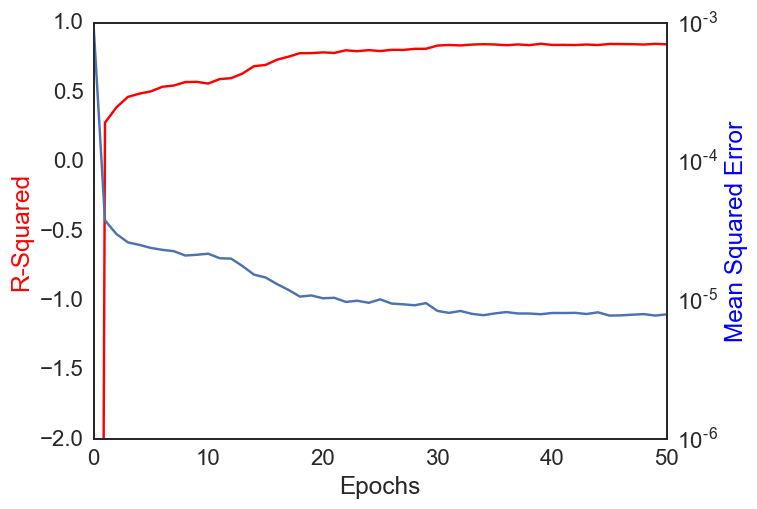

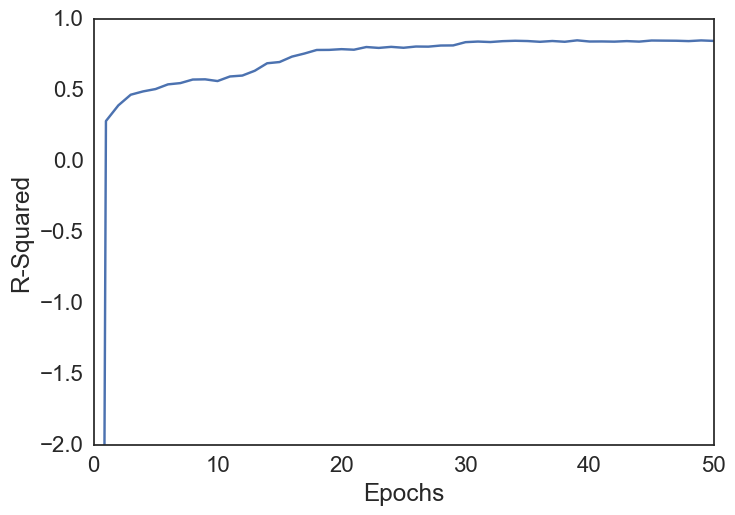

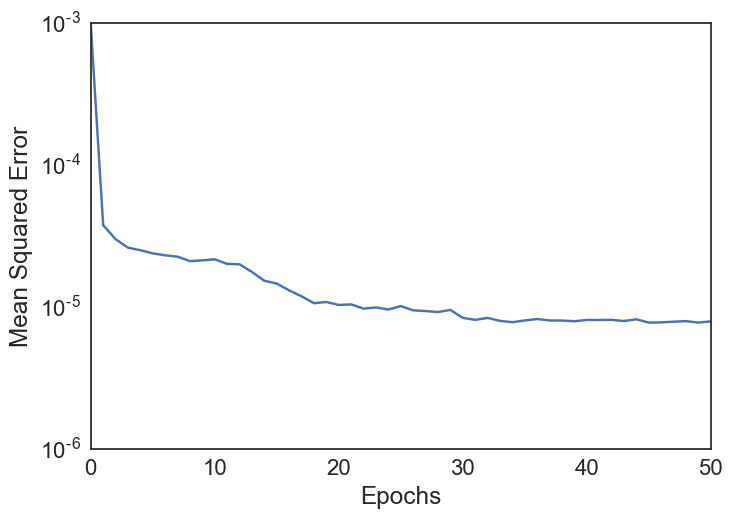

In [10]:
lambda_histories = extract_history(np.load("Lambda_histories.npy"))
all_training_history_plots(lambda_histories, 
                           "ConvolutionalNN-SingleOutput",
                           "Lambda");

#### Lambda

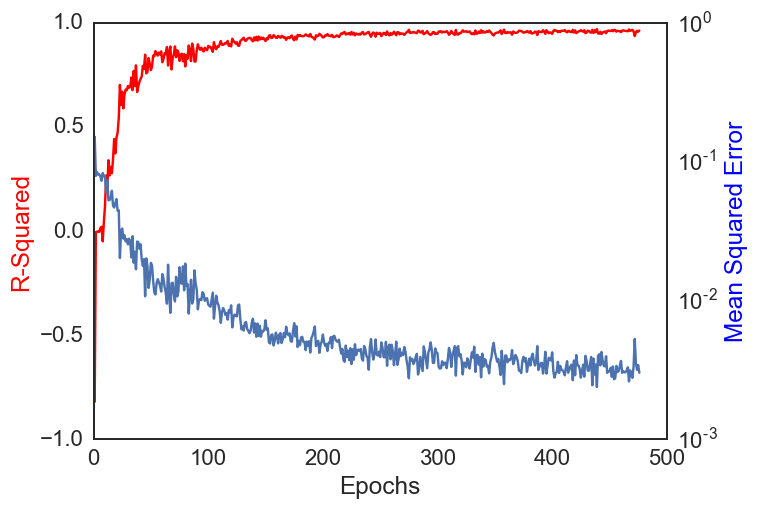

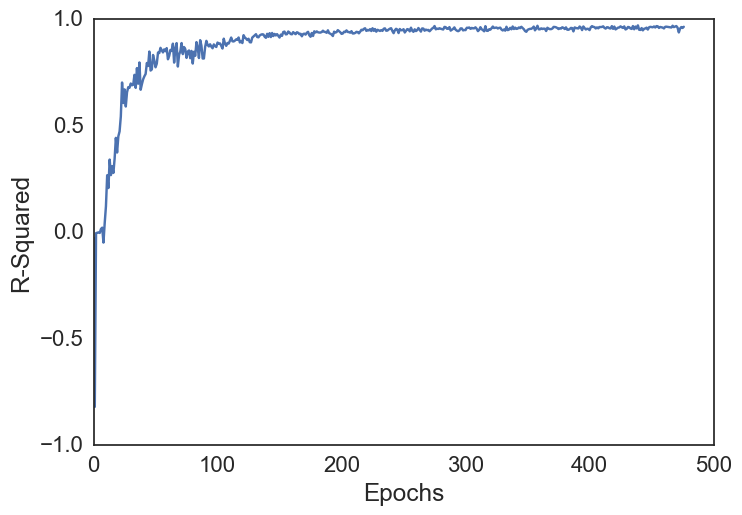

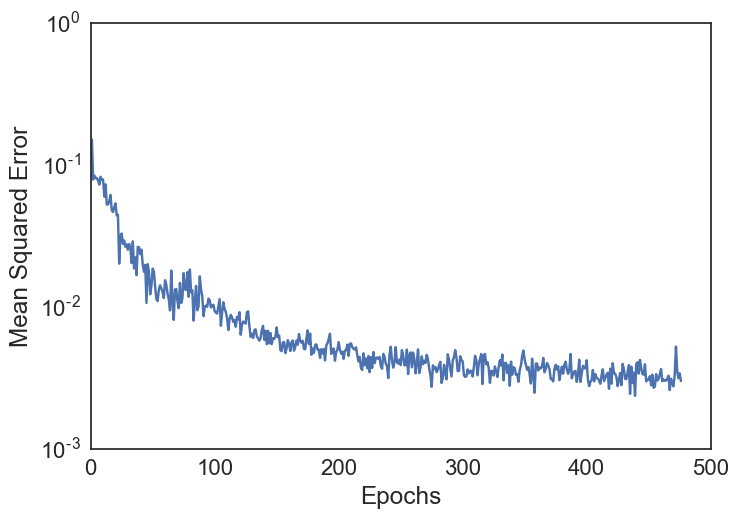

In [11]:
lambda_histories = extract_history(np.load("histories_covnet_jump_mu.npy"))
all_training_history_plots(lambda_histories, 
                           "ConvolutionalNN-SingleOutput",
                           "Lambda", r2_ylim = (-1, 1));

#### Multiple Output Network

In [26]:
histories_elu = np.load("covnet_histories_elu.npy")

In [27]:
elu_histories_jump_mu = extract_history(np.load("covnet_histories_elu.npy"), 
                                "jump_mu")
elu_histories_jump_sigma = extract_history(np.load("covnet_histories_elu.npy"), 
                                "jump_sigma")
elu_histories_mu = extract_history(np.load("covnet_histories_elu.npy"), 
                                "mu")
elu_histories_sigma = extract_history(np.load("covnet_histories_elu.npy"), 
                                "sigma")
elu_histories_lambda = extract_history(np.load("covnet_histories_elu.npy"), 
                                "lambda")

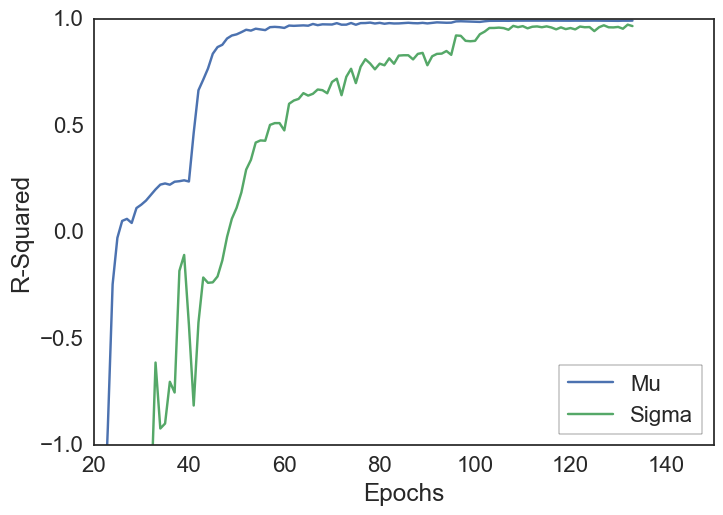

In [39]:
fig = plt.figure()
plt.plot(elu_histories_mu[1], label="Mu")
plt.plot(elu_histories_sigma[1], label="Sigma")
plt.ylim(-1, 1)
plt.xlim(20, 150)
plt.ylabel("R-Squared")
plt.xlabel("Epochs")
plt.legend(loc = 0, frameon=True)
fig.savefig("./Images/Prediction-Convergence/FullyConnectedNN-MultipleOutput-ELU/training_r2_values_mu_sigma.png")

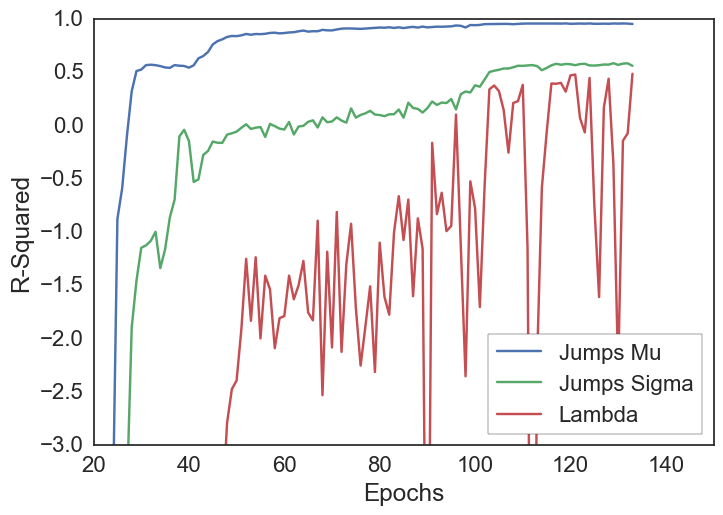

In [40]:
fig = plt.figure()
plt.plot(elu_histories_jump_mu[1], label="Jumps Mu")
plt.plot(elu_histories_jump_sigma[1], label="Jumps Sigma")
plt.plot(elu_histories_lambda[1], label="Lambda")
plt.ylim(-3, 1)
plt.xlim(20, 150)
plt.ylabel("R-Squared")
plt.xlabel("Epochs")
plt.legend(loc = 0, frameon=True)
fig.savefig("./Images/Prediction-Convergence/FullyConnectedNN-MultipleOutput-ELU/training_r2_values_jumps.png")

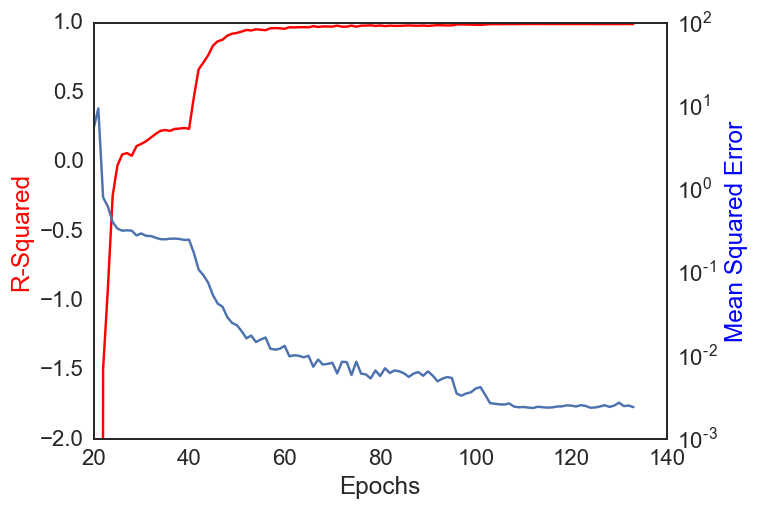

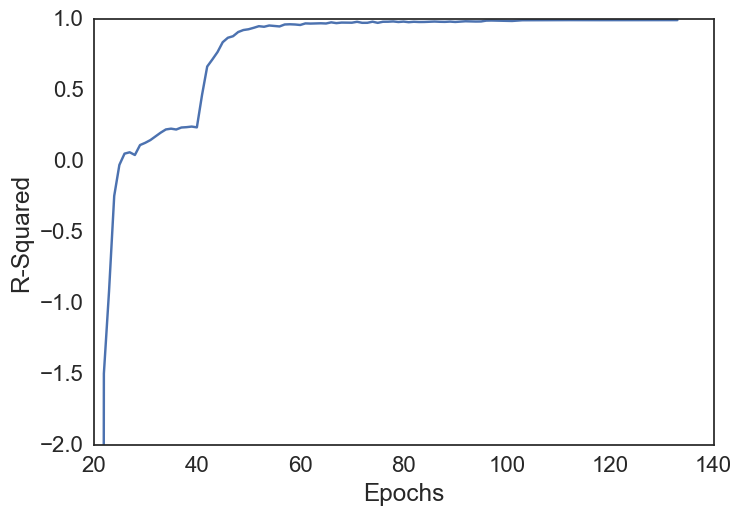

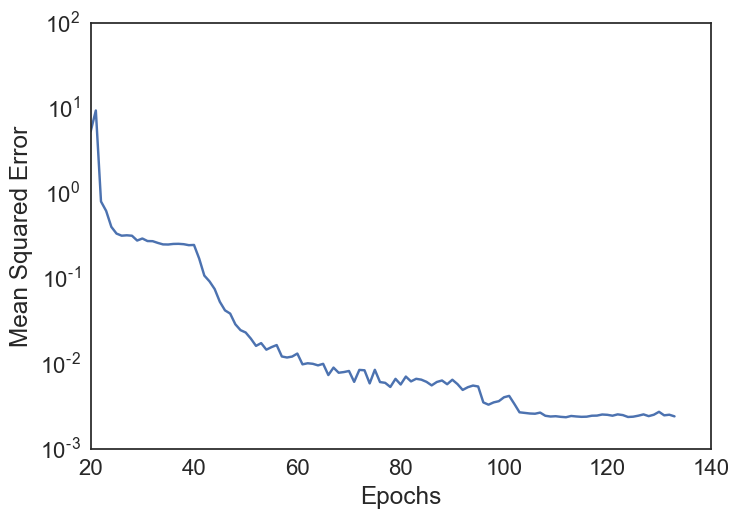

In [29]:
all_training_history_plots(elu_histories_mu, 
                           "ConvolutionalNN-MultipleOutput",
                           "Mu", r2_ylim = (-2, 1), xlim = (20, 140));

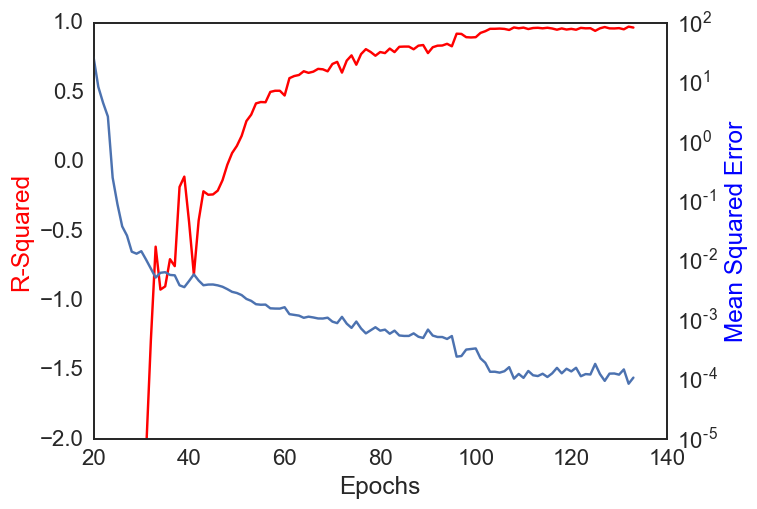

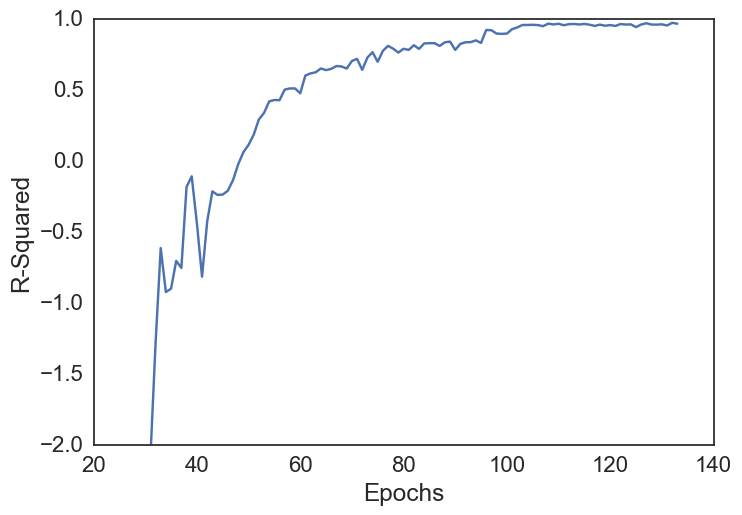

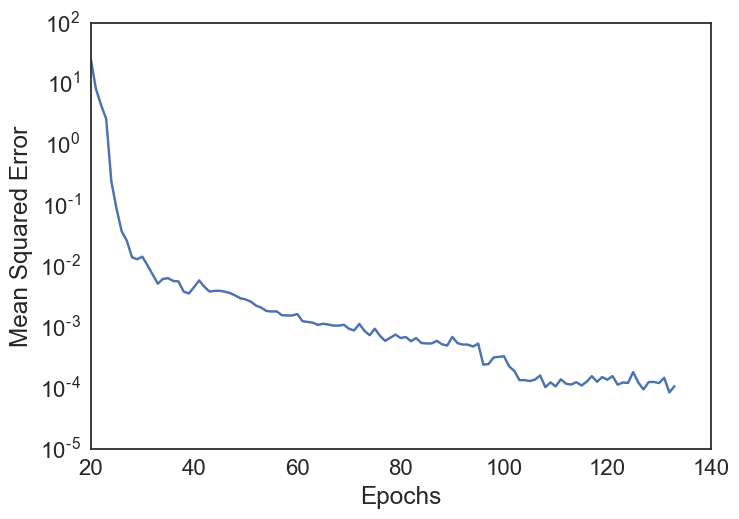

In [30]:
all_training_history_plots(elu_histories_sigma, 
                           "ConvolutionalNN-MultipleOutput",
                           "Sigma", r2_ylim = (-2, 1), xlim = (20, 140));

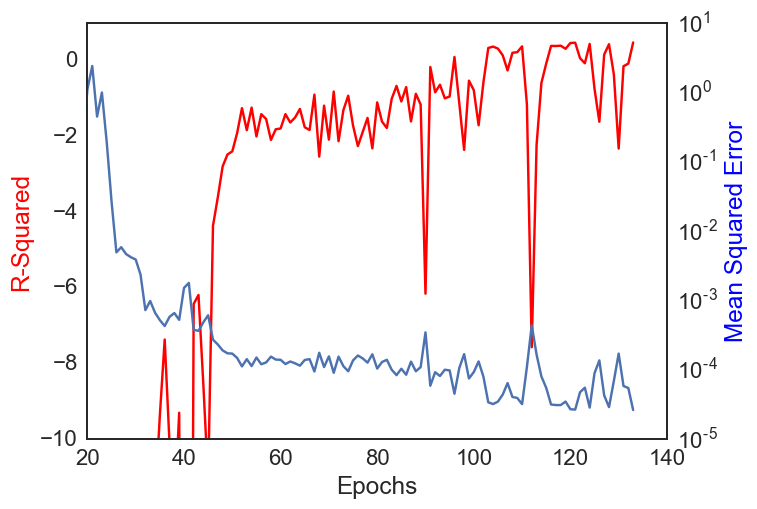

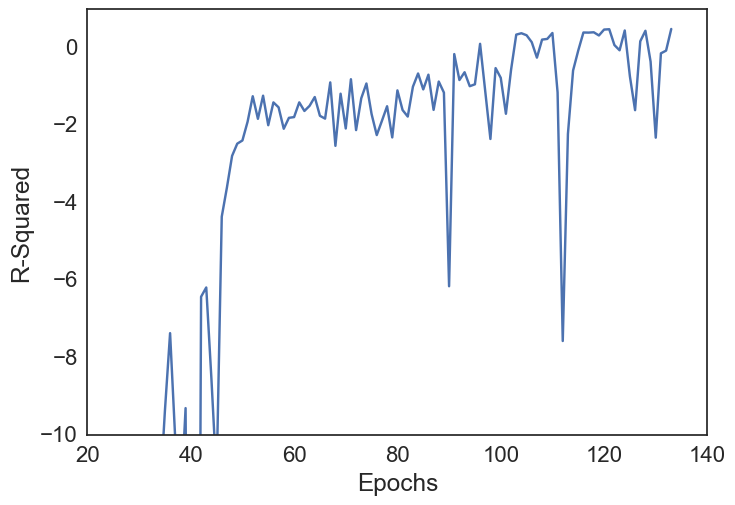

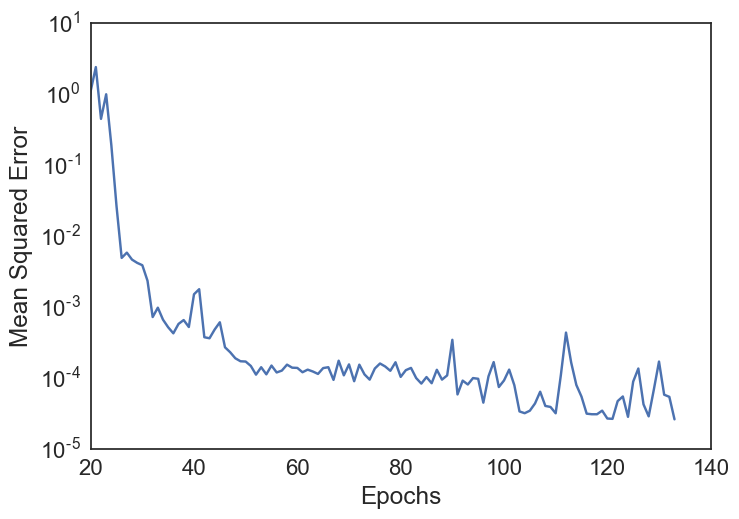

In [31]:
all_training_history_plots(elu_histories_lambda, 
                           "ConvolutionalNN-MultipleOutput",
                           "Lambda", r2_ylim = (-10, 1), xlim = (20, 140));

#### Fully Connected Multiple Output Network

In [12]:
histories_ff = np.load("feedforward_relu_histories.npy")

In [16]:
elu_histories_jump_mu = extract_history(histories_ff,
                                "jump_mu")
elu_histories_jump_sigma = extract_history(histories_ff, 
                                "jump_sigma")
elu_histories_mu = extract_history(histories_ff, 
                                "mu")
elu_histories_sigma = extract_history(histories_ff, 
                                "sigma")
elu_histories_lambda = extract_history(histories_ff, 
                                "lambda")

(0, 70)

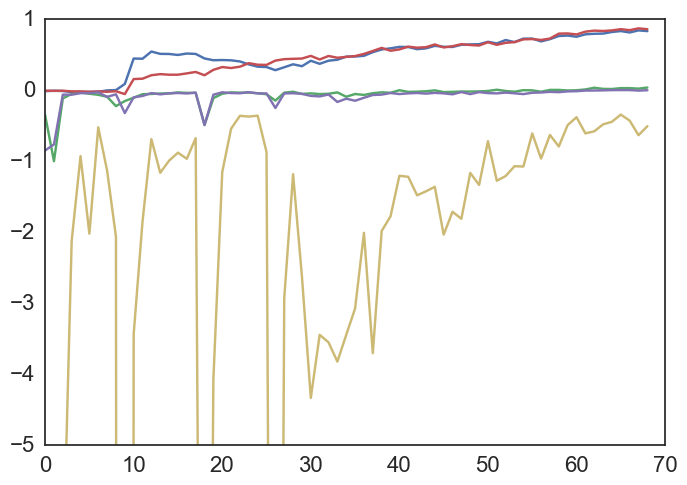

In [19]:
plt.figure()
plt.plot(elu_histories_jump_mu[1], label="Jumps Mu")
plt.plot(elu_histories_jump_sigma[1], label="Jumps Sigma")
plt.plot(elu_histories_mu[1], label="Mu")
plt.plot(elu_histories_sigma[1], label="Sigma")
plt.plot(elu_histories_lambda[1], label="Lambda")
plt.ylim(-5, 1)
plt.xlim(0, 70)

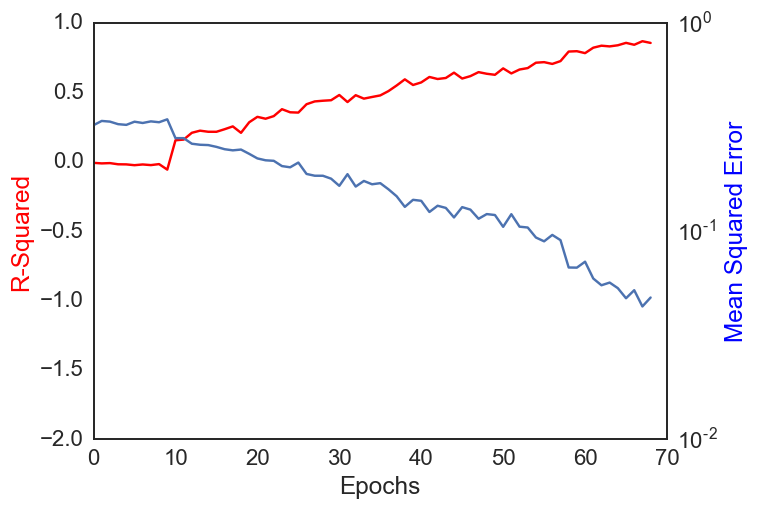

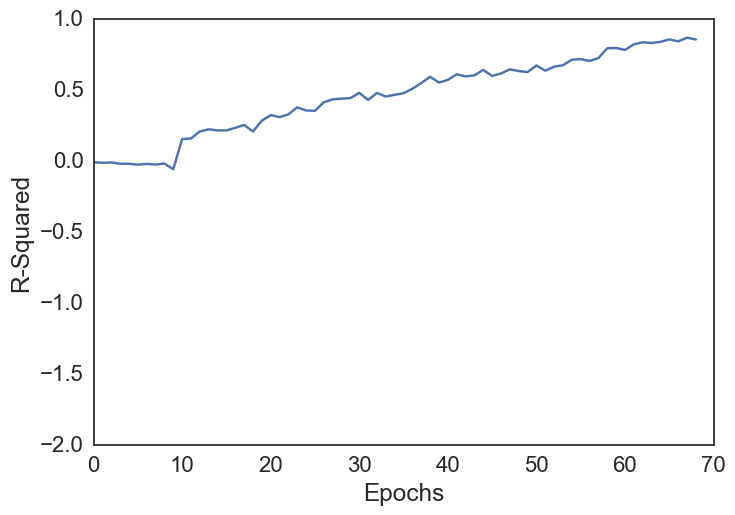

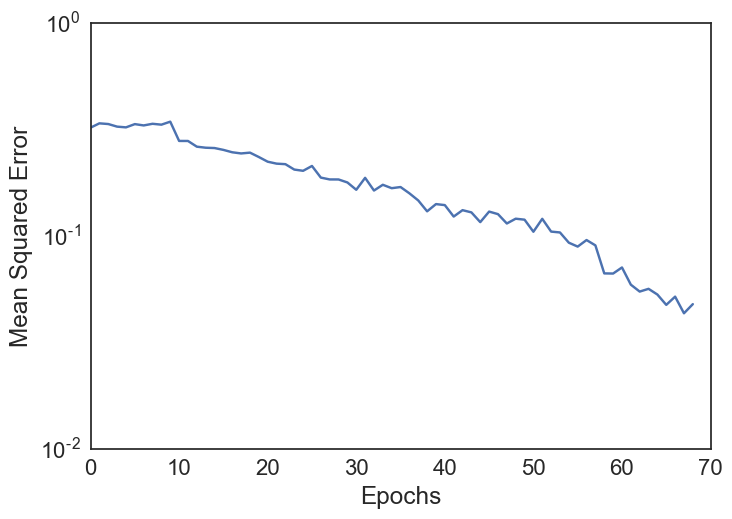

In [21]:
all_training_history_plots(elu_histories_mu, 
                           "FullyConnectedNN-MultipleOutput-ELU",
                           "Mu", r2_ylim = (-2, 1));

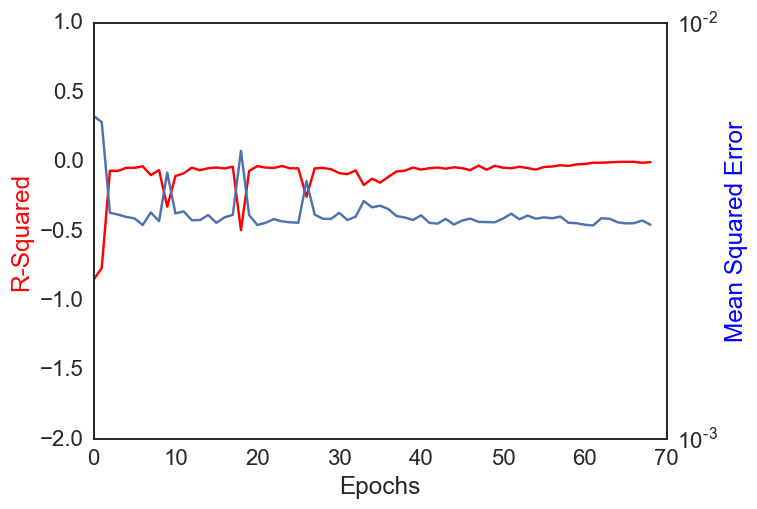

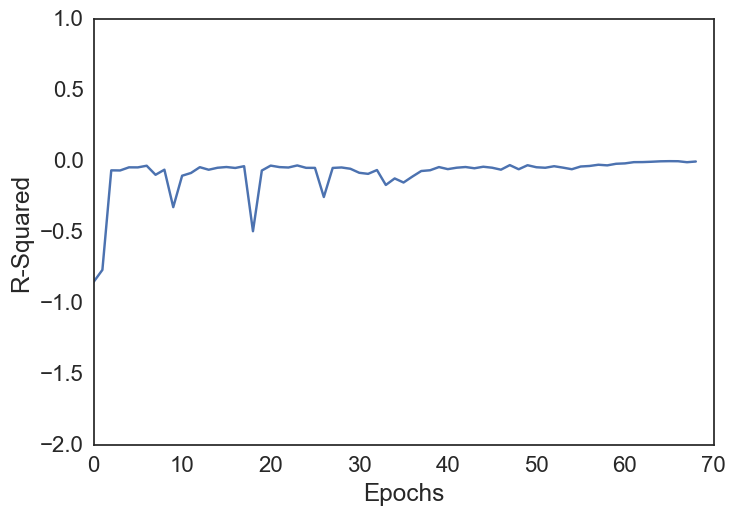

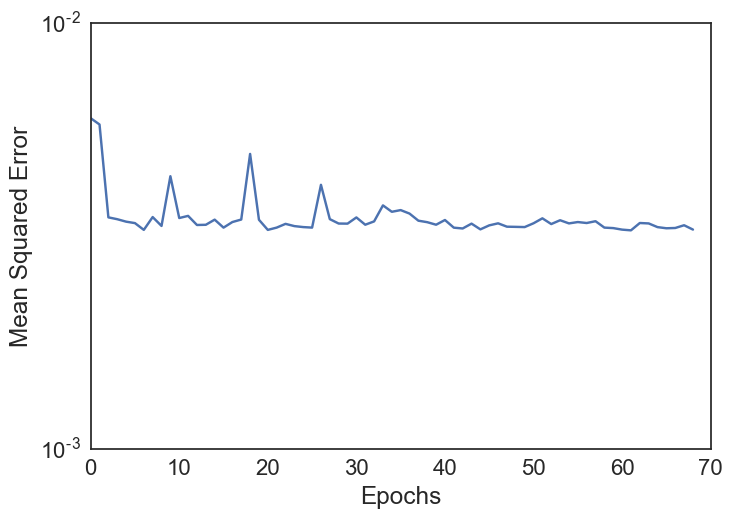

In [22]:
all_training_history_plots(elu_histories_sigma, 
                           "FullyConnectedNN-MultipleOutput-ELU",
                           "Sigma", r2_ylim = (-2, 1));

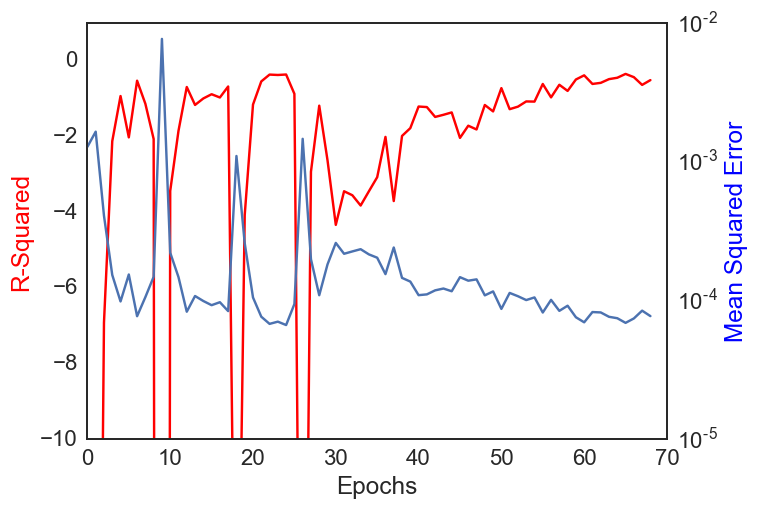

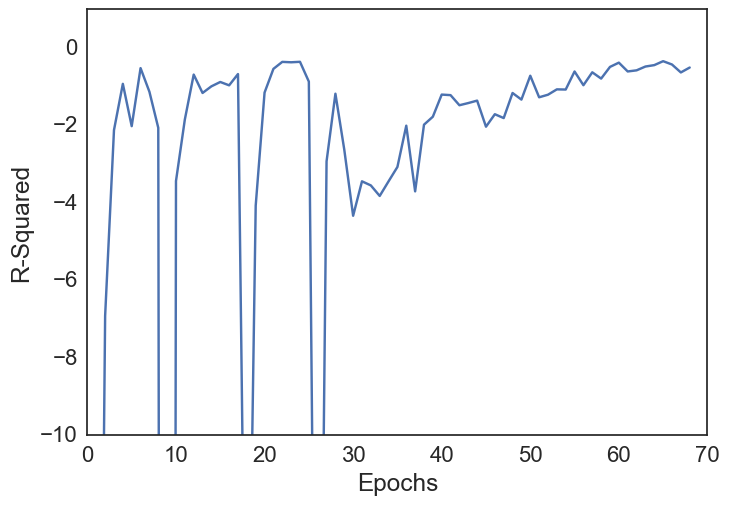

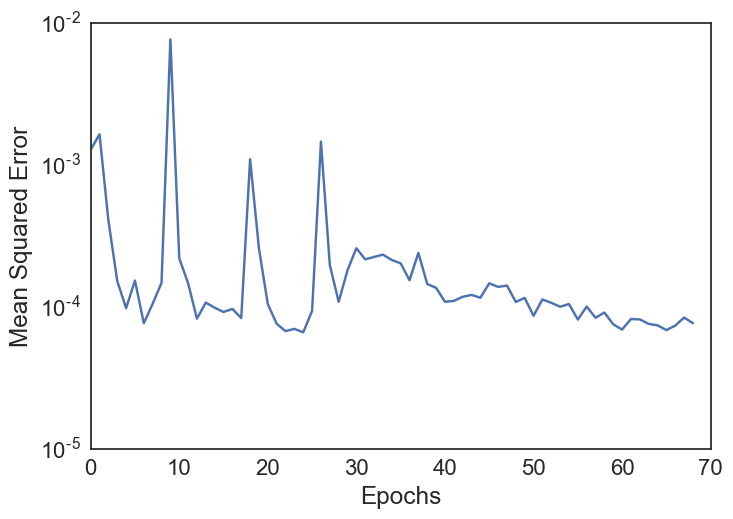

In [23]:
all_training_history_plots(elu_histories_lambda, 
                           "FullyConnectedNN-MultipleOutput-ELU",
                           "Lambda", r2_ylim = (-10, 1));

# Sensitivity Tests

## Multiple Output Model

### Mu

In [12]:
mu_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []

preds_SINGLE_LAMBDA_MEAN = []
preds_SINGLE_LAMBDA_Lower_16 = []
preds_SINGLE_LAMBDA_Upper_84 = []

In [13]:
mp = test_set_model_params()

for j in range(100):
    covnet_mo_elu = covnet_multiple_ELUs_8_layers()
    covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    #covnet_lambda = covnet_single_lambda()
    #covnet_lambda.load_weights(H5_DIR_COVNET_LAMBDA)
    
    mp.gbm_mu = -1 + float(j)/50
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    print("PREDICTION...\n")
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    #predictions_lambda = covnet_lambda.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,       mu,      jump_sigma,   jump_mu,    lambda")
    print("    0.1         "+str(mp.gbm_mu)+"     0.07              0.05       0.02")
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    mu_s.append(mp.gbm_mu)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_Lower_16.npy", preds_Lower_16)    
np.save("Sensitivity_Test-Covnet_MO_Mu_mu_s.npy", mu_s)
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_MEAN.npy", preds_MEAN)

#np.save("Sensitivity_Test-preds_VaryingMu_SINGLE_LAMBDA_MEAN.npy", preds_SINGLE_LAMBDA_MEAN)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Lower_16", preds_SINGLE_LAMBDA_Lower_16)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Upper_84", preds_SINGLE_LAMBDA_Upper_84)

/home/carnd/Stochastic-Process-Calibration-Dissertation/Models.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  convnet_mo_elu = Model(input = input_1, output=[output1, output2, output3, output4, output5])


0
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.09543377  0.0617267   0.07850798  0.06585009  0.01605378]]
   sigma,       mu,      jump_sigma,   jump_mu,    lambda
    0.1         -1.0     0.07              0.05       0.02
1
GENERATION...
0
100
200
300


KeyboardInterrupt: 